#Flood Prediction

Import Required Libraries

In [88]:
import numpy as np
import pandas as pd

In [89]:
ENABLE_OUTPUT = True

## Telemetri Data

In [90]:
def gsheet_to_csv(url: str):
  sheet_url = url
  csv = sheet_url.replace('/edit#gid=', '/export?format=csv&gid=')
  return csv

df_telemetri_rainfall = pd.read_csv(gsheet_to_csv("https://docs.google.com/spreadsheets/d/1nI8m27noE1mMiXQXde8jyXD6-qhuMQ2tE-gXxBkuxi4/edit#gid=0"))
df_telemetri_rainfall

Location       Date   Time  Rainfall  Status
0       Sumur Batu  15-Jul-20  14:00   0.00 mm   Cerah
1       Sumur Batu  15-Jul-20  15:00   0.00 mm  Cerah\
2       Sumur Batu  16-Jul-20   7:00   0.00 mm   Cerah
3       Sumur Batu  17-Jul-20   4:00   0.00 mm   Cerah
4       Sumur Batu  17-Jul-20   6:00   0.00 mm   Cerah
...            ...        ...    ...       ...     ...
182880    Cimanggu  28-Jan-21   3:00   0.00 mm   Cerah
182881    Cimanggu  28-Jan-21   5:00   0.00 mm   Cerah
182882    Cimanggu  28-Jan-21   7:00   0.00 mm   Cerah
182883    Cimanggu  28-Jan-21   8:00  12.00 mm   Lebat
182884    Cimanggu  28-Jan-21  10:00   0.00 mm   Cerah

[182885 rows x 5 columns]

In [91]:
df_telemetri_waterlevel = pd.read_csv(gsheet_to_csv("https://docs.google.com/spreadsheets/d/1xy16th0oBqQ9kux8XGKmkk6AO1flGq1hj1kYqDLn4YI/edit#gid=0"))
df_telemetri_waterlevel.rename(columns = {'Water Level (cm)': 'water_level', 'Date ':'Date'}, inplace = True)
df_telemetri_waterlevel

Location       Date  Time water_level
0        Cileungsi   2-Jun-19  0:00       34 cm
1        Cileungsi   2-Jun-19  1:00       34 cm
2        Cileungsi   2-Jun-19  2:00       34 cm
3        Cileungsi   2-Jun-19  3:00       34 cm
4        Cileungsi   2-Jun-19  4:00       34 cm
...            ...        ...   ...         ...
191548  Margasatwa  22-Jan-21  3:00      552 cm
191549  Margasatwa  22-Jan-21  4:00      552 cm
191550  Margasatwa  22-Jan-21  5:00      552 cm
191551  Margasatwa  22-Jan-21  6:00      552 cm
191552  Margasatwa  22-Jan-21  7:00      552 cm

[191553 rows x 4 columns]

In [92]:
# Pandas Left Join is Out of Memory
# pd.merge(df_telemetri_rainfall, df_telemetri_waterlevel, how="left", on="Location")
# Let's try to use sql

**Pandas Left Join is Out of Memory**
```python
pd.merge(df_telemetri_rainfall, df_telemetri_waterlevel, how="left", on="Location")
```
Let's try to use sql instead

In [93]:
from sqlalchemy import create_engine
engine = create_engine('sqlite://', echo=False)

In [94]:
# Save to sql
df_telemetri_waterlevel.to_sql("telemetri_waterlevel", if_exists="replace", con=engine)
df_telemetri_rainfall.to_sql("telemetri_rainfall", if_exists="replace", con=engine)

In [95]:
# check length
if ENABLE_OUTPUT:
  print(len(df_telemetri_rainfall))
  print(len(df_telemetri_waterlevel))

182885
191553


Join operations ini untuk menggabungkan data dengan cara mengambil semua data yang memiliki nilai **water_level** dan **Rainfall** (jika ada label data banjir dari PUPR)
```
SELECT 
  tr.Date AS Date,
  tr.Time AS Time,
  tr.Location AS Location,
  tr.Rainfall AS Rainfall,
  tr.Status AS RainfallStatus,
  tw.water_level AS WaterLevel
FROM telemetri_rainfall AS tr
LEFT JOIN telemetri_waterlevel AS tw
ON tr.Location = tw.Location AND tr.Date = tw.Date AND tr.Time = tw.Time

UNION

SELECT 
  tw.Date AS Date,
  tw.Time AS Time,
  tw.Location AS Location,
  tr.Rainfall AS Rainfall,
  tr.Status AS RainfallStatus,
  tw.water_level AS WaterLevel
FROM telemetri_waterlevel AS tw
LEFT JOIN telemetri_rainfall AS tr
ON tr.Location = tw.Location AND tr.Date = tw.Date AND tr.Time = tw.Time
```
Namun karena menggunakan asumsi bahwa jika **RainfallStatus** == lebat  sebagai label banjir maka digunakan join ini
```
SELECT 
  tr.Date AS Date,
  tr.Time AS Time,
  tr.Location AS Location,
  tr.Rainfall AS Rainfall,
  tr.Status AS RainfallStatus,
  tw.water_level AS WaterLevel
FROM telemetri_rainfall AS tr
LEFT JOIN telemetri_waterlevel AS tw
ON tr.Location = tw.Location AND tr.Date = tw.Date AND tr.Time = tw.Time
```

In [96]:
query = engine.execute('''
SELECT 
  tr.Date AS Date,
  tr.Time AS Time,
  tr.Location AS Location,
  tr.Rainfall AS Rainfall,
  tr.Status AS RainfallStatus,
  tw.water_level AS WaterLevel
FROM telemetri_rainfall AS tr
LEFT JOIN telemetri_waterlevel AS tw
ON tr.Location = tw.Location AND tr.Date = tw.Date AND tr.Time = tw.Time
''')
df_tmrain_tmwater = pd.DataFrame(query.fetchall())
df_tmrain_tmwater.columns = query.keys()
if ENABLE_OUTPUT: df_tmrain_tmwater

In [97]:
df_tmrain_tmwater.describe()

Date    Time           Location Rainfall RainfallStatus WaterLevel
count     182885  182882             182885   182882         182882      11148
unique      1221      24                 19      297              9        258
top     2-Sep-20   12:00  Bendungan Gintung  0.00 mm          Cerah   9,690 cm
freq         384    7776              19218   173749         173669       2558

## Preprocessing Data

Number of Missing Value 

In [98]:
df_tmrain_tmwater.isnull().sum() 

Date                   0
Time                   3
Location               0
Rainfall               3
RainfallStatus         3
WaterLevel        171737
dtype: int64

In [99]:
df_tmrain_tmwater['RainfallStatus'].unique()

array(['Cerah', 'Cerah\\', 'Lebat', 'Ringan', 'Sedang', 'Sangat Lebat',
       'Bright', 'Is', 'Light', None], dtype=object)

In [100]:
# Clean Column RainfallStatus
df_tmrain_tmwater.loc[df_tmrain_tmwater['RainfallStatus']=='Cerah\\', 'RainfallStatus'] = "Cerah"
df_tmrain_tmwater.loc[df_tmrain_tmwater['RainfallStatus']=='Light', 'RainfallStatus'] = "Ringan"
df_tmrain_tmwater.loc[df_tmrain_tmwater['RainfallStatus']=='Is', 'RainfallStatus'] = "Sedang"
df_tmrain_tmwater.loc[df_tmrain_tmwater['RainfallStatus']=='Bright', 'RainfallStatus'] = "Cerah"
df_tmrain_tmwater = df_tmrain_tmwater[df_tmrain_tmwater['RainfallStatus'].notna()]
if ENABLE_OUTPUT: df_tmrain_tmwater['RainfallStatus'].unique()

### Data metrics defenition
* Rainfall (mm)

  1mm rainfall means every one square meter area is filled with the water of height 1mm.
  1 square meter = 1000mm length ×1000mm breath
  So 1mm rain means 1000mm length × 1000mm breath × 1mm height = 1litre of water.
  Every square meter has one litre of water

In [101]:
df_tmrain_tmwater[df_tmrain_tmwater['WaterLevel'].notna()][df_tmrain_tmwater['RainfallStatus'] == "Lebat"]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


Date   Time           Location  Rainfall RainfallStatus WaterLevel
66126    6-Jul-20   7:00          Manggarai  14.00 mm          Lebat     205 cm
66329   15-Jul-20   1:00          Manggarai  16.00 mm          Lebat     296 cm
67801   14-Sep-20  21:00          Manggarai  16.00 mm          Lebat     749 cm
67821   15-Sep-20  17:00          Manggarai  12.00 mm          Lebat     749 cm
69492   24-Nov-20  17:00          Manggarai  12.00 mm          Lebat     645 cm
...           ...    ...                ...       ...            ...        ...
126835  20-Nov-20  16:00  Bendungan Gintung  12.00 mm          Lebat   9,660 cm
127061  30-Nov-20  10:00  Bendungan Gintung  13.00 mm          Lebat   9,630 cm
127062  30-Nov-20  11:00  Bendungan Gintung  14.00 mm          Lebat   9,630 cm
127221   7-Dec-20  13:00  Bendungan Gintung  15.00 mm          Lebat   9,650 cm
127730  29-Dec-20  11:00  Bendungan Gintung  12.00 mm          Lebat   9,670 cm

[94 rows x 6 columns]

In [102]:
# Convert metrics to float

from re import compile as re_compile, sub as re_sub

re_rainfall_metric = re_compile(r'[^\d.]')
re_waterlevel_metric = re_compile(r'[^\d,]')

def rainfall_metric_to_float(metric):
  try:
    return float(re_rainfall_metric.sub('', metric))
  except Exception as err:
    return -1.0
def waterlevel_metric_to_float(metric):
  try:
    return float(re_sub(r',', '', re_waterlevel_metric.sub('', metric)))
  except Exception as err:
    return -1.0
ds_tmrain_tmwater_rainfall = df_tmrain_tmwater.apply(lambda row: rainfall_metric_to_float(str(row["Rainfall"])), axis=1)
ds_tmrain_tmwater_waterlevel = df_tmrain_tmwater.apply(lambda row: waterlevel_metric_to_float(str(row["WaterLevel"])), axis=1)

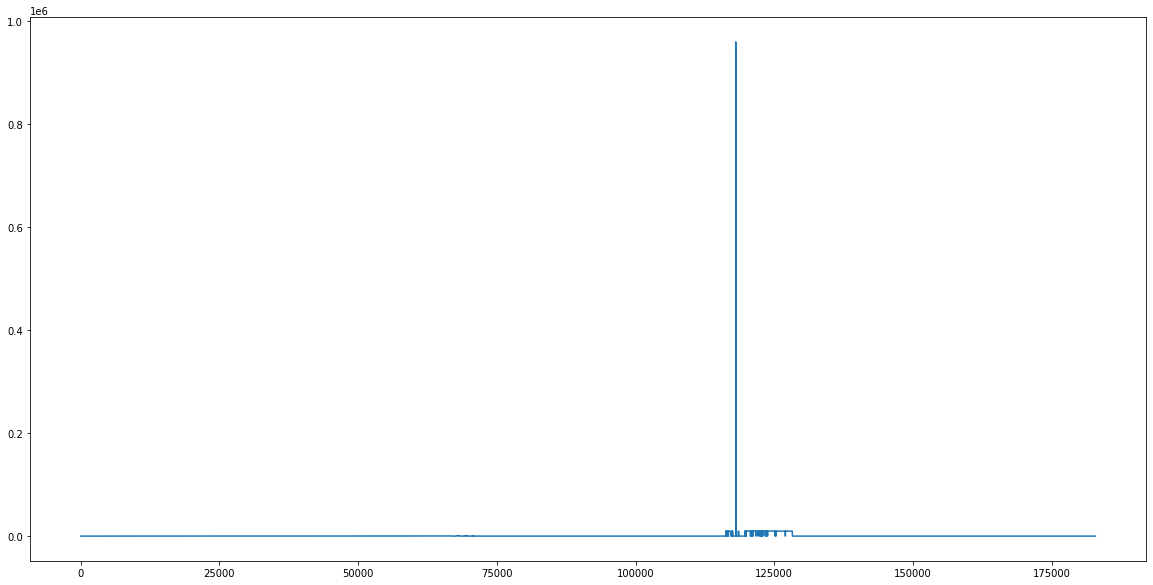

In [103]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [20, 10]

if ENABLE_OUTPUT: ds_tmrain_tmwater_waterlevel.plot()

In [104]:
water_level_value_replacement = ds_tmrain_tmwater_waterlevel[ds_tmrain_tmwater_waterlevel != -1].std()
water_level_value_replacement

9607.569186585744

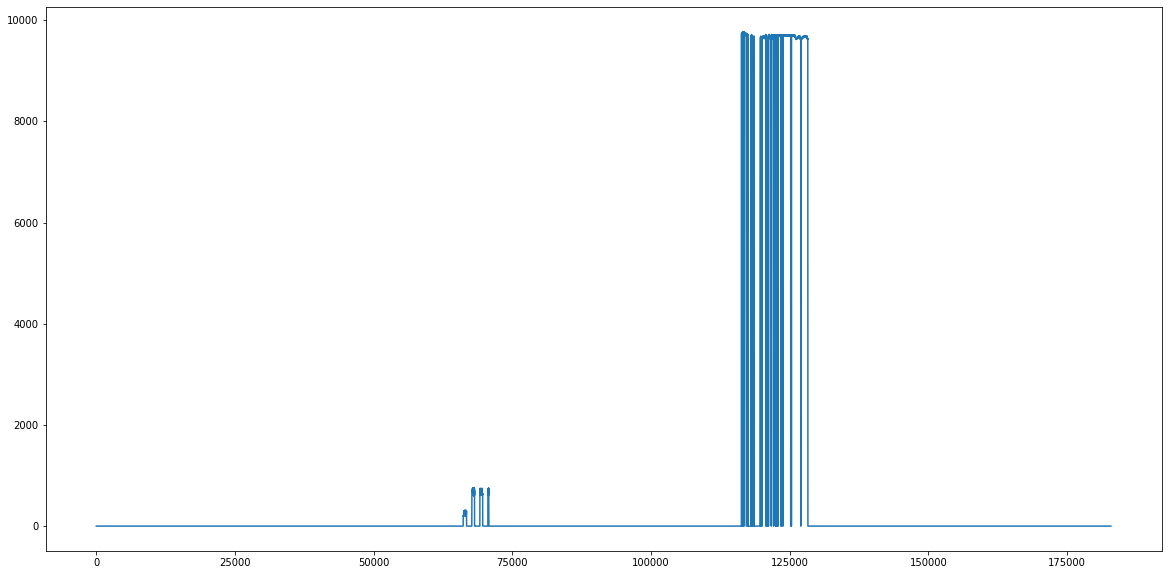

In [105]:
# There is high spikes (probably measurement error)
max_idx = ds_tmrain_tmwater_waterlevel[ds_tmrain_tmwater_waterlevel == ds_tmrain_tmwater_waterlevel.max()].index[0]
ds_tmrain_tmwater_waterlevel[max_idx] = water_level_value_replacement
if ENABLE_OUTPUT: ds_tmrain_tmwater_waterlevel.plot()

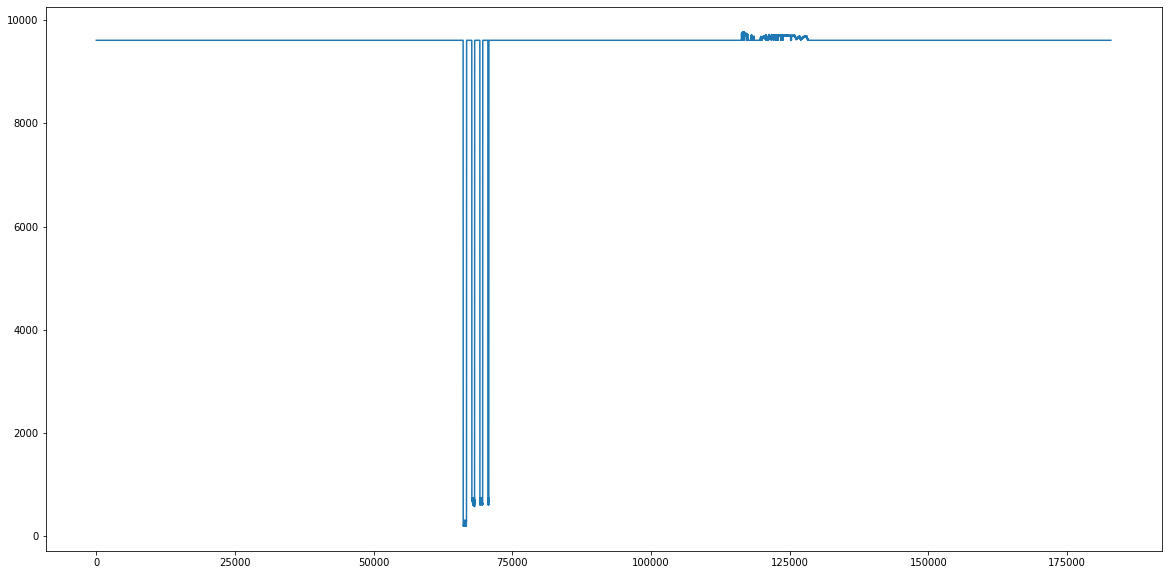

In [106]:
# Let's also replace missing value (-1) there
ds_tmrain_tmwater_waterlevel[ds_tmrain_tmwater_waterlevel == -1] = water_level_value_replacement
if ENABLE_OUTPUT: ds_tmrain_tmwater_waterlevel.plot()

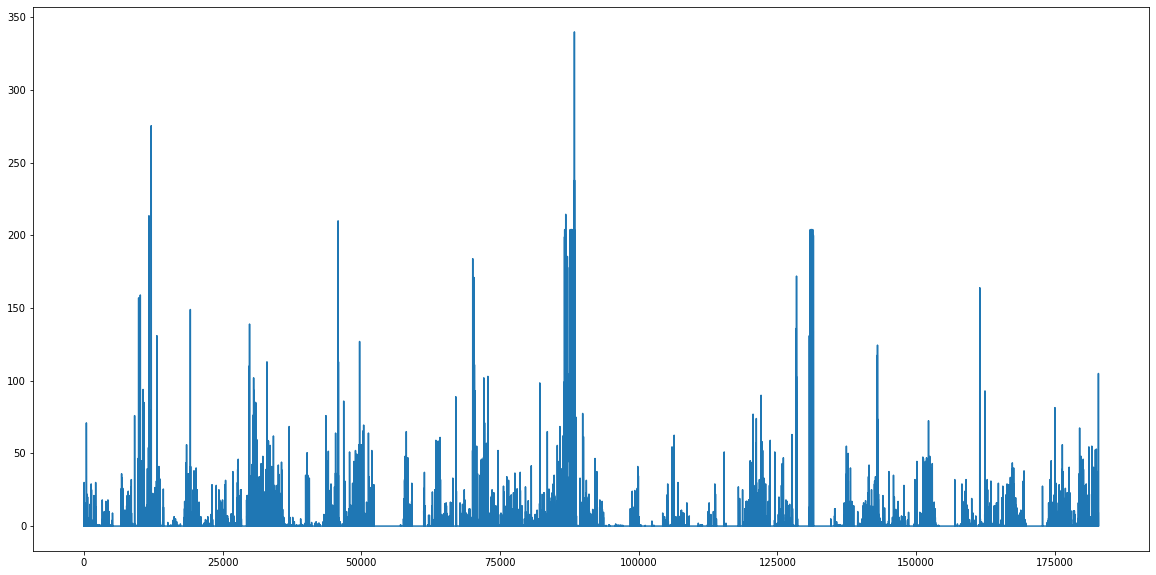

In [107]:
if ENABLE_OUTPUT: ds_tmrain_tmwater_rainfall.plot()

In [108]:
# Looks good, let's join to main df
df_tmrain_tmwater["WaterLevel"] = ds_tmrain_tmwater_waterlevel
df_tmrain_tmwater["Rainfall"] = ds_tmrain_tmwater_rainfall
df_tmrain_tmwater

Date   Time    Location  Rainfall RainfallStatus   WaterLevel
0       15-Jul-20  14:00  Sumur Batu       0.0          Cerah  9607.569187
1       15-Jul-20  15:00  Sumur Batu       0.0          Cerah  9607.569187
2       16-Jul-20   7:00  Sumur Batu       0.0          Cerah  9607.569187
3       17-Jul-20   4:00  Sumur Batu       0.0          Cerah  9607.569187
4       17-Jul-20   6:00  Sumur Batu       0.0          Cerah  9607.569187
...           ...    ...         ...       ...            ...          ...
182880  28-Jan-21   3:00    Cimanggu       0.0          Cerah  9607.569187
182881  28-Jan-21   5:00    Cimanggu       0.0          Cerah  9607.569187
182882  28-Jan-21   7:00    Cimanggu       0.0          Cerah  9607.569187
182883  28-Jan-21   8:00    Cimanggu      12.0          Lebat  9607.569187
182884  28-Jan-21  10:00    Cimanggu       0.0          Cerah  9607.569187

[182882 rows x 6 columns]

In [109]:
from datetime import datetime
def convert_to_datetime(date: str):
  try:
    return datetime.strptime(date, '%d-%b-%y')
  except ValueError:
    return datetime.strptime(date, '%d-%B-%y')

df_tmrain_tmwater['Date'] = df_tmrain_tmwater.apply(lambda row: convert_to_datetime(row["Date"]), axis=1)
if ENABLE_OUTPUT: df_tmrain_tmwater

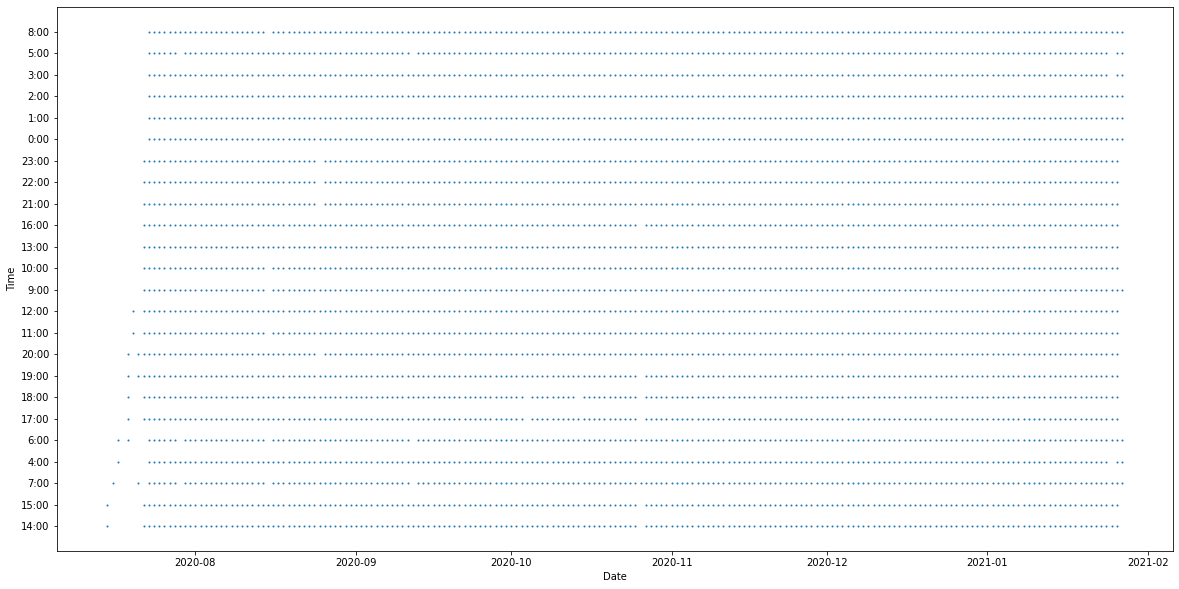

In [110]:
# See if time is regularly updated

df_tmrain_tmwater[df_tmrain_tmwater["Location"] == "Sumur Batu"].plot("Date", "Time", kind="scatter", s=1)

There are many missing values! (Not regular)

Let's just take by date and not by time

In [111]:
df_tmrain_tmwater_days = df_tmrain_tmwater.sort_values("Rainfall", ascending=False).groupby(["Location", "Date"]).head(1)
df_tmrain_tmwater_days

Date   Time        Location  Rainfall RainfallStatus   WaterLevel
88413 2020-08-03   3:00       Kampus UI     340.0   Sangat Lebat  9607.569187
12135 2019-02-11  16:00          Cawang     275.5          Lebat  9607.569187
88435 2020-08-04   1:00       Kampus UI     216.5   Sangat Lebat  9607.569187
86852 2020-05-20   6:00       Kampus UI     214.5   Sangat Lebat  9607.569187
11722 2019-01-25  10:00          Cawang     213.5          Lebat  9607.569187
...          ...    ...             ...       ...            ...          ...
62148 2020-08-08   8:00  Kampung Kelapa       0.0          Cerah  9607.569187
62063 2020-08-04  19:00  Kampung Kelapa       0.0          Cerah  9607.569187
62005 2020-08-02   9:00  Kampung Kelapa       0.0          Cerah  9607.569187
62321 2020-08-15  23:00  Kampung Kelapa       0.0          Cerah  9607.569187
62192 2020-08-10   4:00  Kampung Kelapa       0.0          Cerah  9607.569187

[8276 rows x 6 columns]

In [112]:
# Asumsi Labeling
df_tmrain_tmwater_days['Banjir'] = df_tmrain_tmwater_days.apply(lambda row: 1 if str(row['RainfallStatus']).lower() == "lebat" or str(row['RainfallStatus']).lower() == "sangat lebat" else 0, axis=1)
df_tmrain_tmwater_days

Date   Time        Location  ...  RainfallStatus   WaterLevel  Banjir
88413 2020-08-03   3:00       Kampus UI  ...    Sangat Lebat  9607.569187       1
12135 2019-02-11  16:00          Cawang  ...           Lebat  9607.569187       1
88435 2020-08-04   1:00       Kampus UI  ...    Sangat Lebat  9607.569187       1
86852 2020-05-20   6:00       Kampus UI  ...    Sangat Lebat  9607.569187       1
11722 2019-01-25  10:00          Cawang  ...           Lebat  9607.569187       1
...          ...    ...             ...  ...             ...          ...     ...
62148 2020-08-08   8:00  Kampung Kelapa  ...           Cerah  9607.569187       0
62063 2020-08-04  19:00  Kampung Kelapa  ...           Cerah  9607.569187       0
62005 2020-08-02   9:00  Kampung Kelapa  ...           Cerah  9607.569187       0
62321 2020-08-15  23:00  Kampung Kelapa  ...           Cerah  9607.569187       0
62192 2020-08-10   4:00  Kampung Kelapa  ...           Cerah  9607.569187       0

[8276 rows x 7 columns]

In [113]:
# Berapa banjir ya
df_tmrain_tmwater_days["Banjir"].sum()

976

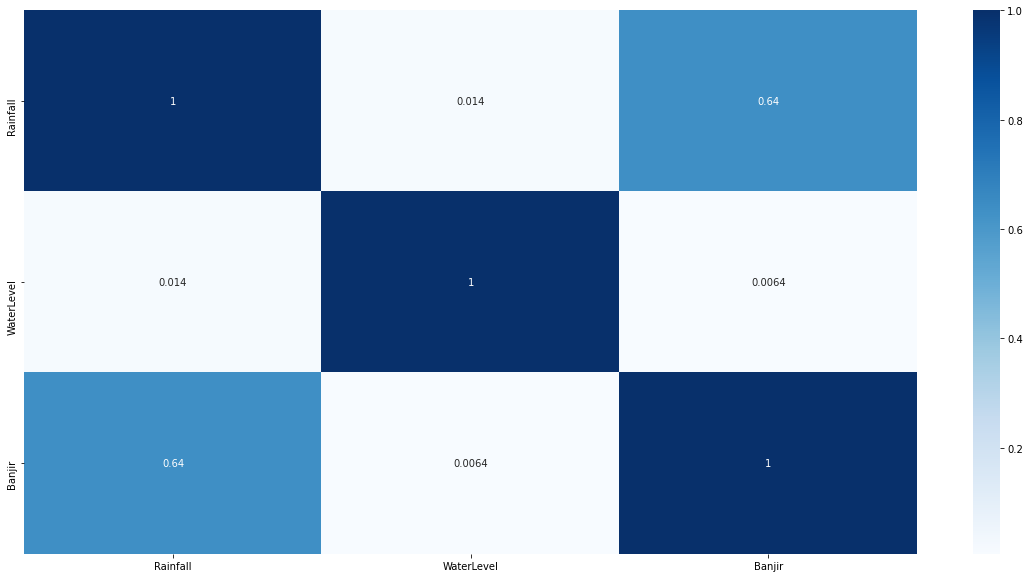

In [114]:
# Bagaimana korelasi WaterLevel, Rainfall, dan Banjir?
import seaborn as sb
if ENABLE_OUTPUT: sb.heatmap(df_tmrain_tmwater_days[["Rainfall", "WaterLevel", "Banjir"]].corr(), cmap="Blues", annot=True)

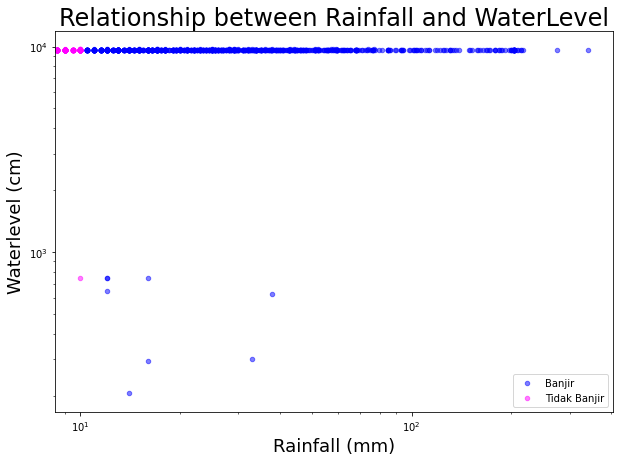

In [115]:
if ENABLE_OUTPUT: 
  ax1 = df_tmrain_tmwater_days[df_tmrain_tmwater_days['Banjir'] == 1].plot(kind='scatter', x='Rainfall', y='WaterLevel', color='blue', alpha=0.5, figsize=(10, 7), logx=True, logy=True)
  df_tmrain_tmwater_days[df_tmrain_tmwater_days['Banjir'] == 0].plot(kind='scatter', x='Rainfall', y='WaterLevel', color='magenta', alpha=0.5, figsize=(10 ,7), ax=ax1, logx=True, logy=True)
  plt.legend(labels=['Banjir', 'Tidak Banjir'])
  plt.title('Relationship between Rainfall and WaterLevel', size=24)
  plt.xlabel('Rainfall (mm)', size=18)
  plt.ylabel('Waterlevel (cm)', size=18);

Tidak terlalu bagus untuk WaterLevel vs Banjir (Mungkin karena data tidak lengkap)


Karena tidak bagus korelasinya, maka digunakan satu kolom saja yakni 

X[Rainfall]

Y[Banjir]



## Create Model

### Classification Based On Place And Rainfall Size (KNN)

In [116]:
import pickle
import json

class Transformer:
  """Convert non numeric categorical data to numeric value
  """
  def __init__(self):
    self.mapping_keys = {}
    self.mapping_location = "transformer-map.json"

  def load(self):
    self.mapping_keys = json.load(open(self.mapping_location, "r"))
    return self.mapping_location

  def fit_transform(self, df):
    columns = df.columns.values
    self.mapping_keys = {}

    for column in columns:
      text_digit_vals = {}
      if df[column].dtype != np.int64 and df[column].dtype != np.float64 and not np.issubdtype(df[column].dtype, np.datetime64):
        column_contents = df[column].values.tolist()
        unique_elements = sorted(set(column_contents), key=lambda x: str(x))
        x = 0
        for unique in unique_elements:
          if unique not in text_digit_vals:
            text_digit_vals[unique] = x
            x += 1
        df[column] = df.apply(lambda row: text_digit_vals[row[column]], axis=1)
        self.mapping_keys[column] = text_digit_vals

    return df

  def transform(self, df):
    columns = df.columns.values
    for column in columns:
      if df[column].dtype != np.int64 and df[column].dtype != np.float64:
        df[column] = df.apply(lambda row: self.mapping_keys[column][row[column]], axis=1)
    return df
  
  def save_mapping(self):
    json.dump(self.mapping_keys, open(self.mapping_location, "w"))
    return self.mapping_location

In [117]:
import sklearn
from sklearn import preprocessing
# Convert categorical data to mapping numbers
transformer = Transformer()
df_tmrain_tmwater_days = transformer.fit_transform(df_tmrain_tmwater_days)
# save to csv
df_tmrain_tmwater_days.to_csv("df_tmrain_tmwater_days.csv", index=False)
# Normalization of Rainfall values
scaler = sklearn.preprocessing.StandardScaler()
df_tmrain_tmwater_days["Rainfall"] = scaler.fit_transform(df_tmrain_tmwater_days["Rainfall"].values.reshape(-1,1)).ravel()
pickle.dump(scaler, open("scaler.pkl", "wb"))
# Save banjir mapping
banjir_mapping_location = transformer.save_mapping()

In [118]:
# Training
import numpy as np
from sklearn import model_selection, neighbors # cross_validation has been deprecated so use model_selection instead
import pandas as pd
import os
if not os.path.exists('models'): os.makedirs('models') # model saving location

X = np.array(df_tmrain_tmwater_days[["Location", "Rainfall"]])
y = np.array(df_tmrain_tmwater_days['Banjir'])

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,y,test_size=0.2)

clf = neighbors.KNeighborsClassifier()

clf.fit(X_train, y_train)

# save classifier model
pickle.dump(clf, open("models/mknn-predict-banjir.pkl", "wb"))

accuracy = clf.score(X_test, y_test)
if ENABLE_OUTPUT: print('Accuracy=', accuracy)

Accuracy= 0.9975845410628019


In [119]:
# Predicting

def predict_banjir(input_value):
  df_banjir_to_predict = pd.DataFrame(input_value, columns=["Location", "Rainfall"])
  df_banjir_to_predict = transformer.transform(df_banjir_to_predict)

  # Normalize Rainfall
  df_banjir_to_predict["Rainfall"] = scaler.transform(df_banjir_to_predict["Rainfall"].values.reshape(-1, 1)).ravel()

  if ENABLE_OUTPUT: print('Input=',input_value)
  predictions = clf.predict(df_banjir_to_predict.values)
  if ENABLE_OUTPUT: print('Predictions', predictions)
  return predictions

predict_banjir([["Cawang", 213.5],["Kampung Kelapa", 0],["Cawang", 213.5]])

Input= [['Cawang', 213.5], ['Kampung Kelapa', 0], ['Cawang', 213.5]]
Predictions [1 0 1]


array([1, 0, 1])

### Rainfall Forecasting Model (Linear Regression)

In [120]:
def get_rainfall_by_location(location, upto_date=None):
  if upto_date:
    return df_tmrain_tmwater_days[["Date", "Location", "Rainfall", "Banjir"]][df_tmrain_tmwater_days["Location"] == location].sort_values("Date")[df_tmrain_tmwater_days["Date"] <= upto_date]
  return df_tmrain_tmwater_days[["Date", "Location", "Rainfall", "Banjir"]][df_tmrain_tmwater_days["Location"] == location].sort_values("Date")

0


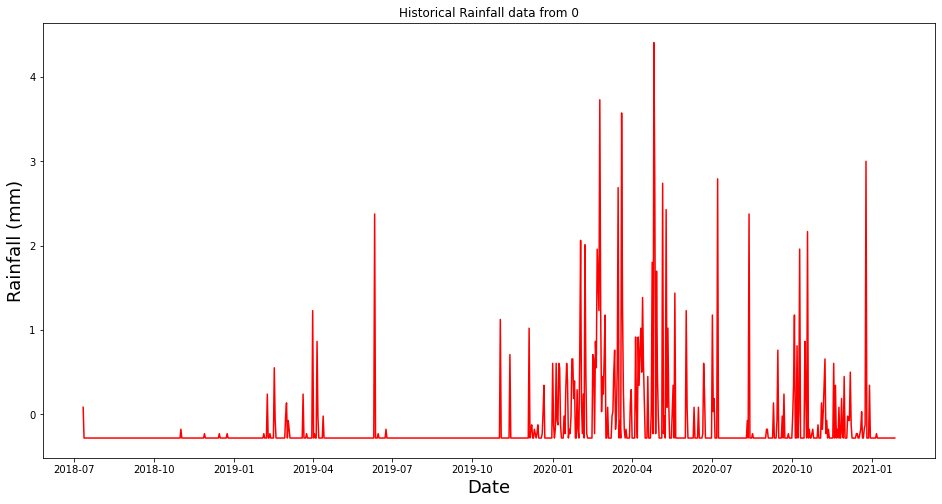

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


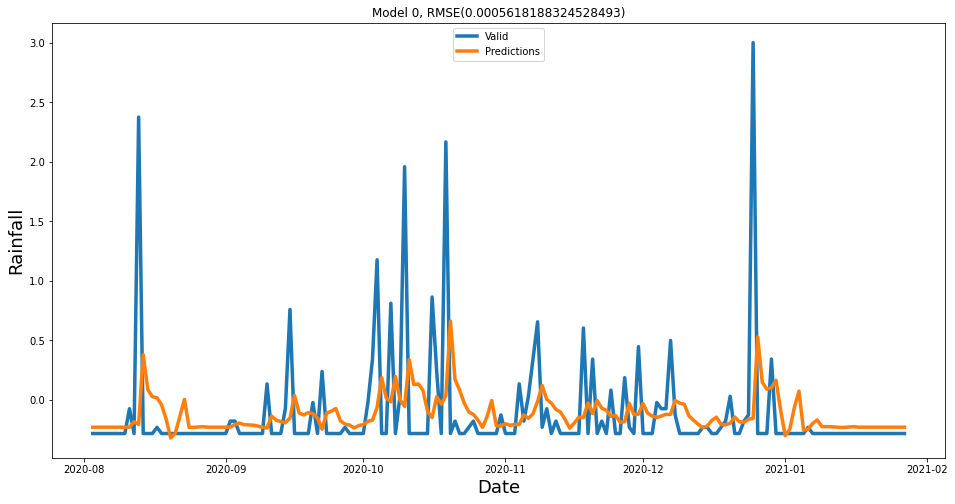

1


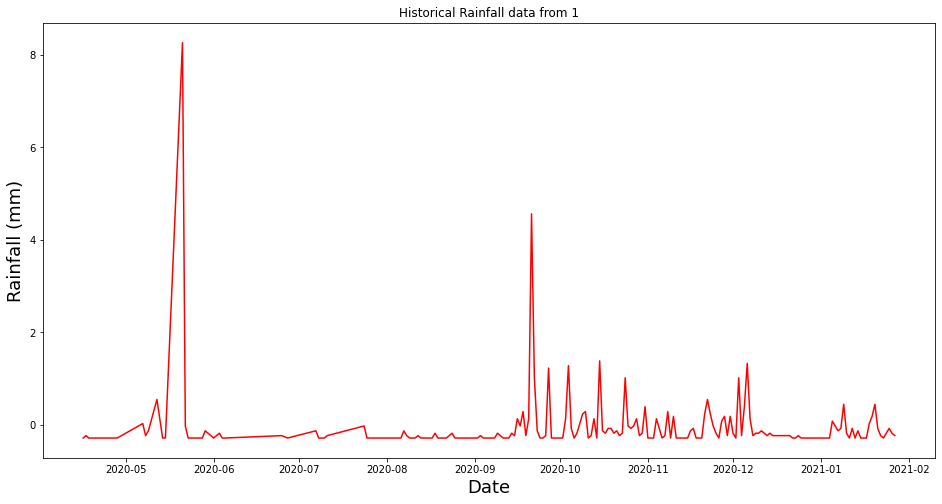

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


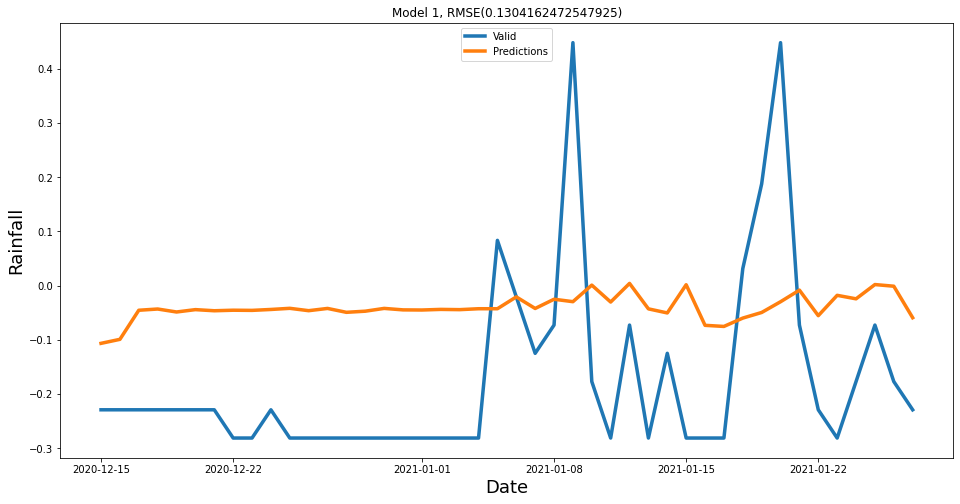

2


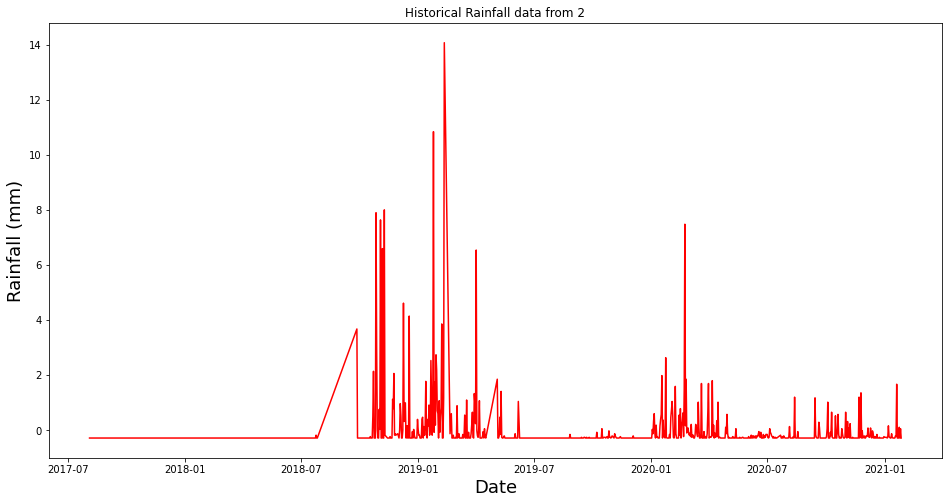

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


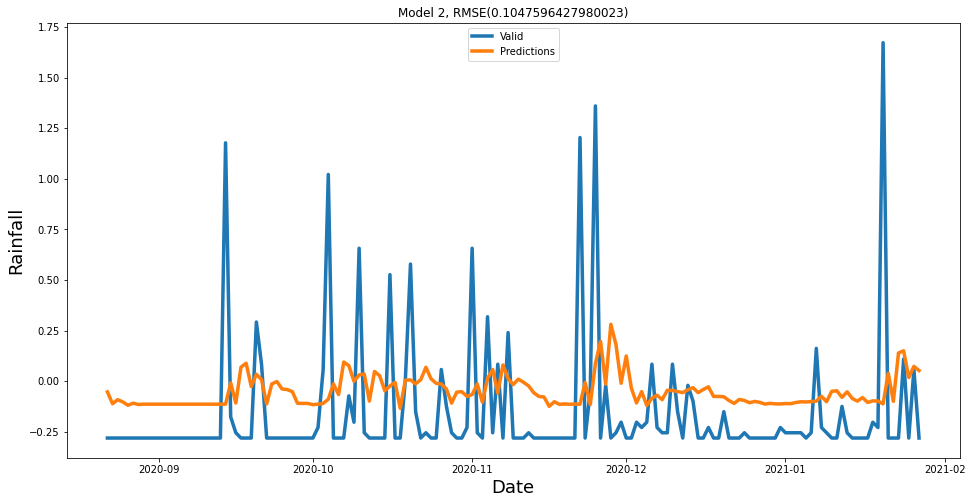

3


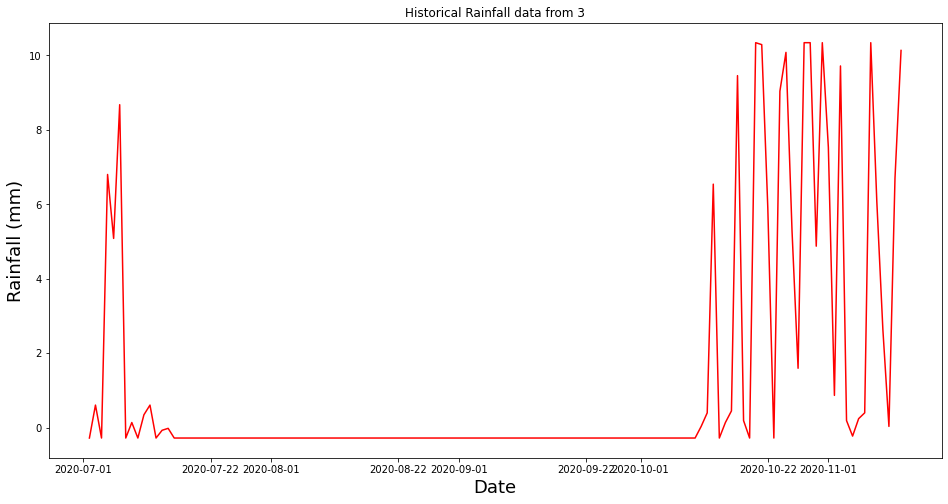

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


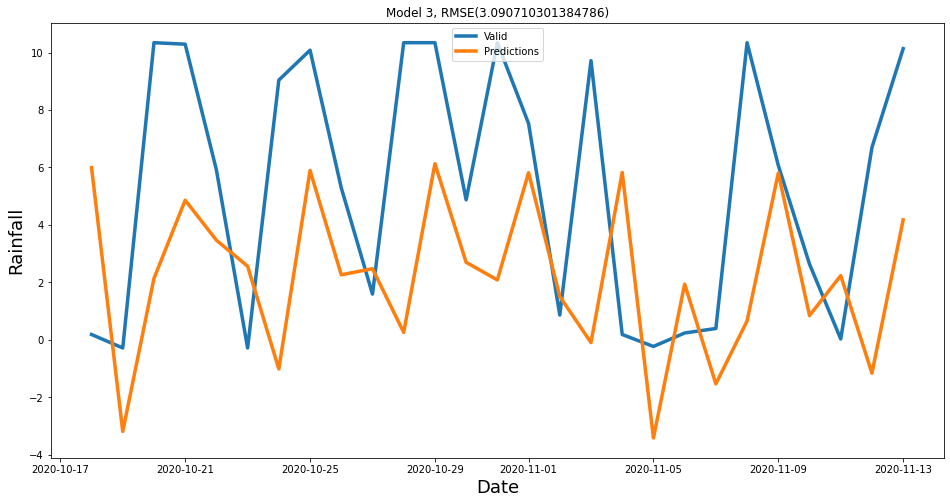

4


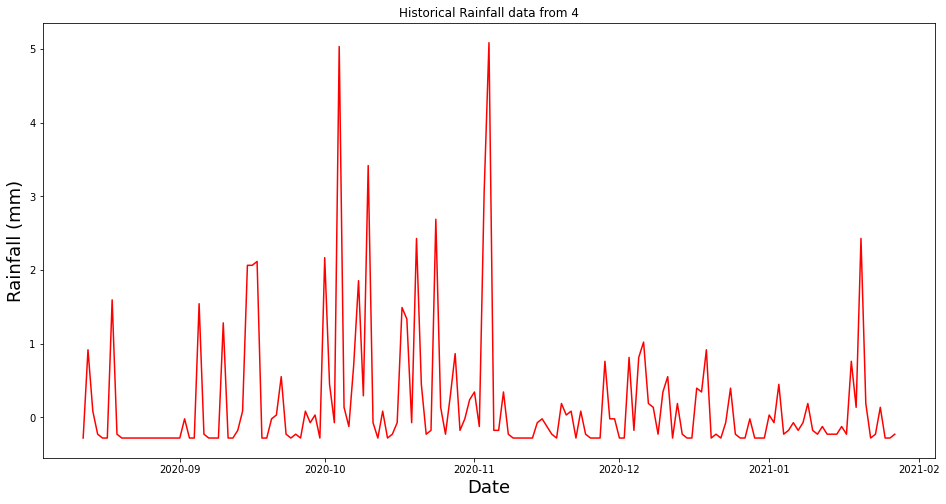

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


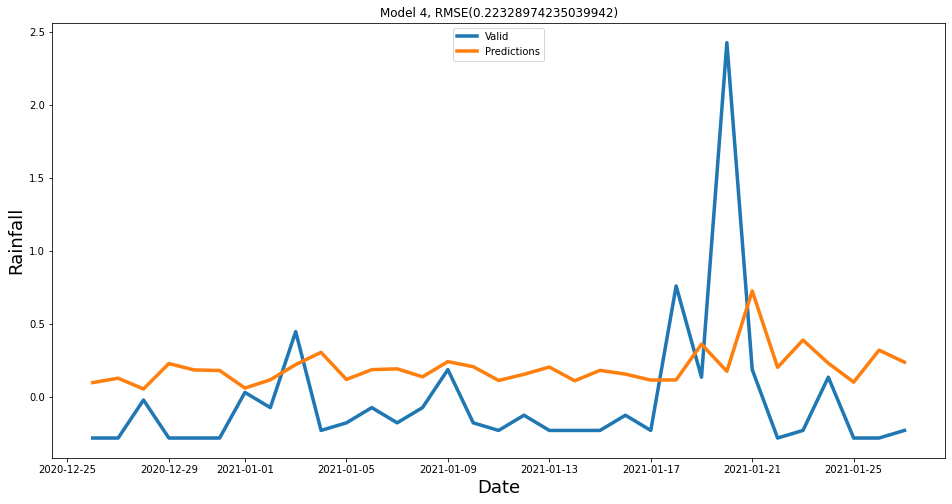

5


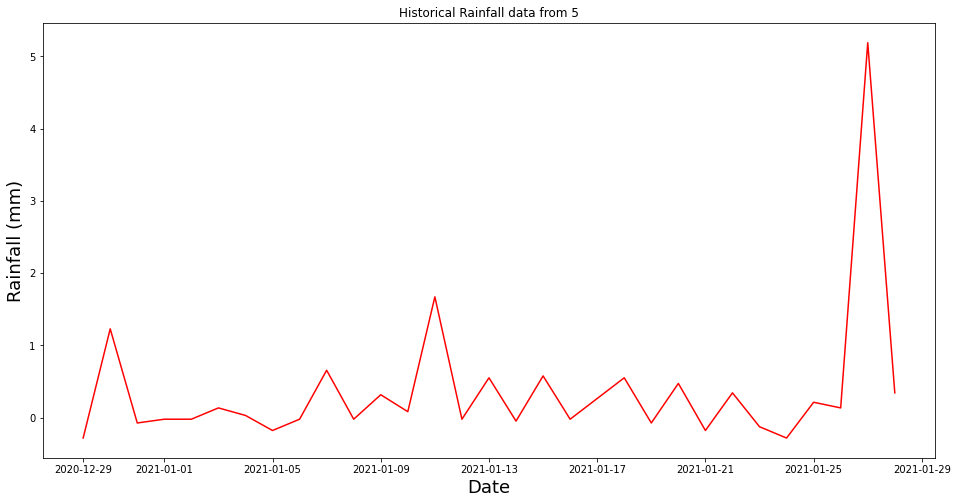

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


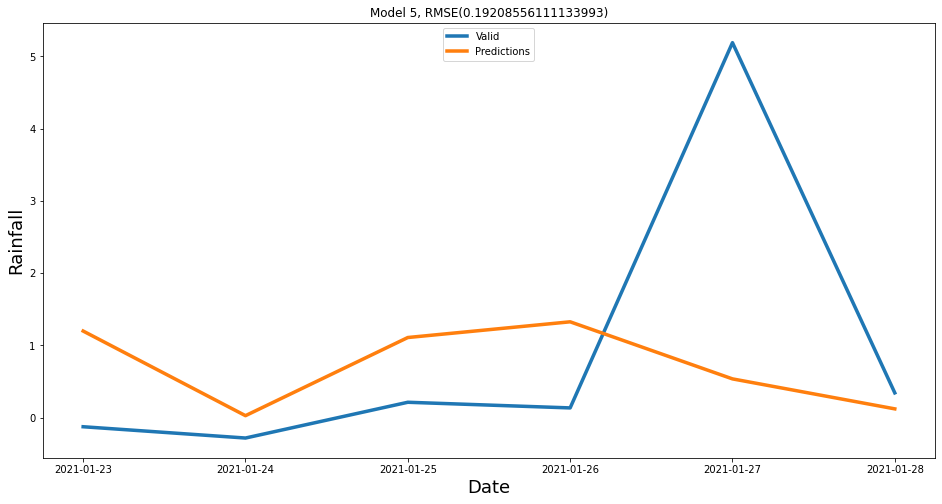

6


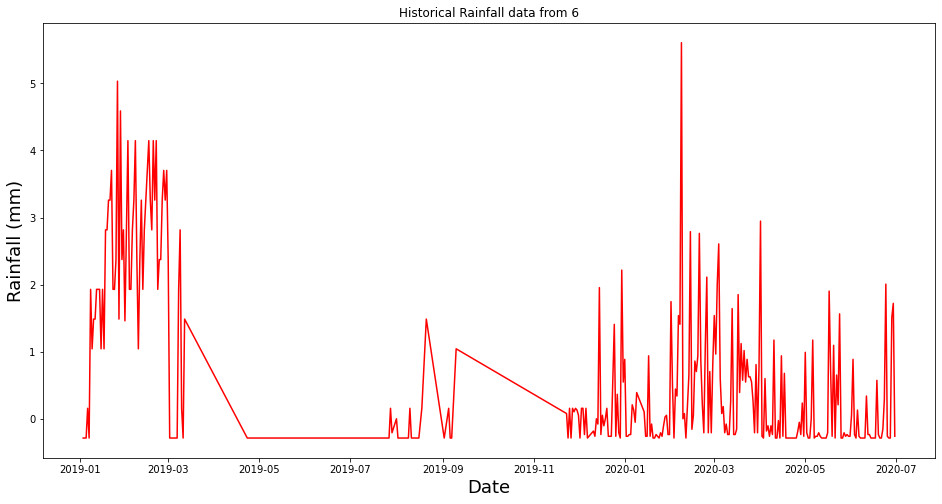

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


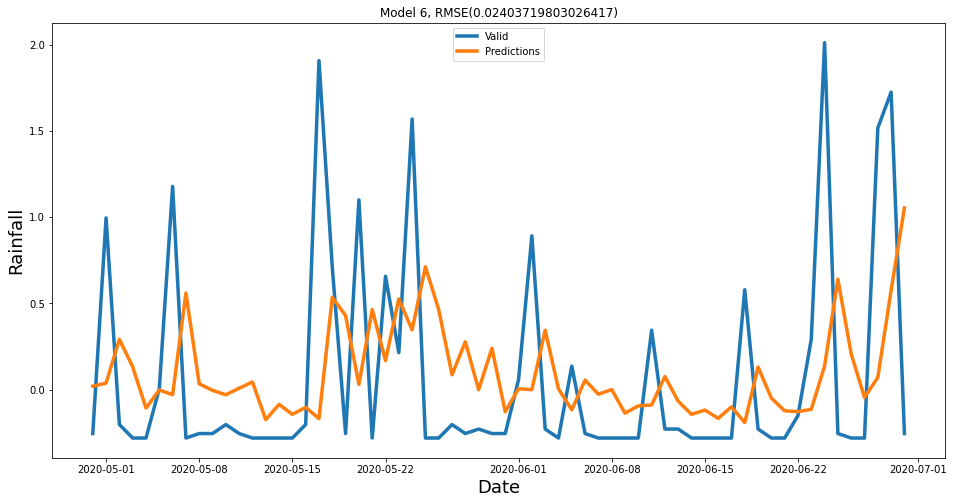

7


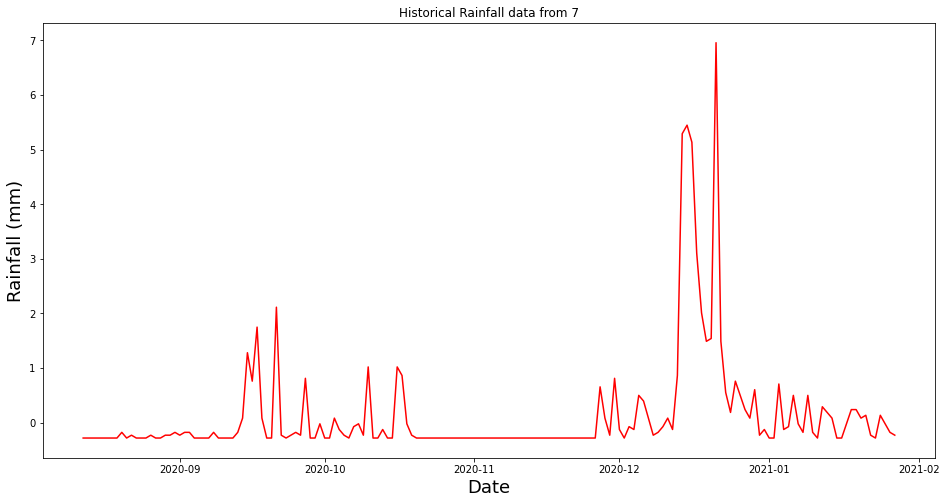

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


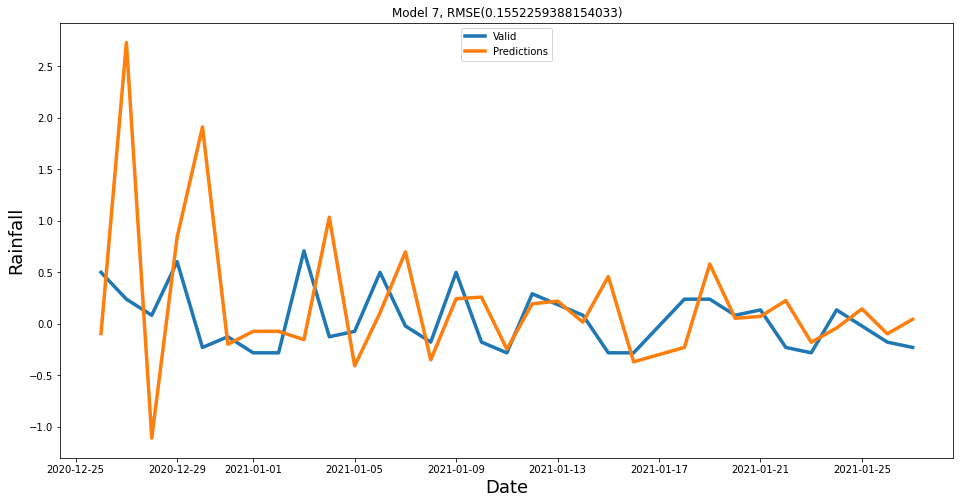

8


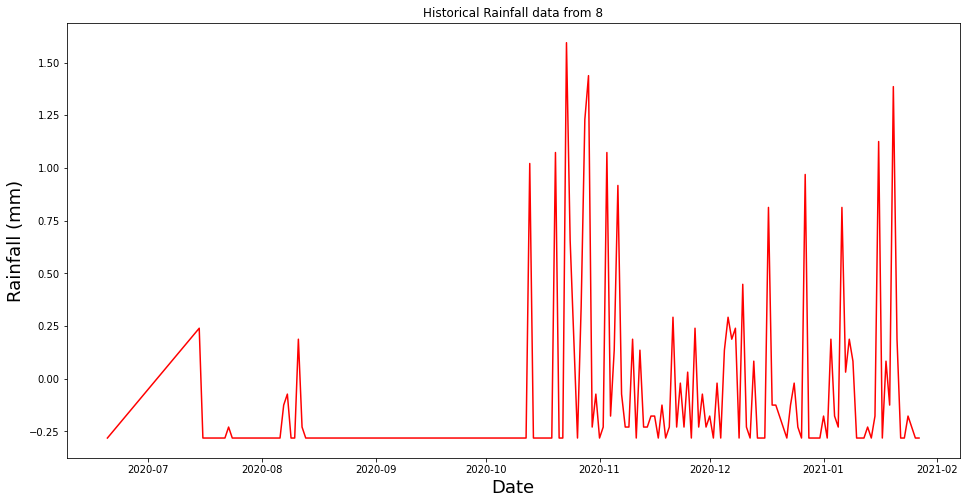

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


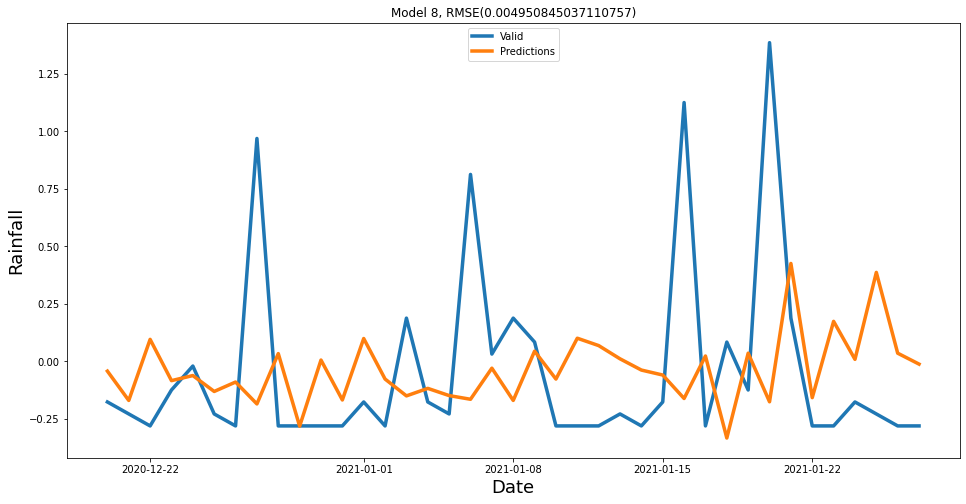

9


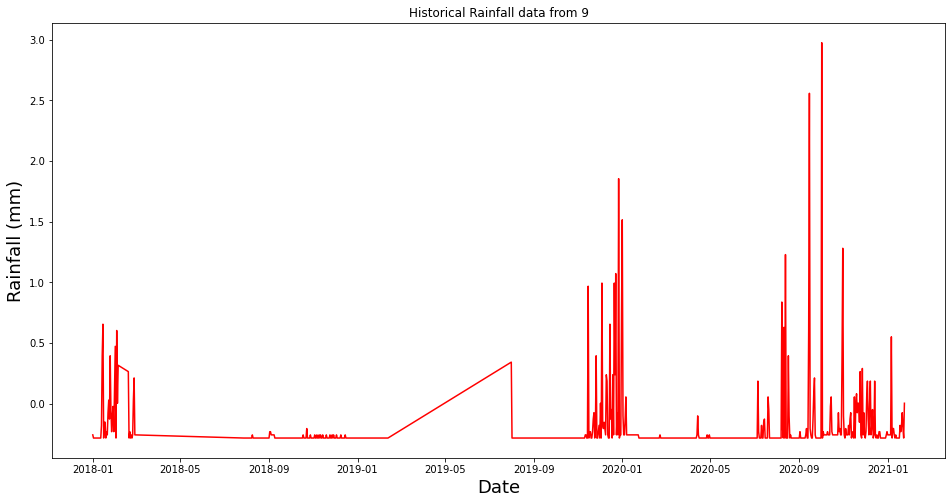

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


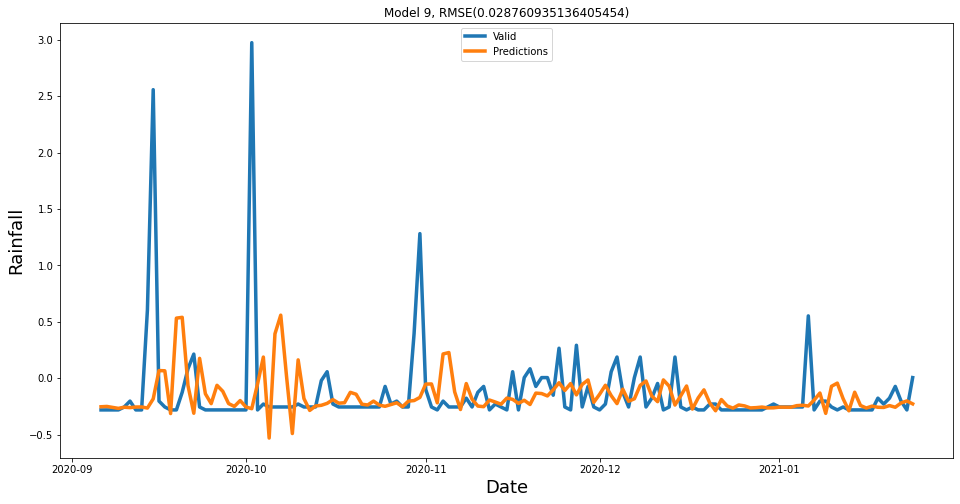

10


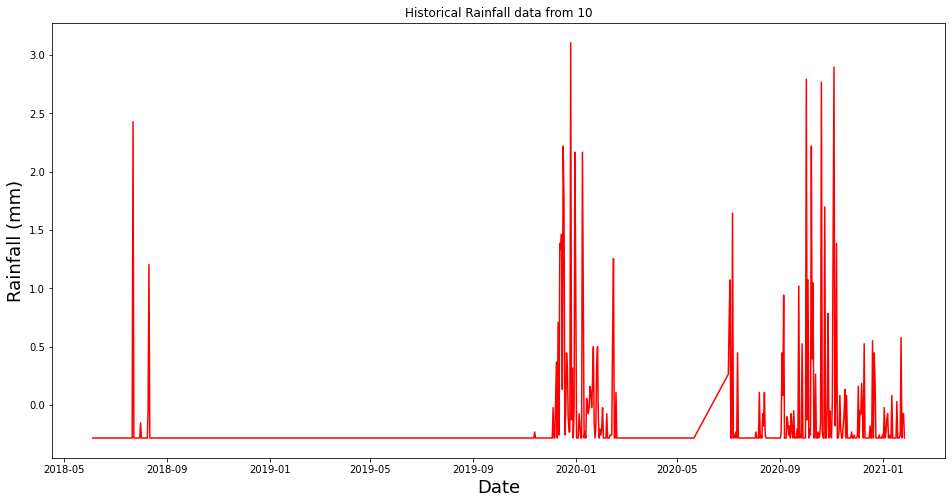

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


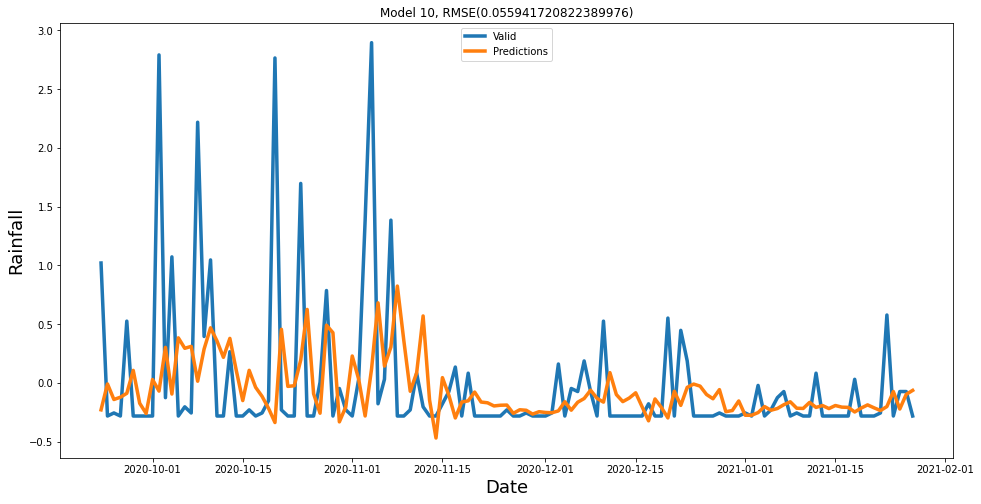

11


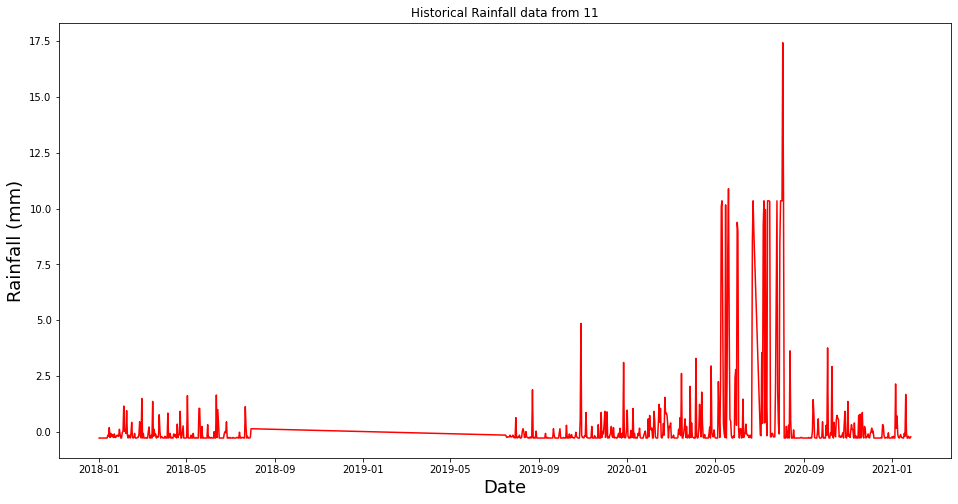

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


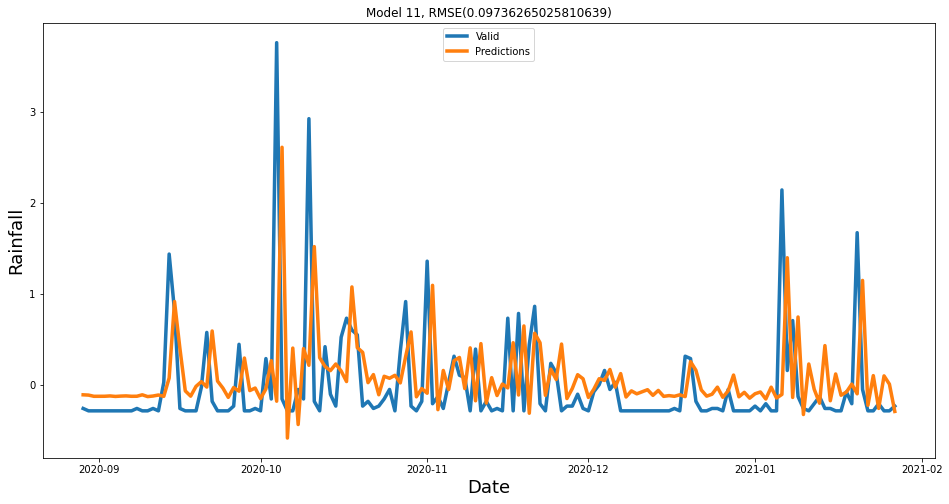

12


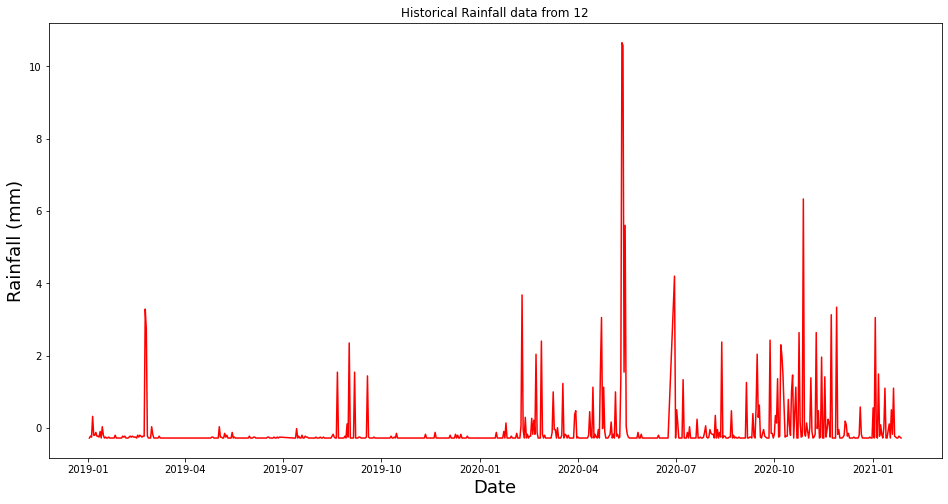

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


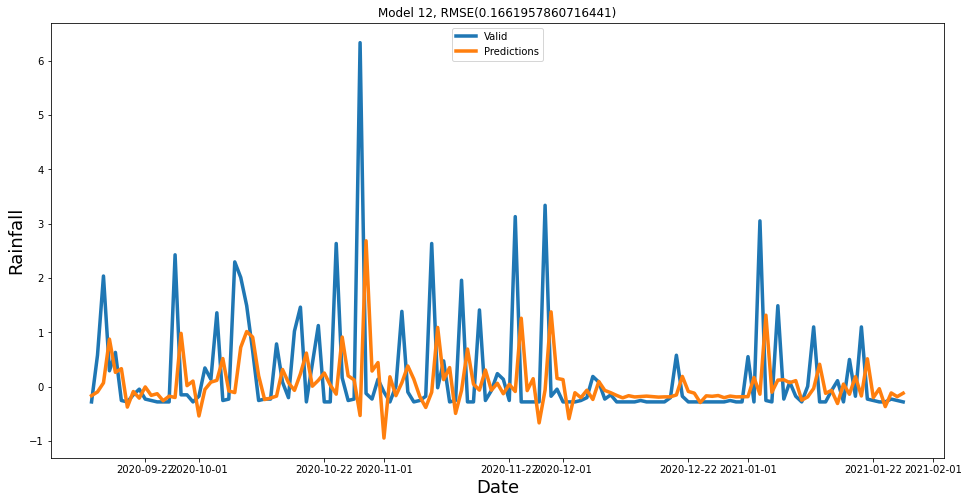

13


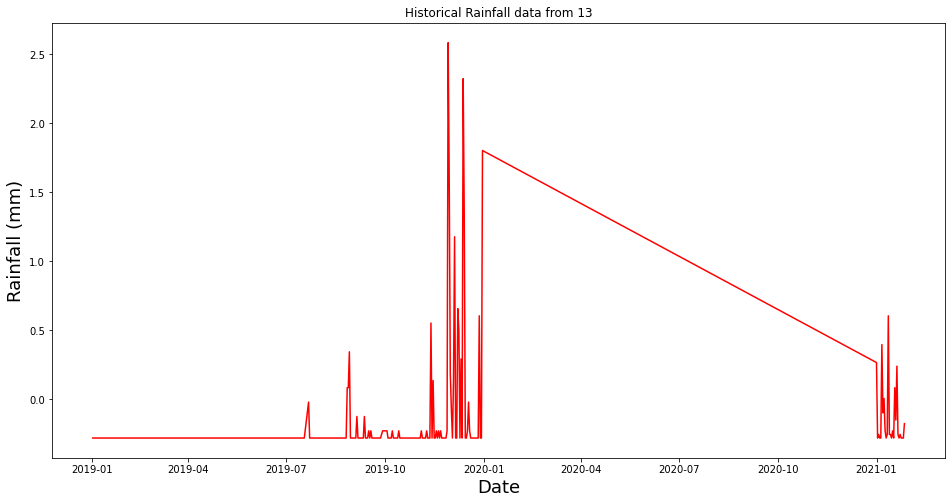

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


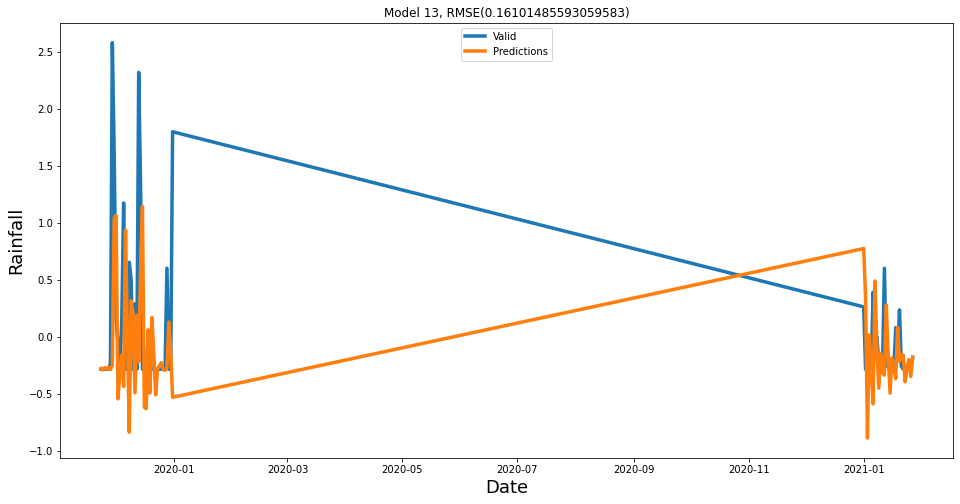

14


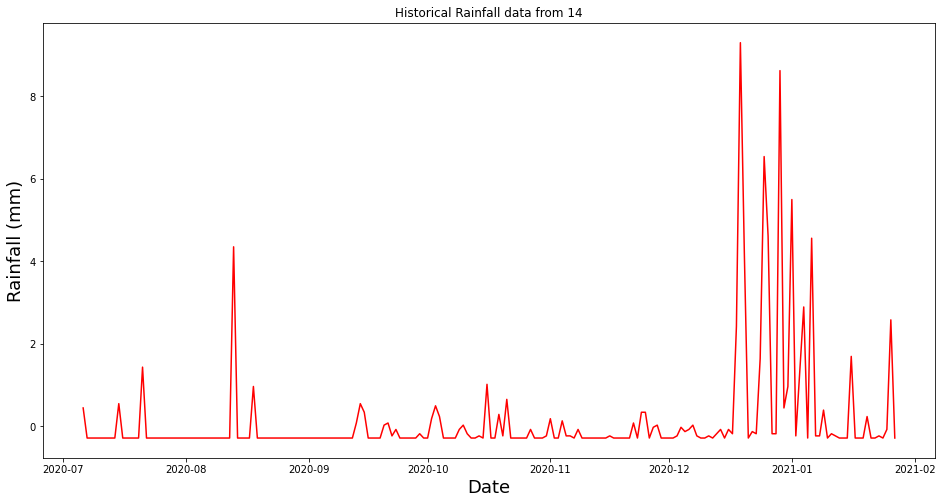

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


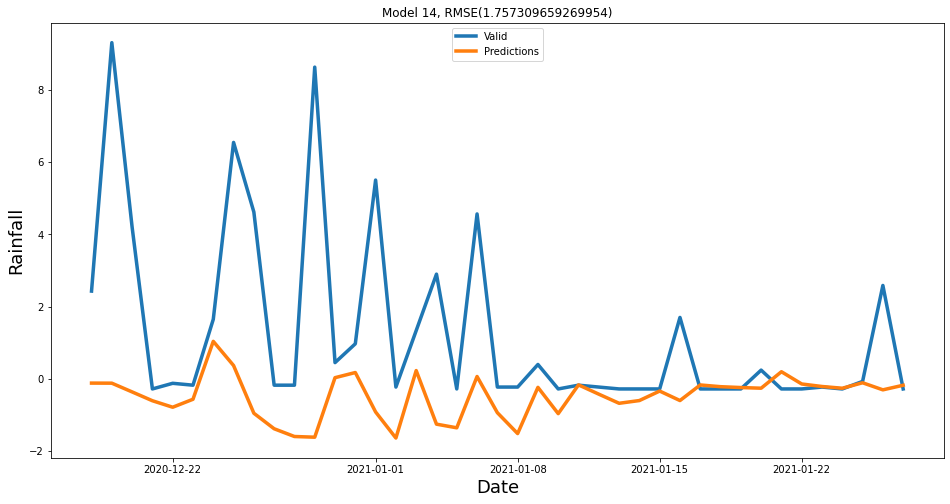

15


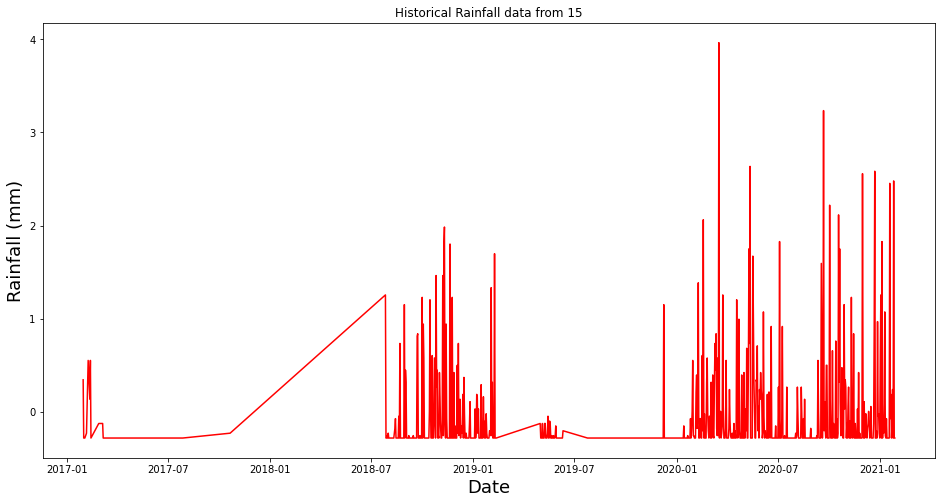

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


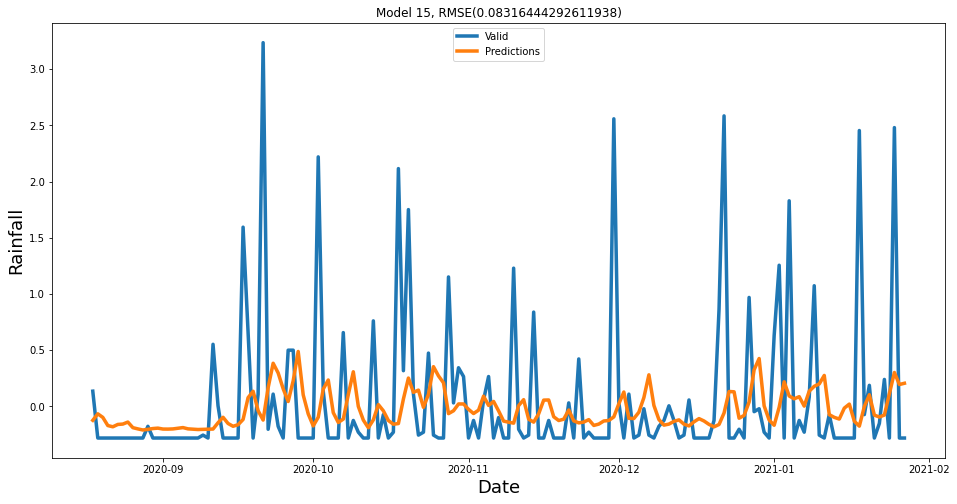

16


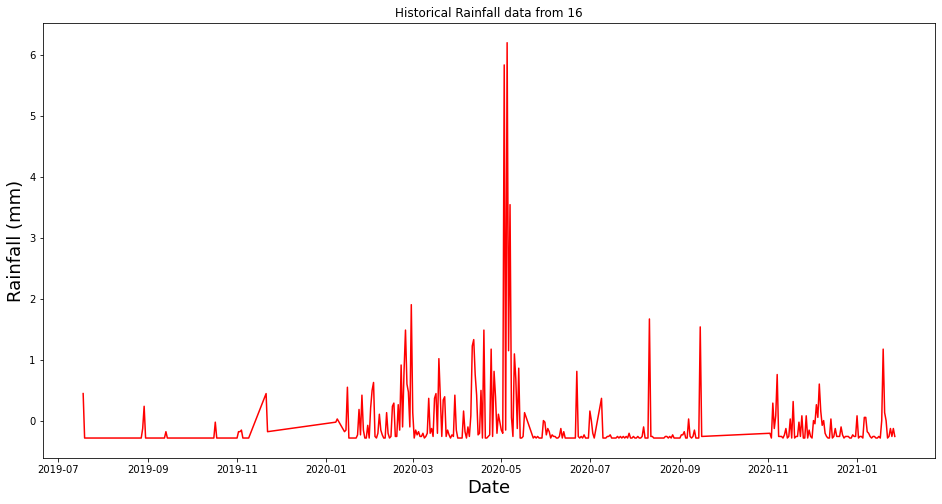

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


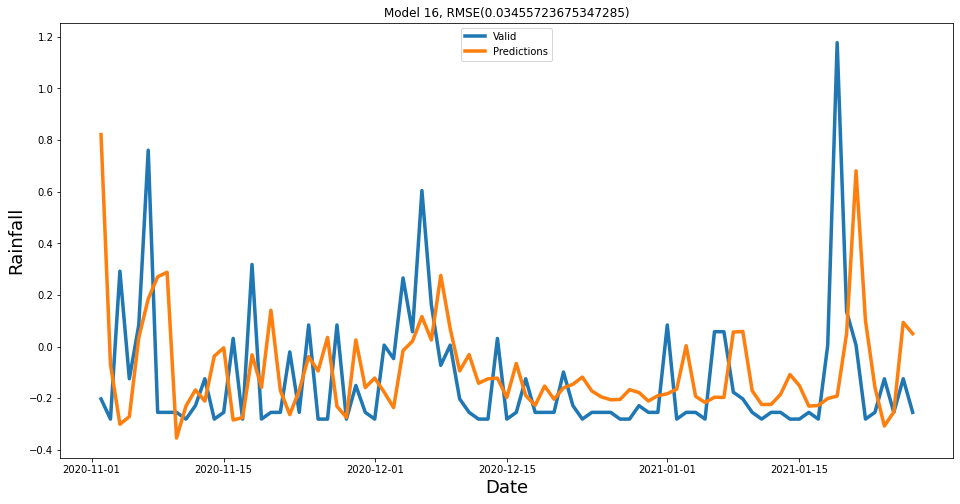

17


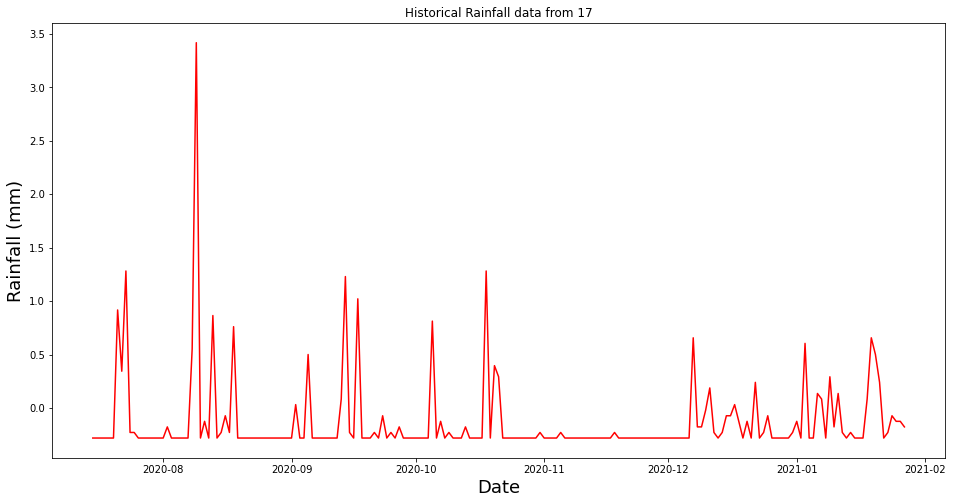

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


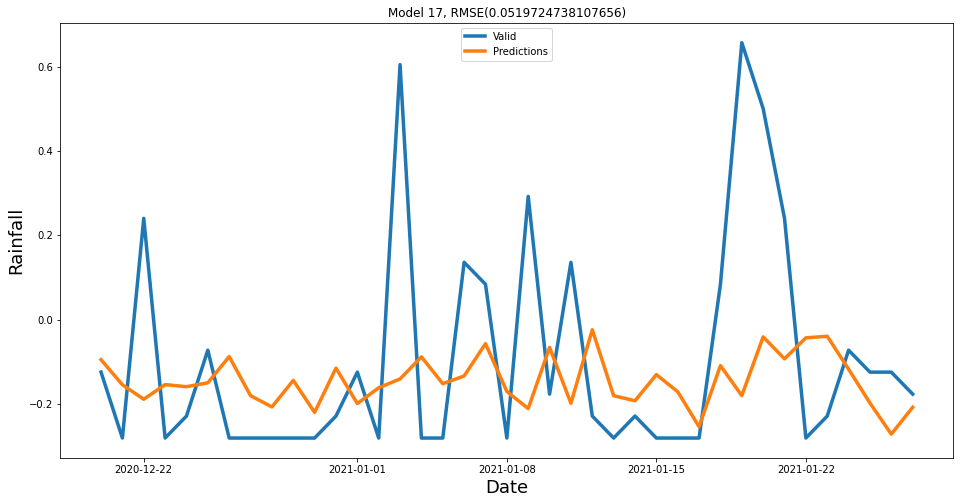

18


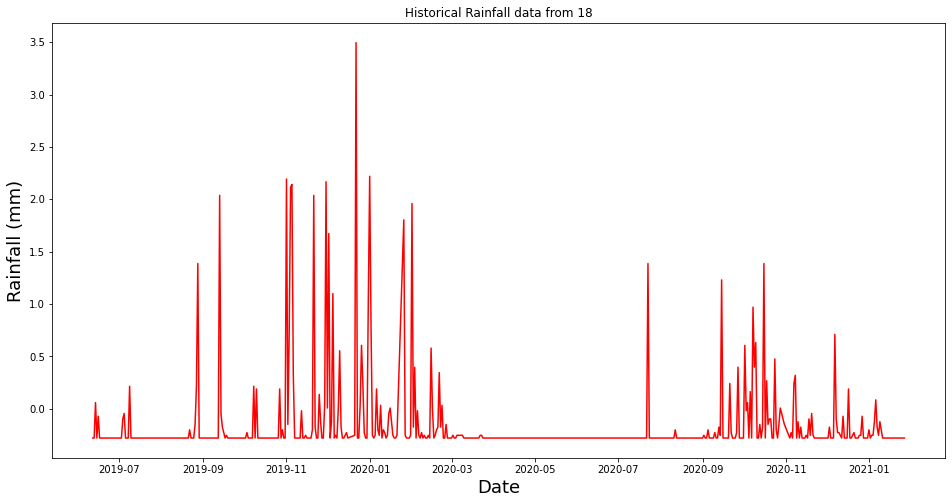

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


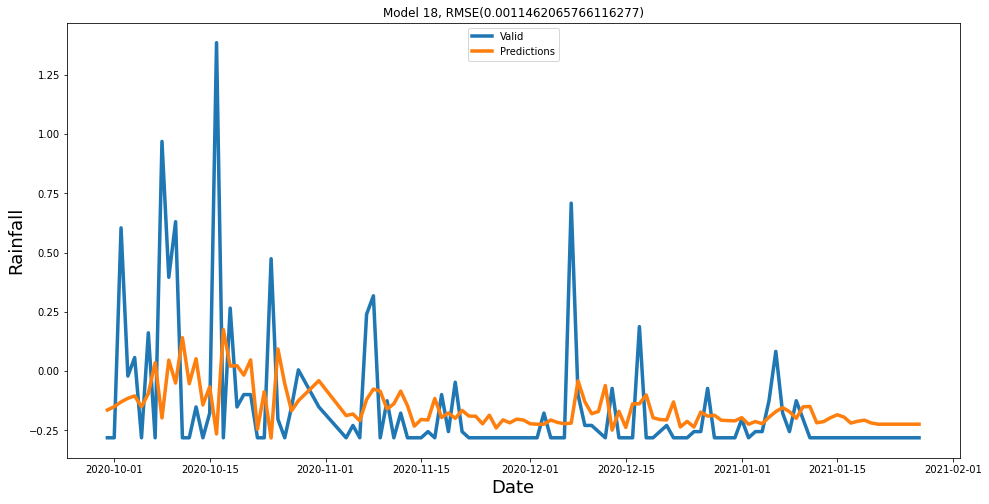

In [121]:
from sklearn.linear_model import LinearRegression
# Generate all regression model for each location
locations = json.load(open(banjir_mapping_location, "r"))["Location"].values()
window = 10 # can predict 10 days ahead

for location in locations:
  print(location)
  df = get_rainfall_by_location(location)

  # Plot data
  # plotting the data
  if ENABLE_OUTPUT: 
    plt.figure(figsize=(16, 8))
    plt.title('Historical Rainfall data from %s'%location)
    plt.plot(df["Date"],df['Rainfall'], color='red')
    plt.xlabel('Date', fontsize=18)
    plt.ylabel('Rainfall (mm)', fontsize=18)
    plt.show()

  # create new data frame with only 'Rainfall' column
  data = df[['Rainfall']]
  dataset = data.values # convert the data frame to numpy array
  trainning_data_len = np.math.ceil(len(dataset)*.8) # number of rows to train model

  # Create feature using sliding window
  train_data = dataset[0:trainning_data_len-window, :]

  # Split the data into x_train, y_train datasets
  x_train = []
  y_train = []
  for i in range(window, len(train_data)):
      x_train.append(train_data[i-window:i, 0])
      y_train.append(train_data[i, 0])

  x_train, y_train = np.array(x_train), np.array(y_train)
  clf = LinearRegression(n_jobs=-1, normalize=True)
  clf.fit(x_train, y_train)

  test_data = dataset[trainning_data_len-window:, :]
  # Create the data sets x_test and y_test
  x_test = []
  y_test = dataset[trainning_data_len:, :]
  for i in range(window, len(test_data)):
      x_test.append(test_data[i-window:i, 0])

  # convert the data  to numpy array
  x_test = np.array(x_test)

  forecast_set = clf.predict(x_test)

  # Accuracy (RMSE)
  rmse = np.sqrt(np.mean(forecast_set - y_test)**2)

  # plot the data
  train = data[:trainning_data_len]
  valid = data[trainning_data_len:]
  valid['Predictions'] = forecast_set

  # visualization of the data
  if ENABLE_OUTPUT: 
    plt.figure(figsize=(16,8))
    plt.title('Model %s, RMSE(%s)'%(location, rmse))
    plt.xlabel('Date', fontsize=18)
    plt.ylabel('Rainfall', fontsize=18)
    # plt.plot(train['Rainfall'], linewidth=3.5)
    plt.plot(df[trainning_data_len:]["Date"], valid[['Rainfall', 'Predictions']],  linewidth=3.5)
    plt.legend(['Valid','Predictions'], loc='upper center')
    plt.show()

  pickle.dump(clf, open("models/mreg-predict-banjir-%s.pkl"%location, "wb"))

### Classification Based On Place And Rainfall Size (Tensorflow)

In [122]:
def train_valid_test_split(data, ratio):
  """Split data based on the ratio
  Args:
    data (dataframe): ratio
    ratio (tuple): train:validation:test; example: (0.8, 0.1, 0.1)
  Returns:
    train_data, validation_data, test_data
  """
  ratio_train, ratio_valid, ratio_test = ratio
  assert ratio_valid == ratio_test
  assert np.sum(ratio) == 1
  training_data_len = np.math.ceil(len(data)*ratio_train)
  valid_data_len = np.math.ceil(len(data)*ratio_valid)
  train_data = data.values[0:training_data_len]
  valid_data = data.values[training_data_len:training_data_len+valid_data_len]
  test_data = data.values[training_data_len+valid_data_len:]
  return train_data, valid_data, test_data

def generate_forecast_feature(data, window=10):
    """Generate Windowing feature for forecasting
    Args:
      data (np.array): data to forecast
      window (int): window size; default 10
    Returns:
      X (np.array): features
      y (np.array): labels
    """
    X = []
    y = []
    for i in range(window, len(data)):
        X.append(data[i-window:i, 0])
        y.append(data[i, 0])
    #### convert to numpy array
    X, y = np.array(X), np.array(y)
    #### reshape to 3d (expected by keras)
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))
    return X, y

In [123]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

locations = json.load(open(banjir_mapping_location, "r"))["Location"].values()
transformer = Transformer()

## Need to get 80:10:10 for all locations (same)
train_data_all = []
valid_data_all = []
test_data_all = []

for location in locations:
  df = get_rainfall_by_location(location)
  # split data
  train_data, valid_data, test_data = train_valid_test_split(df[["Location", "Rainfall", "Banjir"]], (0.8, 0.1, 0.1))

  train_data_all.append(train_data)
  valid_data_all.append(valid_data)
  test_data_all.append(test_data)

train_data = np.vstack(train_data_all)
valid_data = np.vstack(valid_data_all)
test_data = np.vstack(test_data_all)

## build train, valid and test data
def reshape_to_3d(X):
  """Reshape 2d np array X to 3d np array X
  Args:
    X (np.array): 2d np array
  Returns:
    X (np.array): 3d np array
  """
  X = np.reshape(X, (X.shape[0], X.shape[1], 1))
  return X
  
x_train, y_train = train_data[:, :2], train_data[:, 2]
x_train = reshape_to_3d(x_train)

x_valid, y_valid = valid_data[:, :2], valid_data[:, 2]
x_valid = reshape_to_3d(x_valid)

x_test, y_test = test_data[:, :2], test_data[:, 2]
x_test = reshape_to_3d(x_test)

Epoch 1/1000
208/208 [==============================] - 2s 6ms/step - loss: 0.3163 - accuracy: 0.8743 - val_loss: 0.3491 - val_accuracy: 0.8469
Epoch 2/1000
208/208 [==============================] - 1s 4ms/step - loss: 0.2449 - accuracy: 0.9090 - val_loss: 0.3199 - val_accuracy: 0.8684
Epoch 3/1000
208/208 [==============================] - 1s 4ms/step - loss: 0.2316 - accuracy: 0.9122 - val_loss: 0.3306 - val_accuracy: 0.8505
Epoch 4/1000
 45/208 [=====>........................] - ETA: 0s - loss: 0.2548 - accuracy: 0.8918

/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


208/208 [==============================] - 1s 4ms/step - loss: 0.2358 - accuracy: 0.9041 - val_loss: 0.3265 - val_accuracy: 0.8606
Epoch 5/1000
208/208 [==============================] - 1s 4ms/step - loss: 0.2246 - accuracy: 0.9148 - val_loss: 0.3152 - val_accuracy: 0.8469
Epoch 6/1000
208/208 [==============================] - 1s 4ms/step - loss: 0.2248 - accuracy: 0.9149 - val_loss: 0.3306 - val_accuracy: 0.8606
Epoch 7/1000
208/208 [==============================] - 1s 4ms/step - loss: 0.2188 - accuracy: 0.9158 - val_loss: 0.3147 - val_accuracy: 0.8606
Epoch 8/1000
208/208 [==============================] - 1s 4ms/step - loss: 0.2304 - accuracy: 0.9030 - val_loss: 0.3175 - val_accuracy: 0.8463
Epoch 9/1000
208/208 [==============================] - 1s 4ms/step - loss: 0.2218 - accuracy: 0.9122 - val_loss: 0.3091 - val_accuracy: 0.8606
Epoch 10/1000
208/208 [==============================] - 1s 4ms/step - loss: 0.2175 - accuracy: 0.9137 - val_loss: 0.3205 - val_accuracy: 0.8565
Epoc

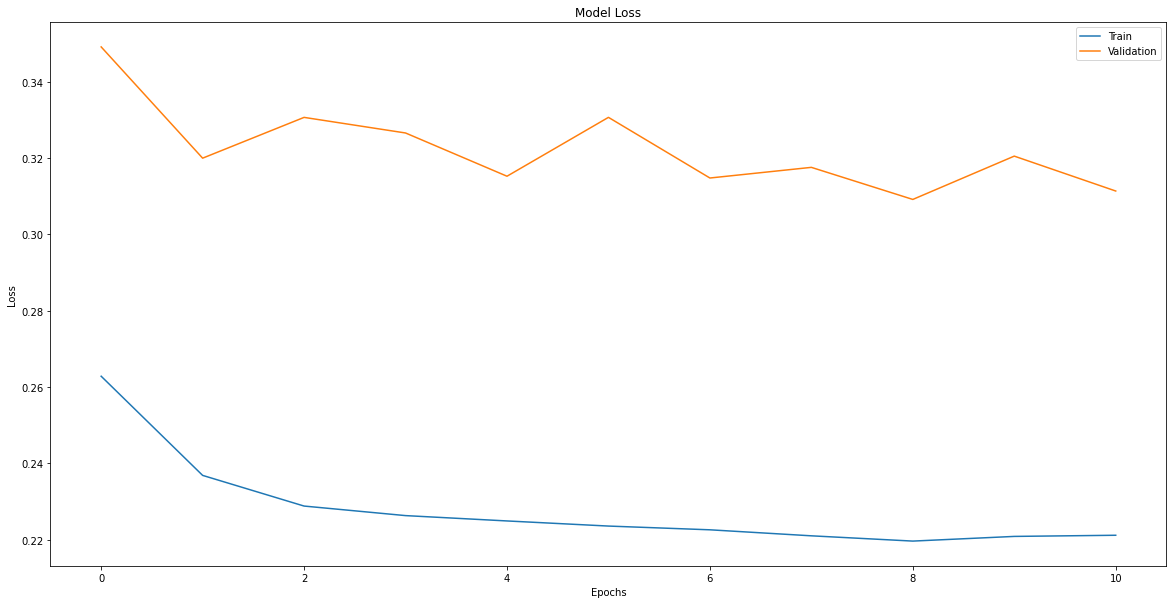

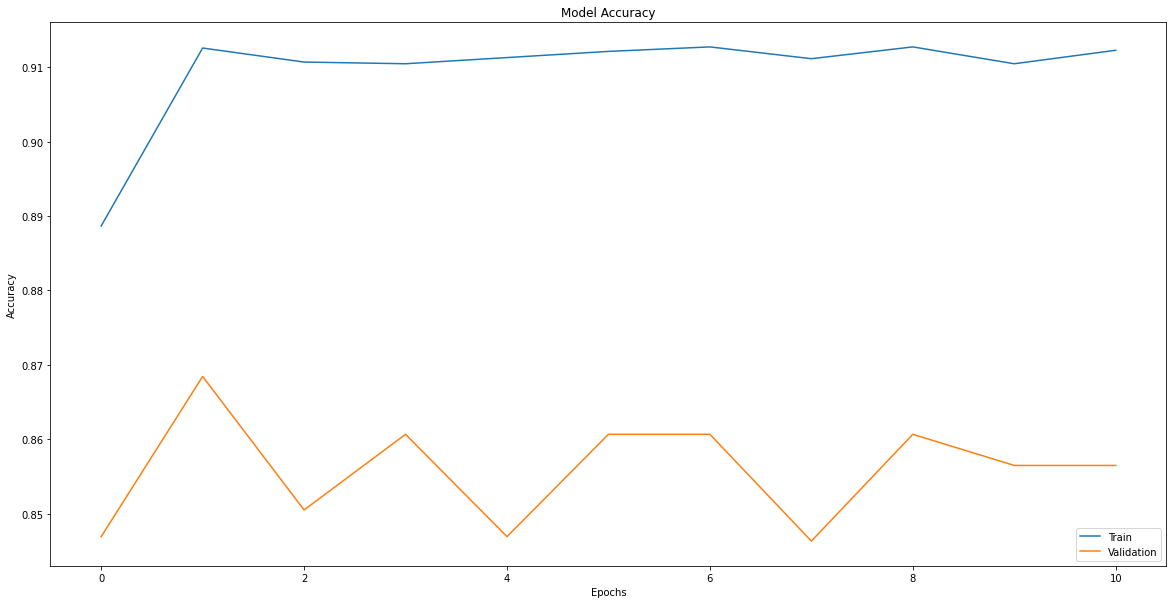

RMSE 0.028366973160147826


In [124]:
import os
if not os.path.exists('models'): os.makedirs('models/arch') # model saving location

# Callback model
class Callback(tf.keras.callbacks.Callback):
  def on_train_begin(self, logs={}):
        self.history = {'loss':[], 'val_loss':[], 'avg_pass_tresshold': 5}
  def on_epoch_end(self, epoch, logs={}):
    # Stop to prevent overfit but not too early
    if epoch > 1:
        val_avg = np.average(self.history["val_loss"])
        if logs.get('val_loss') > val_avg and self.history["avg_pass_tresshold"] <= 0:
          print("Validation loss not improving, stopping!")
          self.model.stop_training = True
        elif logs.get('val_loss') < val_avg:
          self.history["avg_pass_tresshold"] += 1
        else:
          self.history["avg_pass_tresshold"] -= 1
          
    if logs.get("val_loss") >= logs.get("loss") and epoch >= 10 and self.history["avg_pass_tresshold"] <= 0:
      print("\nval_loss >= loss")
      self.model.stop_training = True
early_stop_callback = Callback()

# Create Model
model = Sequential()
model.add(Dense(512, input_shape=(x_train.shape[1], 1), activation='relu'))
model.add(Dense(512, activation="relu"))
model.add(Dropout(0.1))
model.add(Dense(256, activation="relu"))
model.add(Dense(1, activation='sigmoid'))

# Compile model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=["accuracy"])

# Train the model
logs = model.fit(
    x_train, 
    y_train,
    epochs=1000,
    callbacks=[early_stop_callback],
    validation_data=(x_valid, y_valid),
)

# Show Model Performance
plt.plot(logs.history["loss"])
plt.plot(logs.history["val_loss"])
plt.title("Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Train", "Validation"], loc="upper right")
plt.show()

plt.plot(logs.history["accuracy"])
plt.plot(logs.history["val_accuracy"])
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Train", "Validation"], loc="lower right")
plt.show()


# Try to predict
y_predict = model.predict(x_test)

# Accuracy (RMSE)
rmse = np.sqrt(np.mean(y_predict - y_test)**2)
print("RMSE", rmse)
model.save("models/kerasbinary-predict-banjir.h5")

### Rainfall Forecasting Model (Tensorflow)

(703, 10, 1) (703,)
(80, 10, 1) (80,)
(78, 10, 1) (78,)


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)



val_loss >= loss


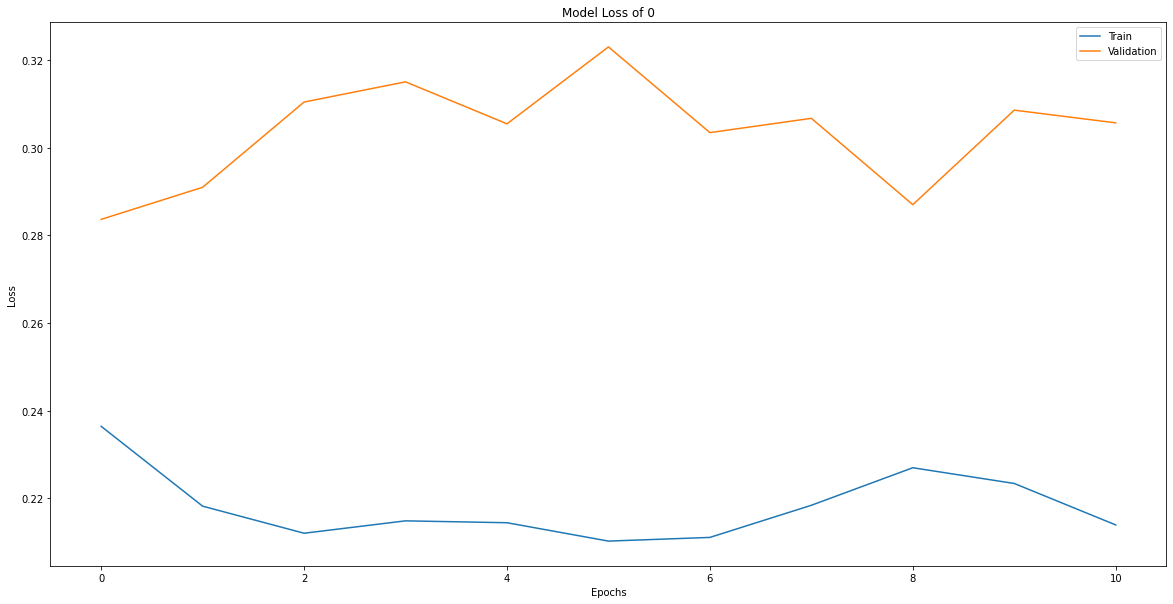

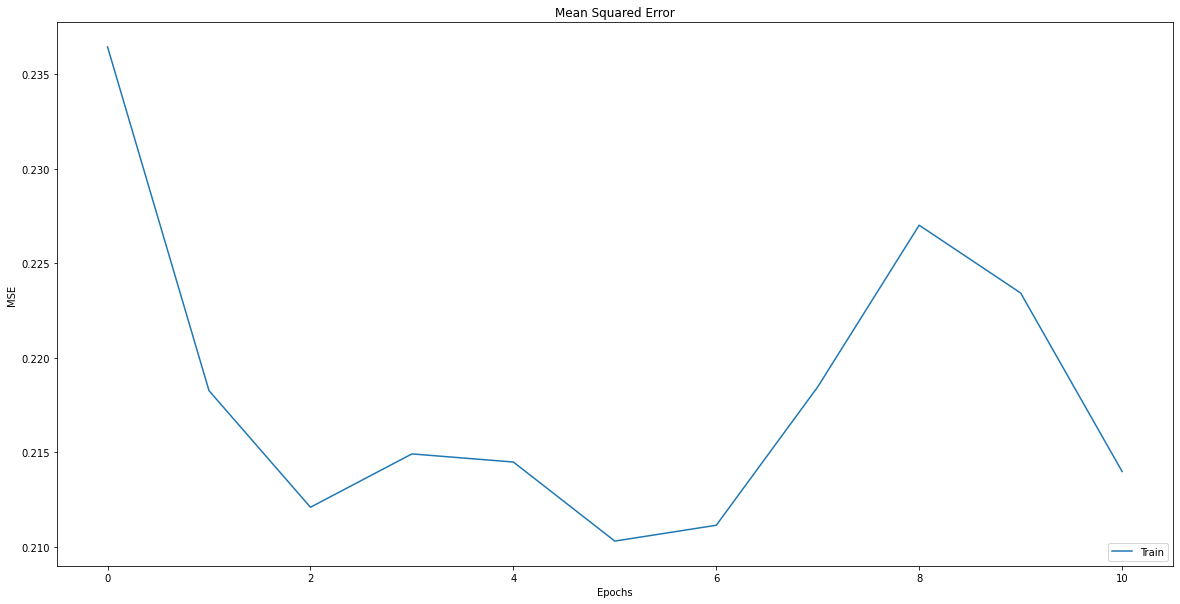

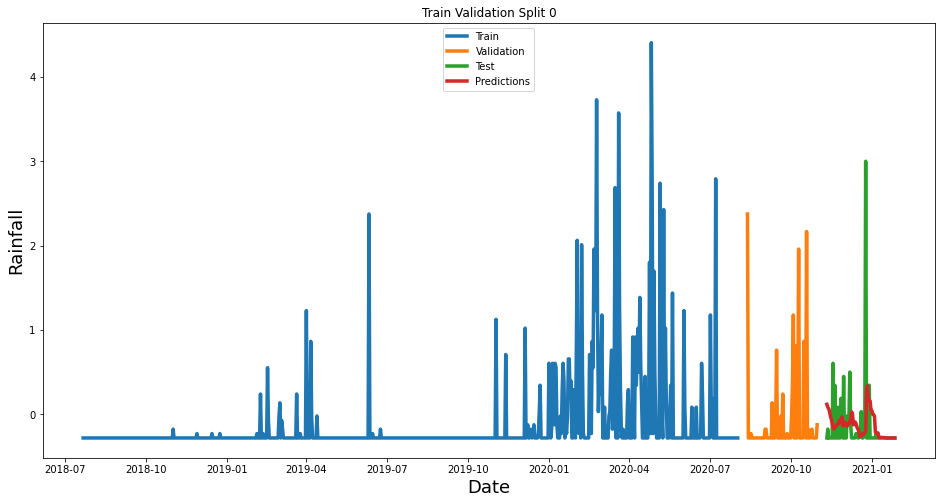

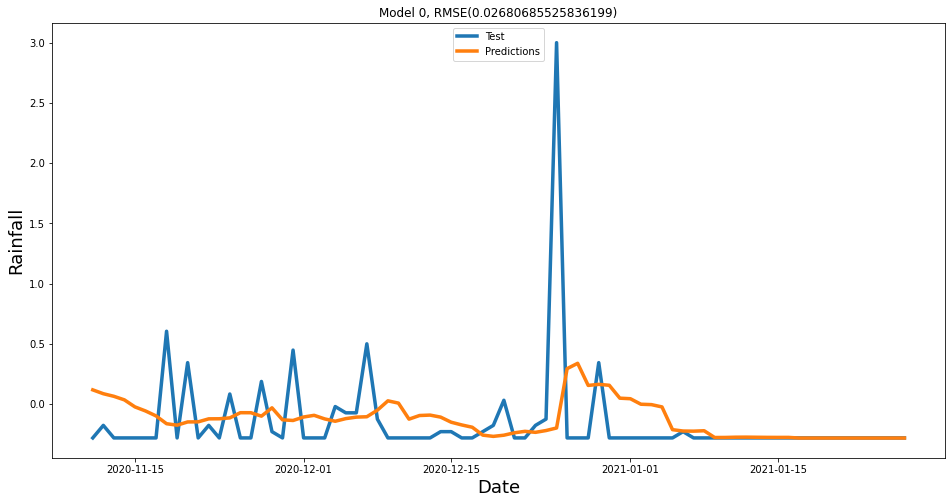

(168, 10, 1) (168,)
(13, 10, 1) (13,)
(11, 10, 1) (11,)


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


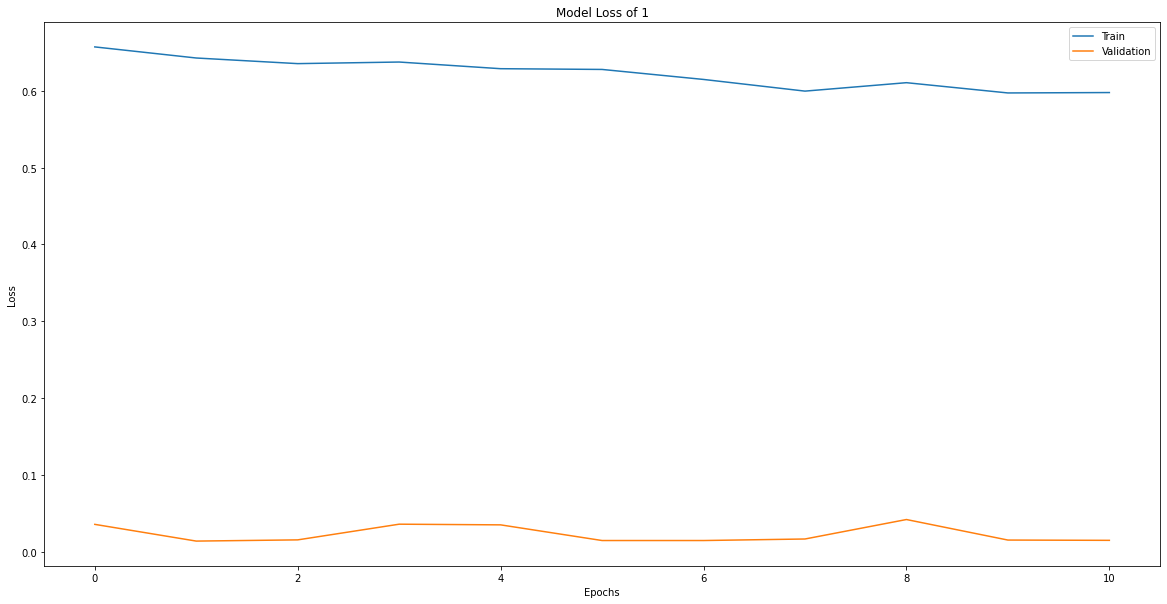

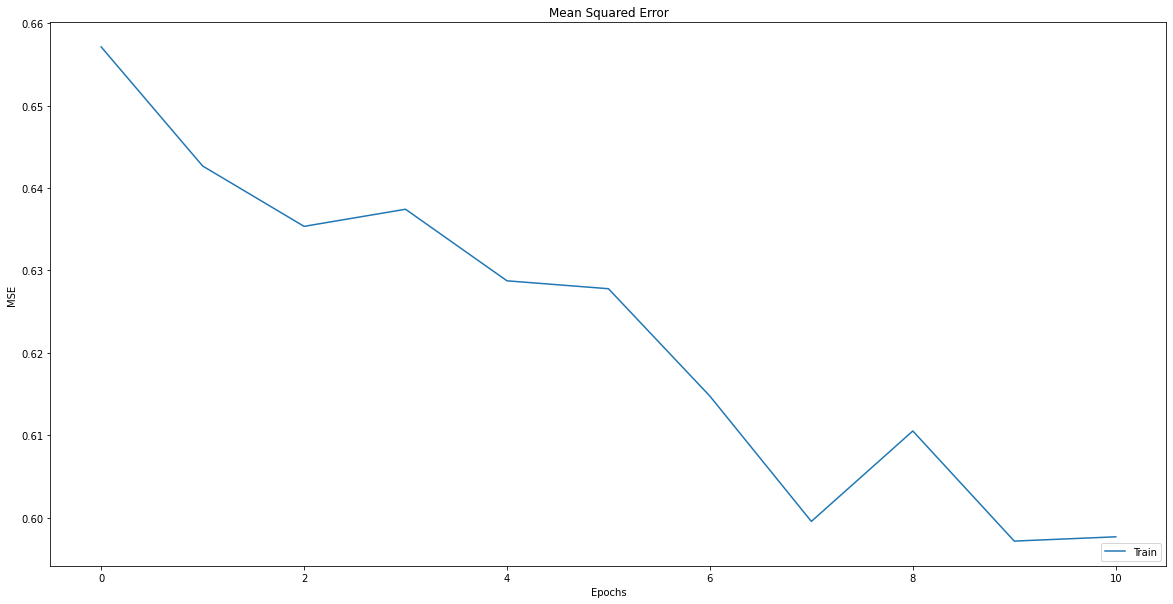

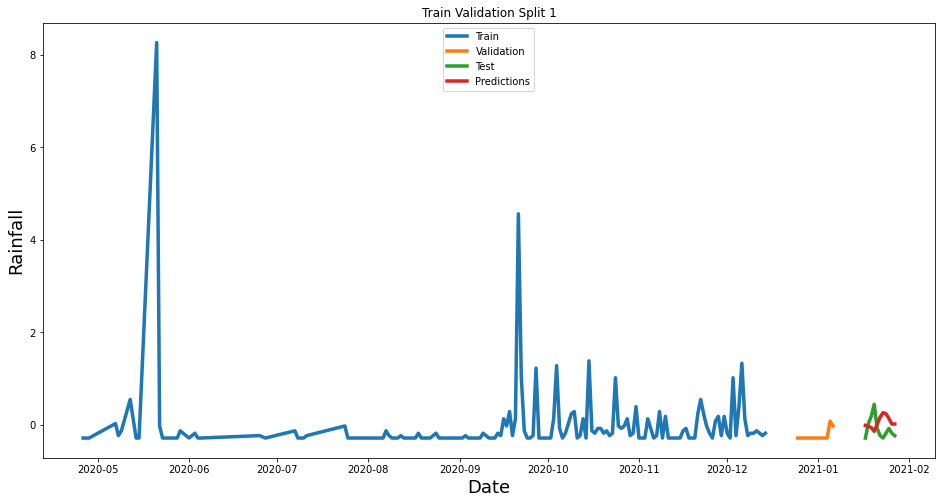

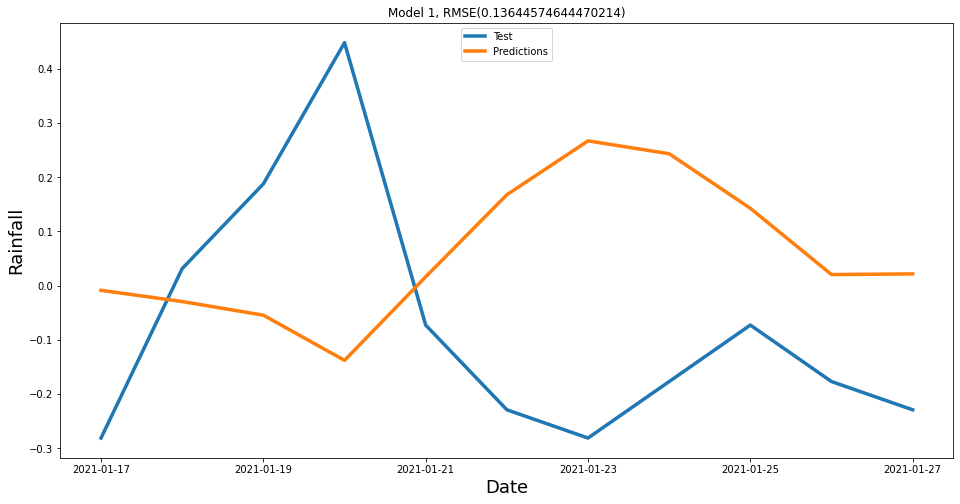

(626, 10, 1) (626,)
(70, 10, 1) (70,)
(69, 10, 1) (69,)


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


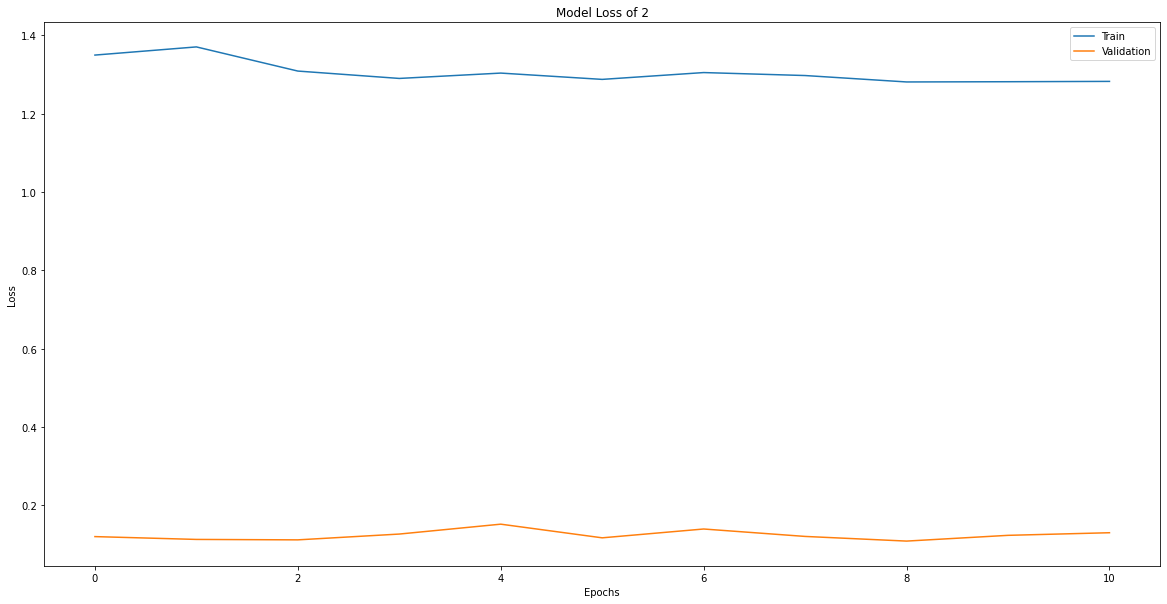

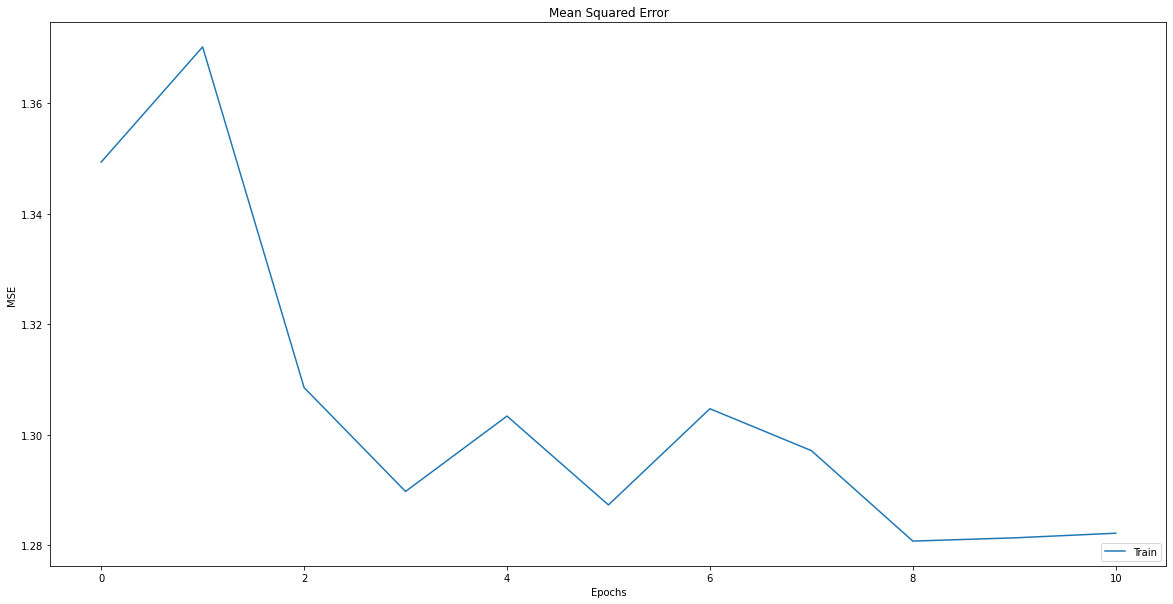

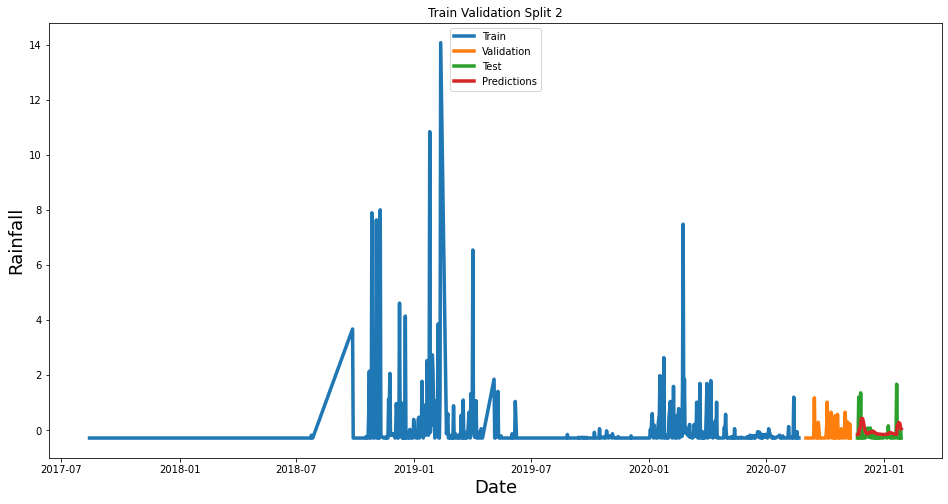

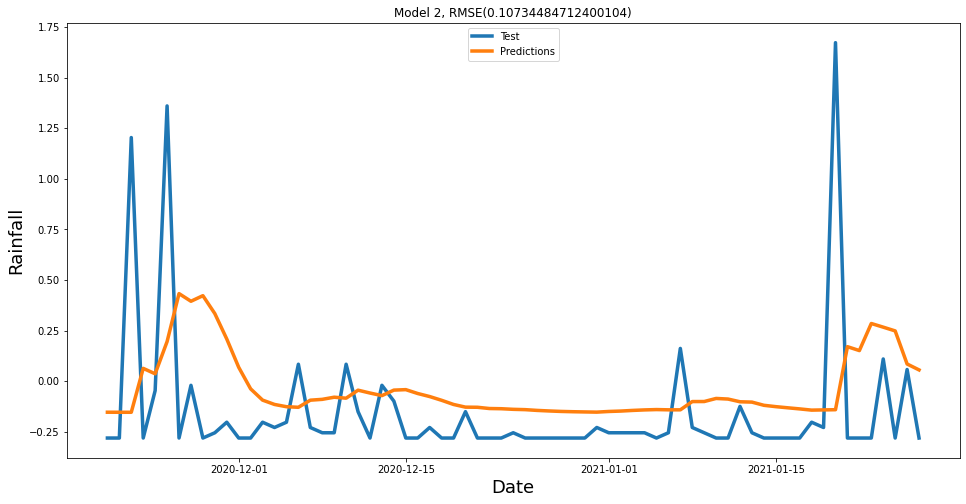

(98, 10, 1) (98,)
(4, 10, 1) (4,)
(3, 10, 1) (3,)


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)



val_loss >= loss


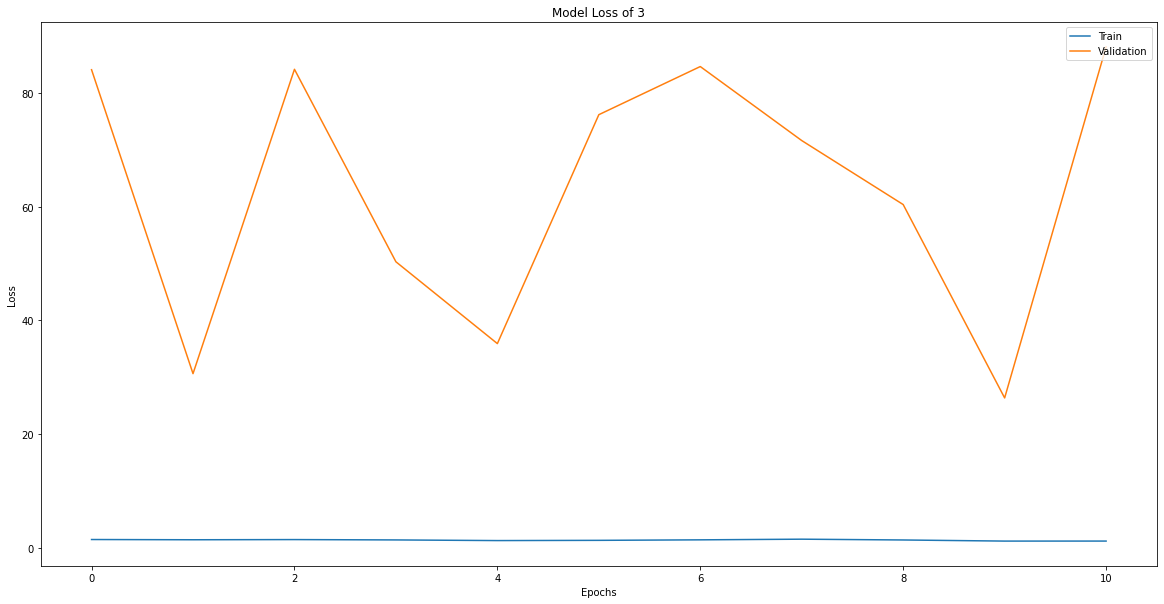

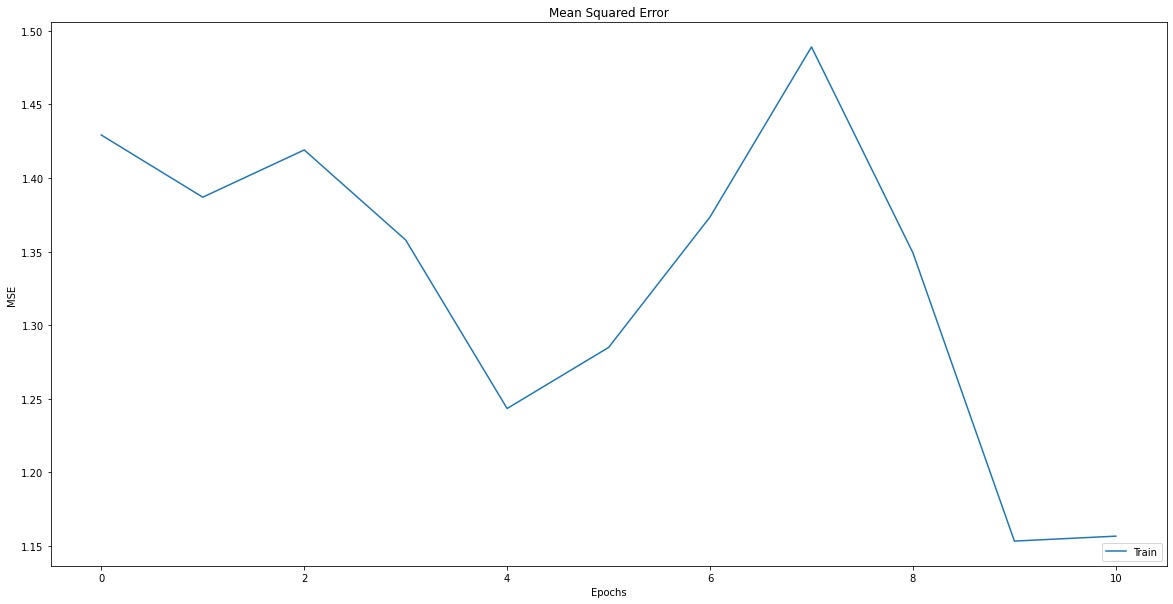

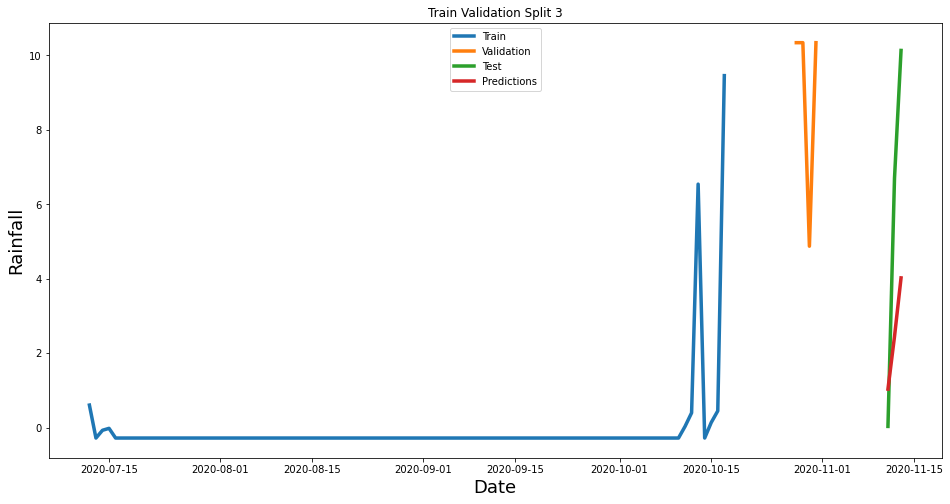

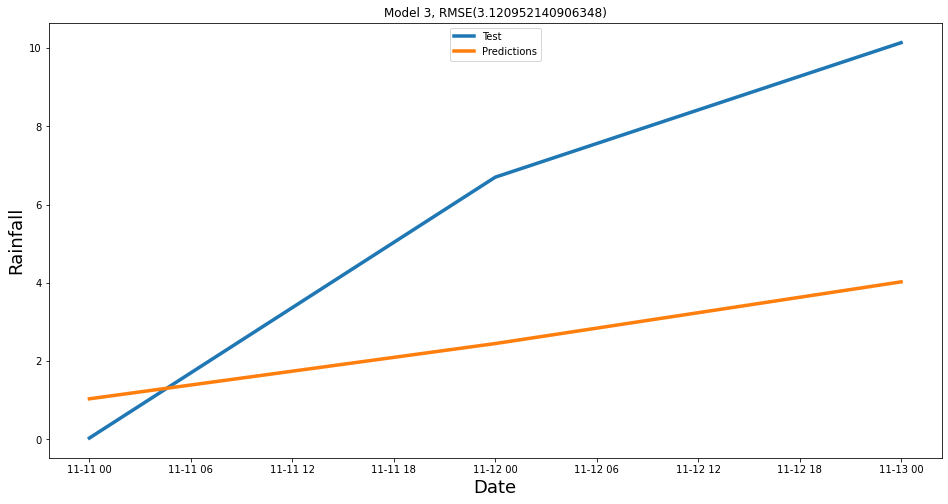

(126, 10, 1) (126,)
(7, 10, 1) (7,)
(6, 10, 1) (6,)


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


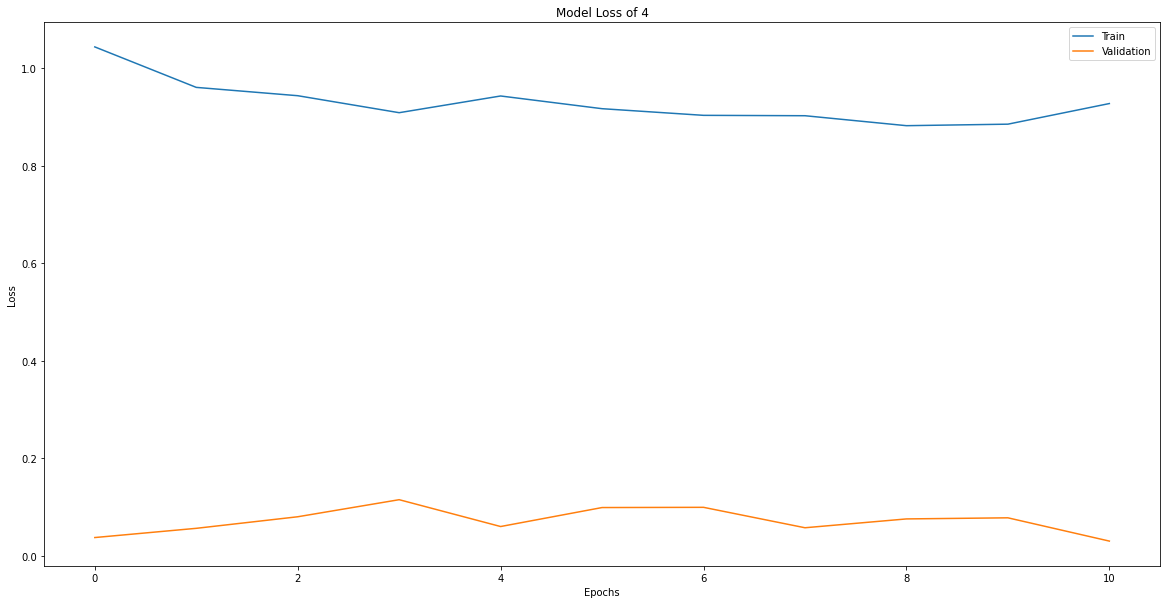

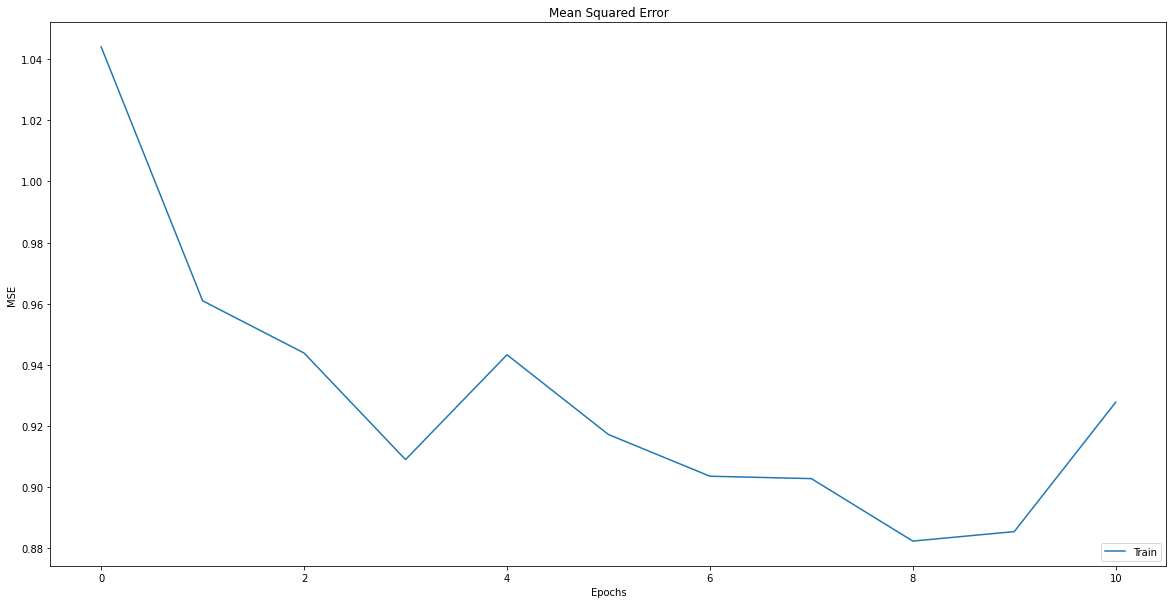

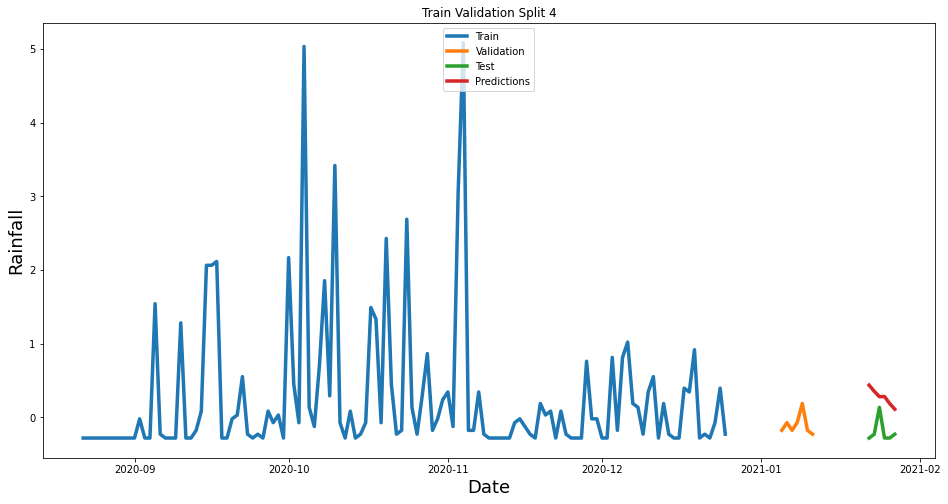

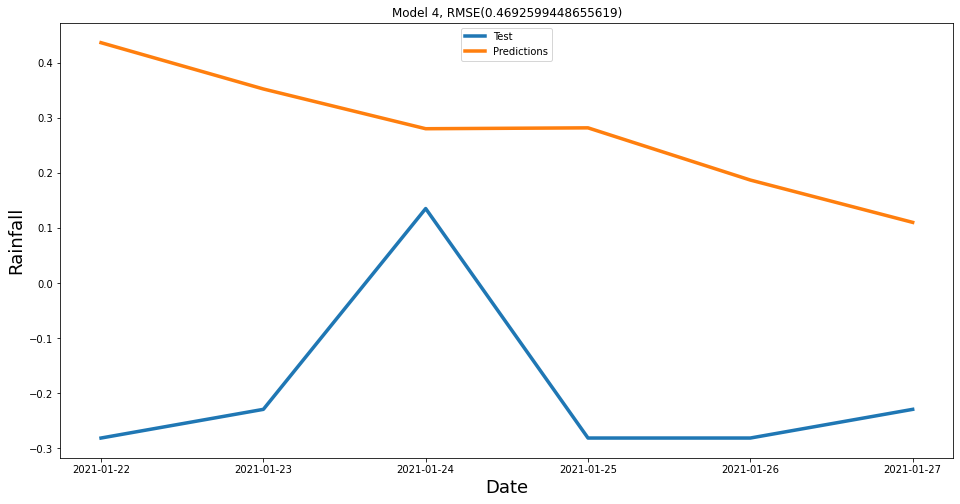

(238, 10, 1) (238,)
(21, 10, 1) (21,)
(21, 10, 1) (21,)


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


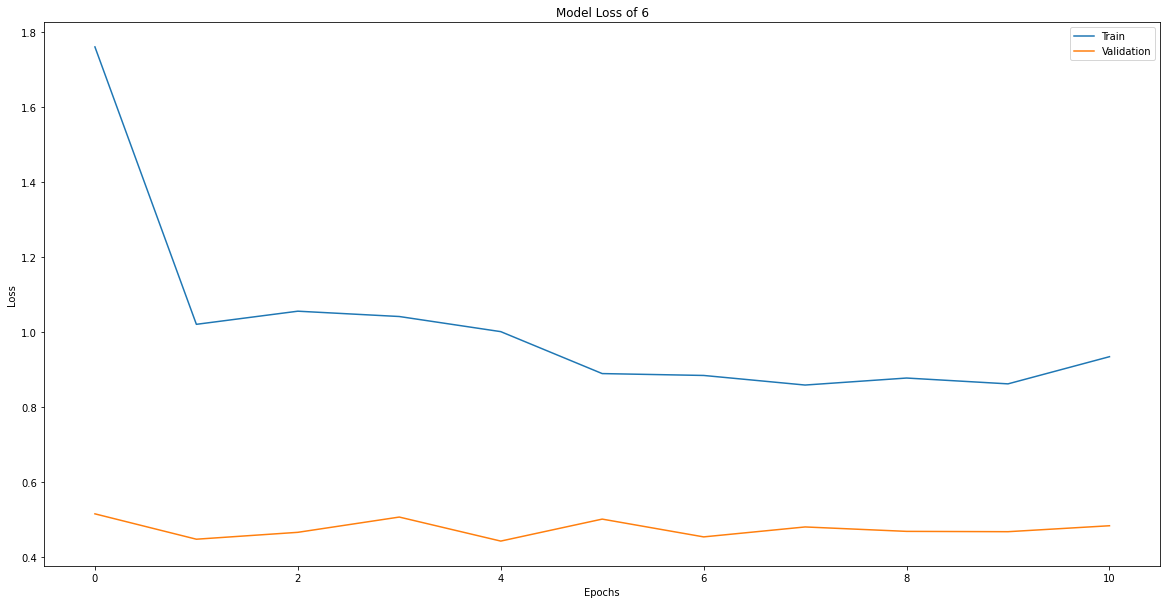

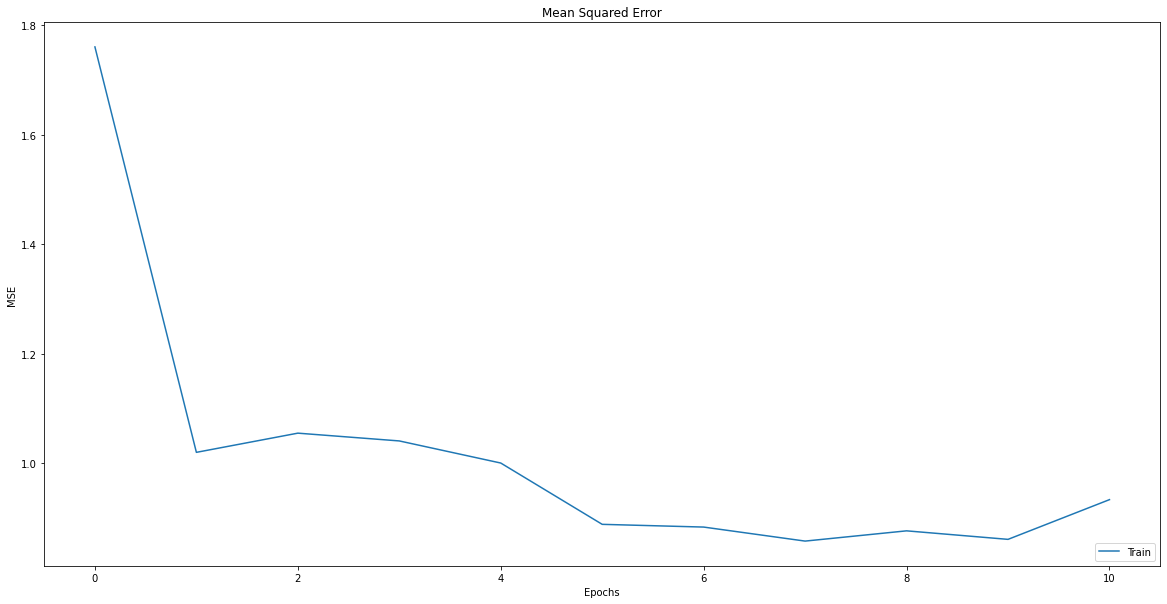

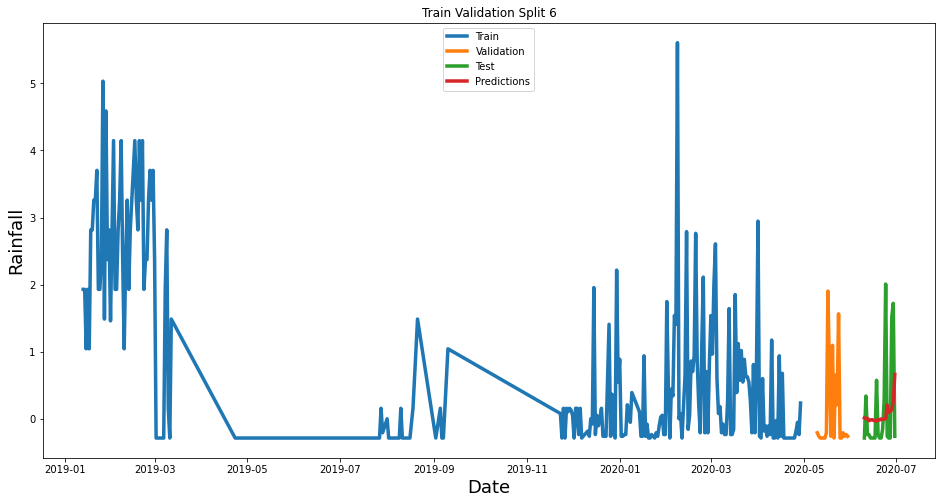

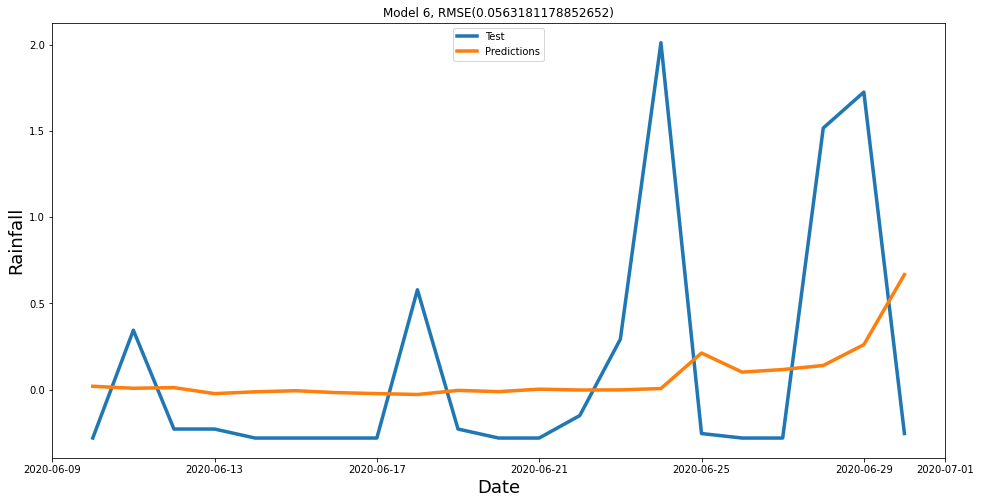

(120, 10, 1) (120,)
(7, 10, 1) (7,)
(5, 10, 1) (5,)


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


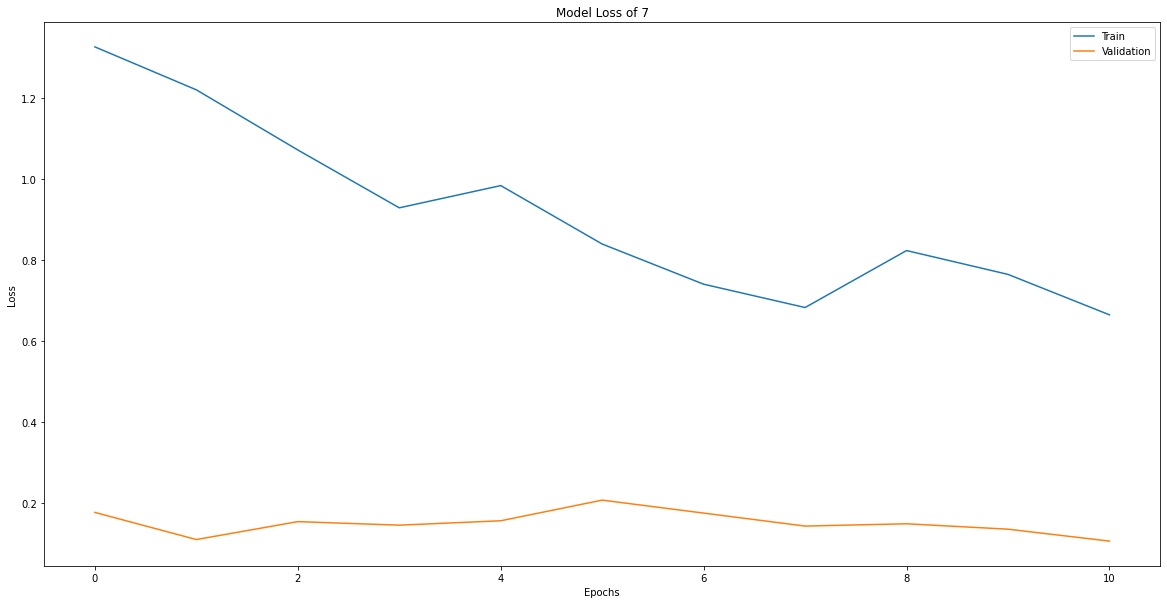

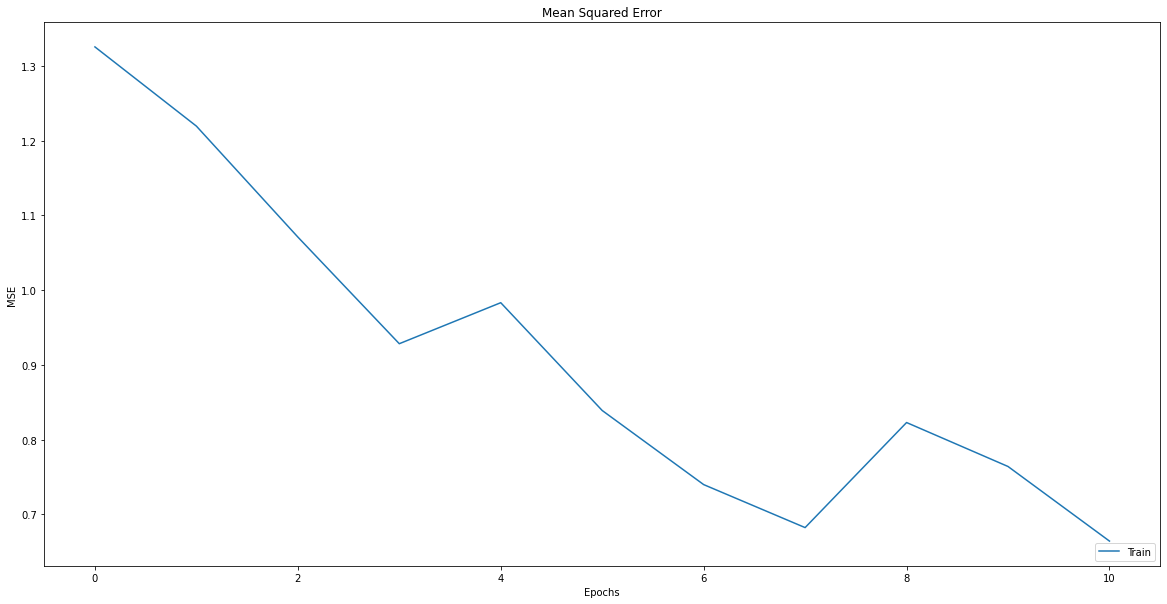

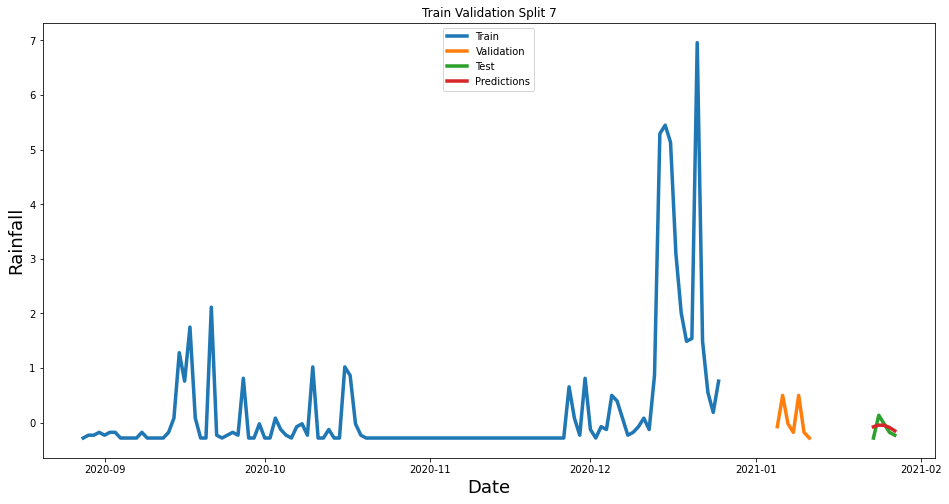

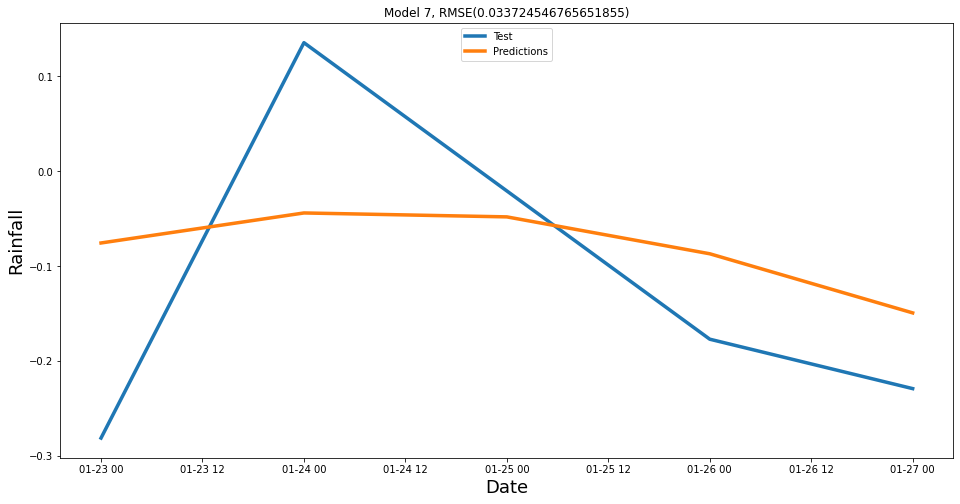

(149, 10, 1) (149,)
(10, 10, 1) (10,)
(9, 10, 1) (9,)


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)



val_loss >= loss


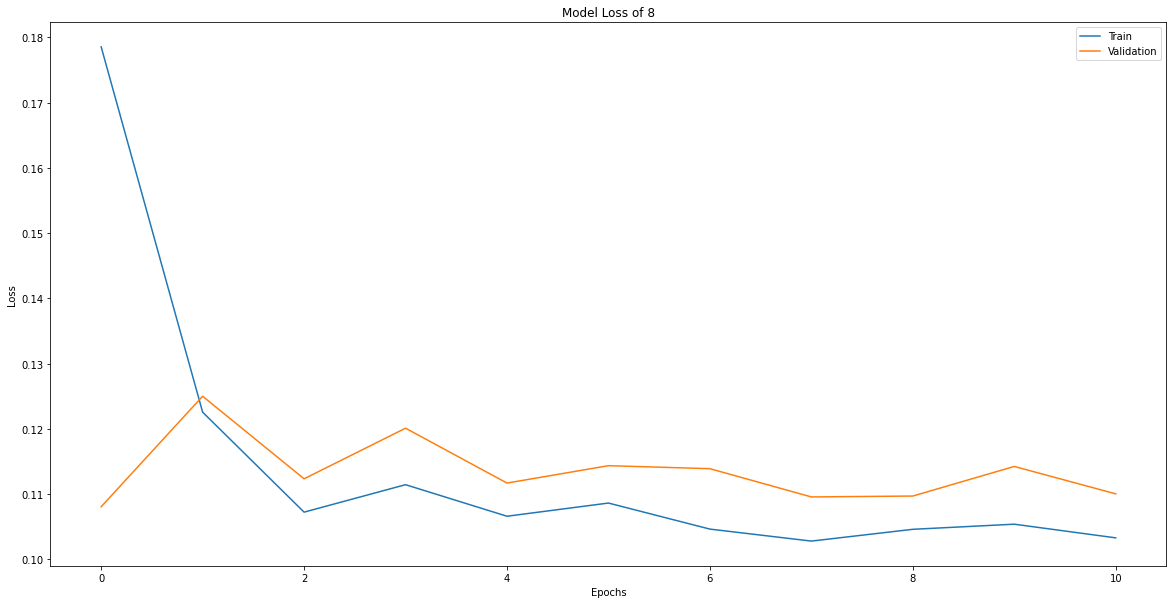

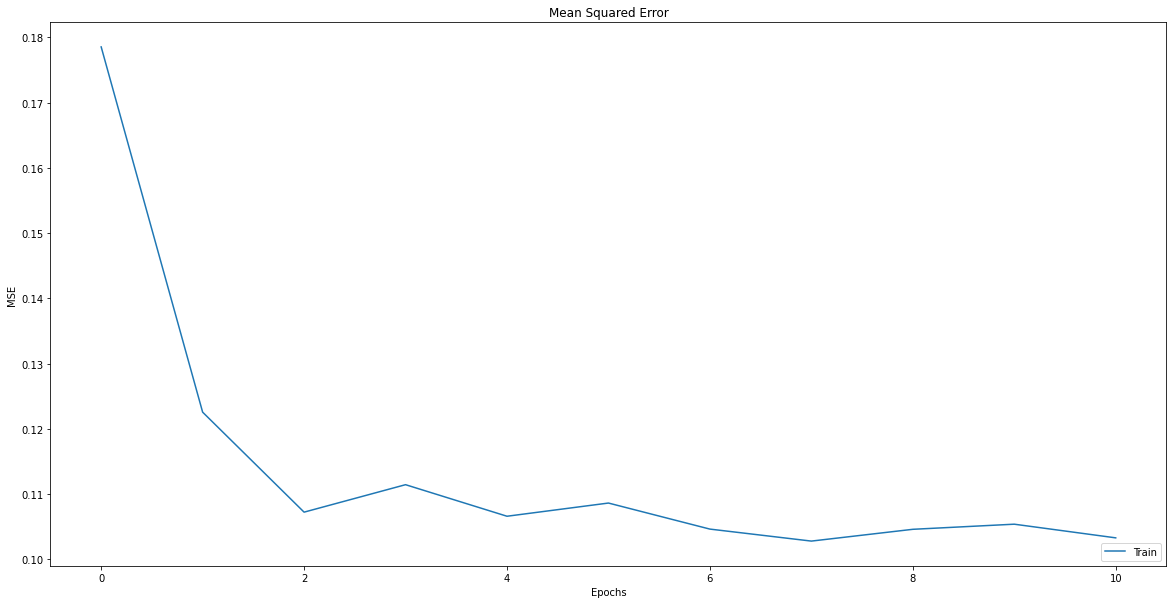

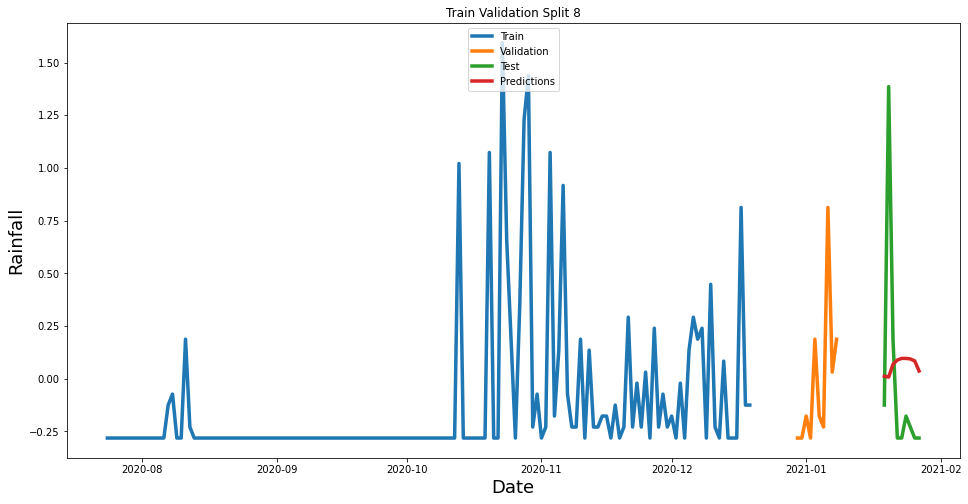

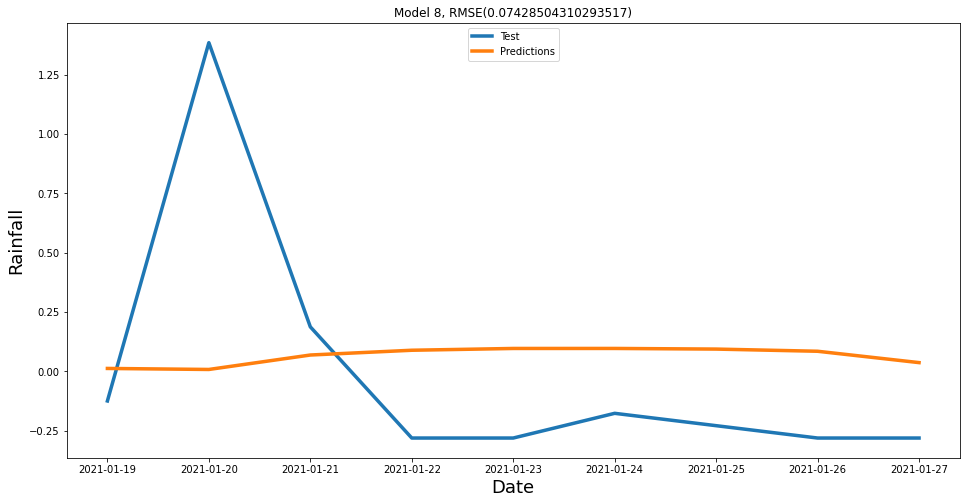

(554, 10, 1) (554,)
(61, 10, 1) (61,)
(60, 10, 1) (60,)


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)



val_loss >= loss


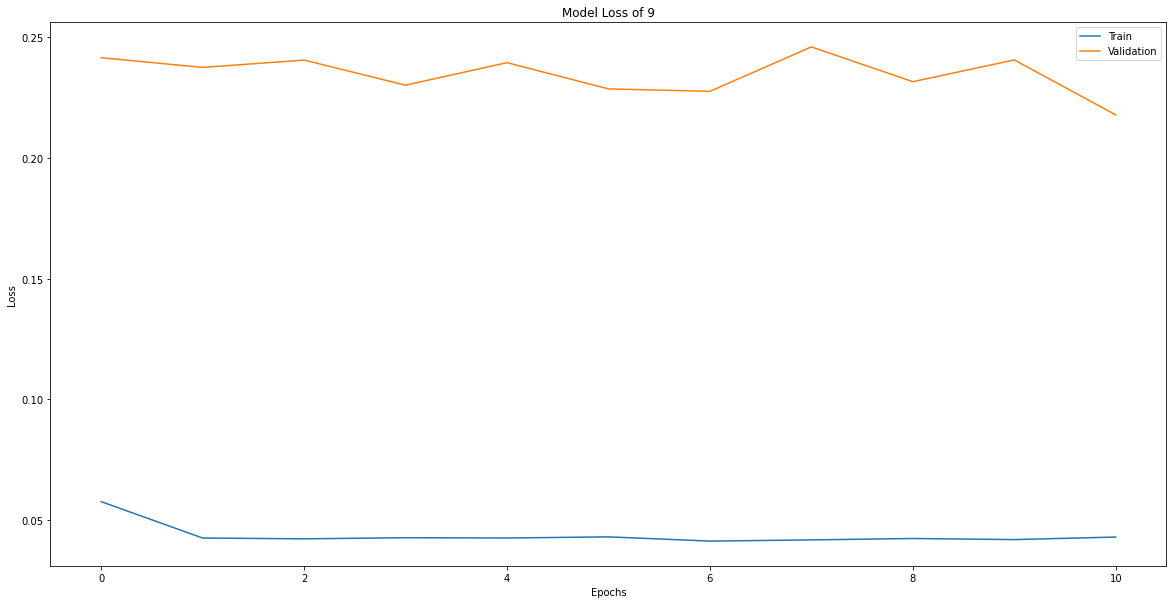

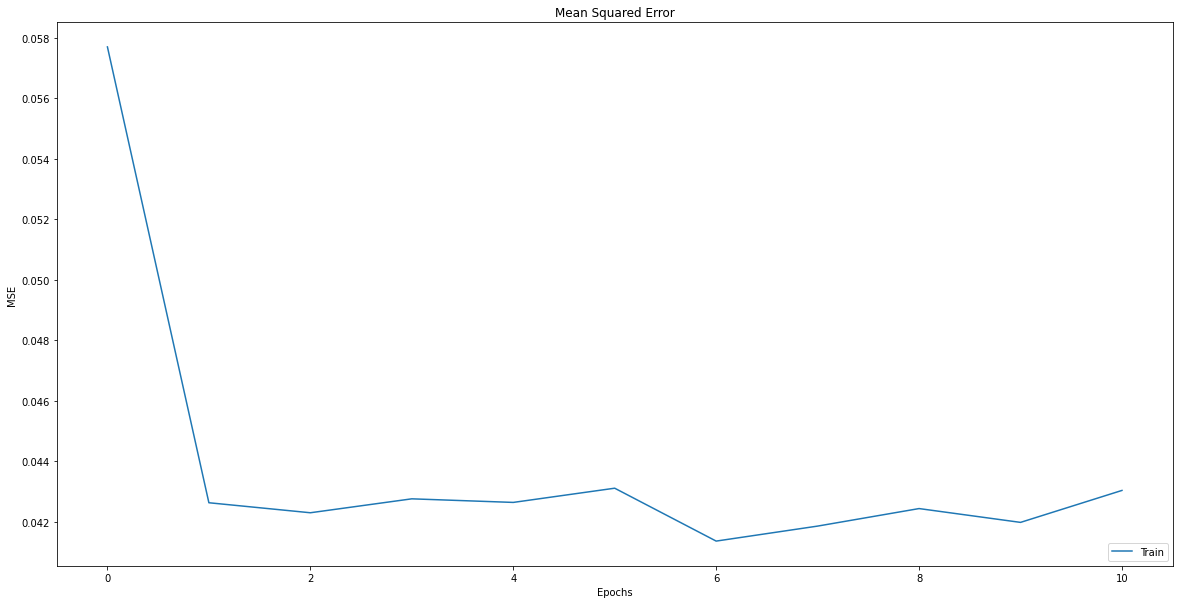

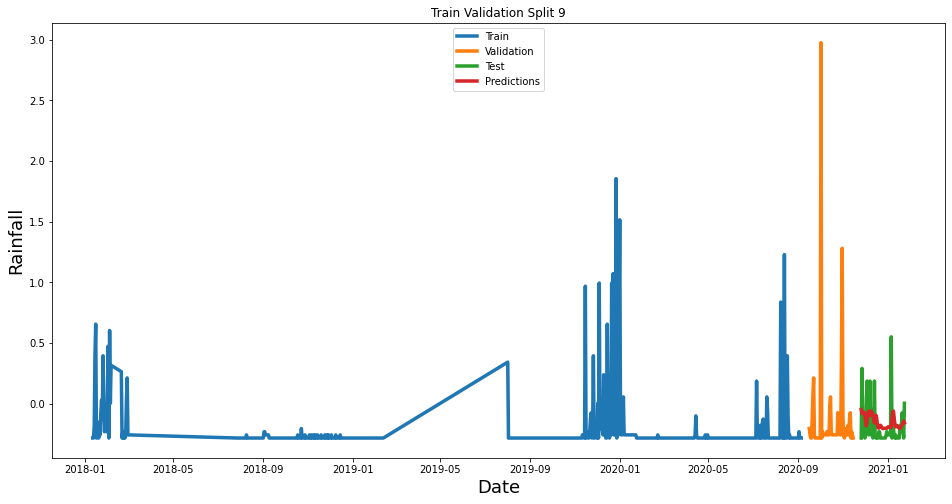

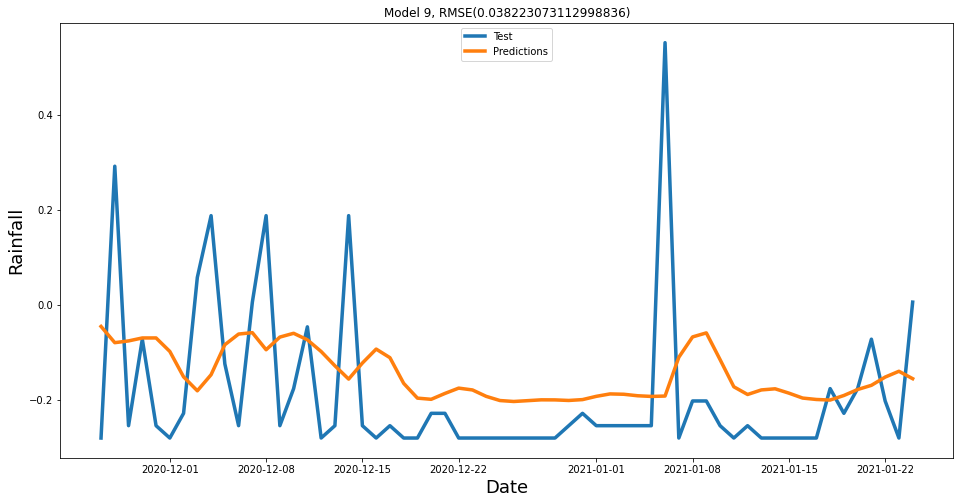

(502, 10, 1) (502,)
(54, 10, 1) (54,)
(53, 10, 1) (53,)


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)



val_loss >= loss


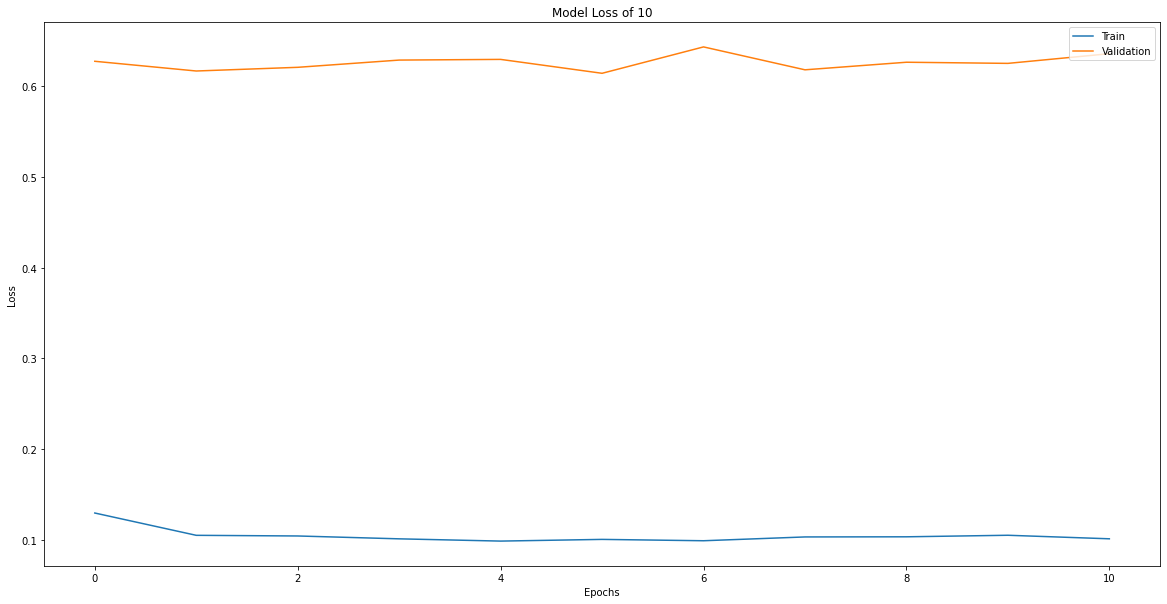

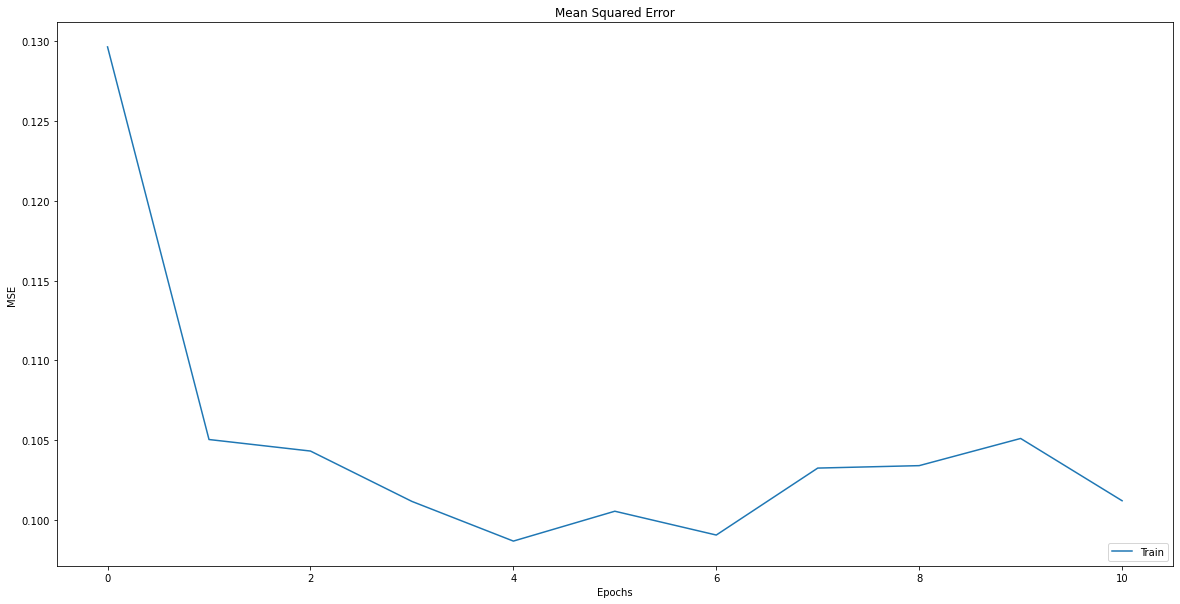

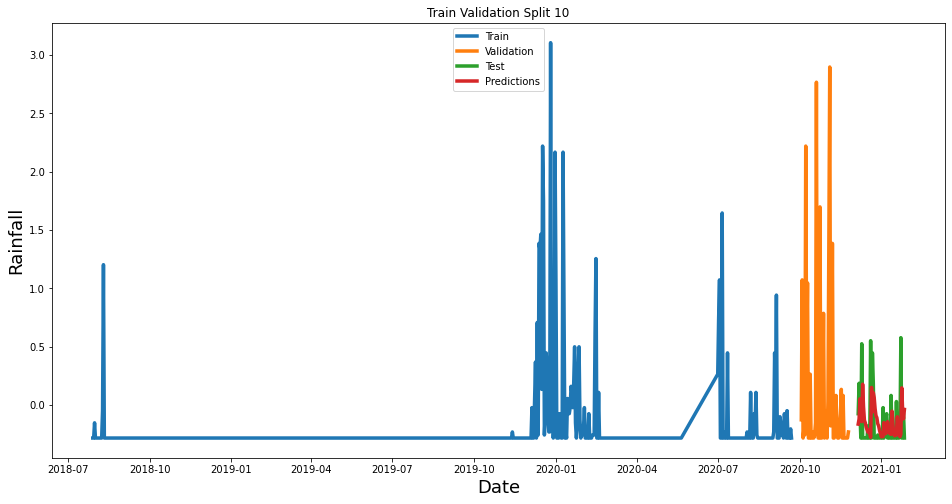

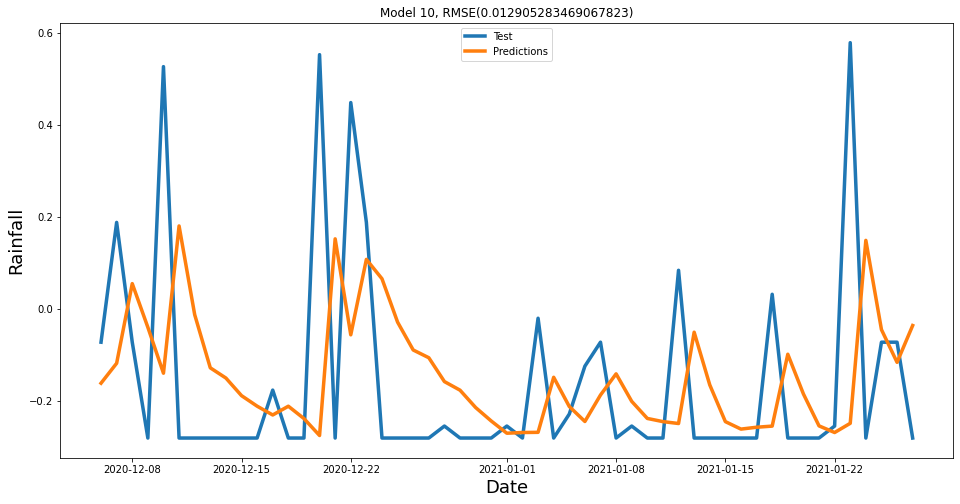

(601, 10, 1) (601,)
(67, 10, 1) (67,)
(65, 10, 1) (65,)


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


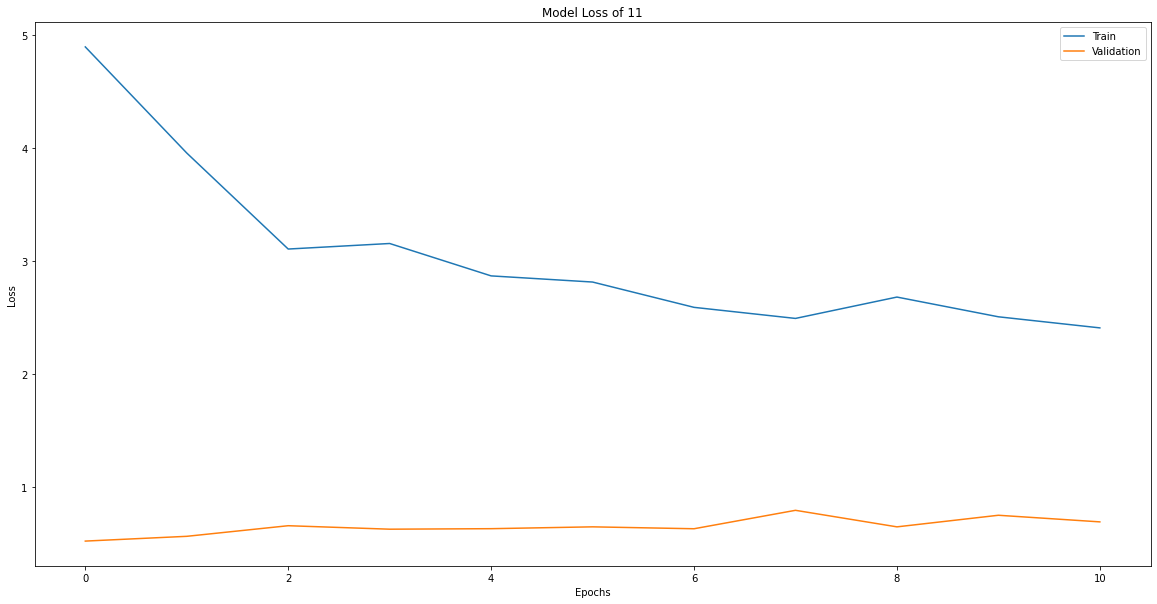

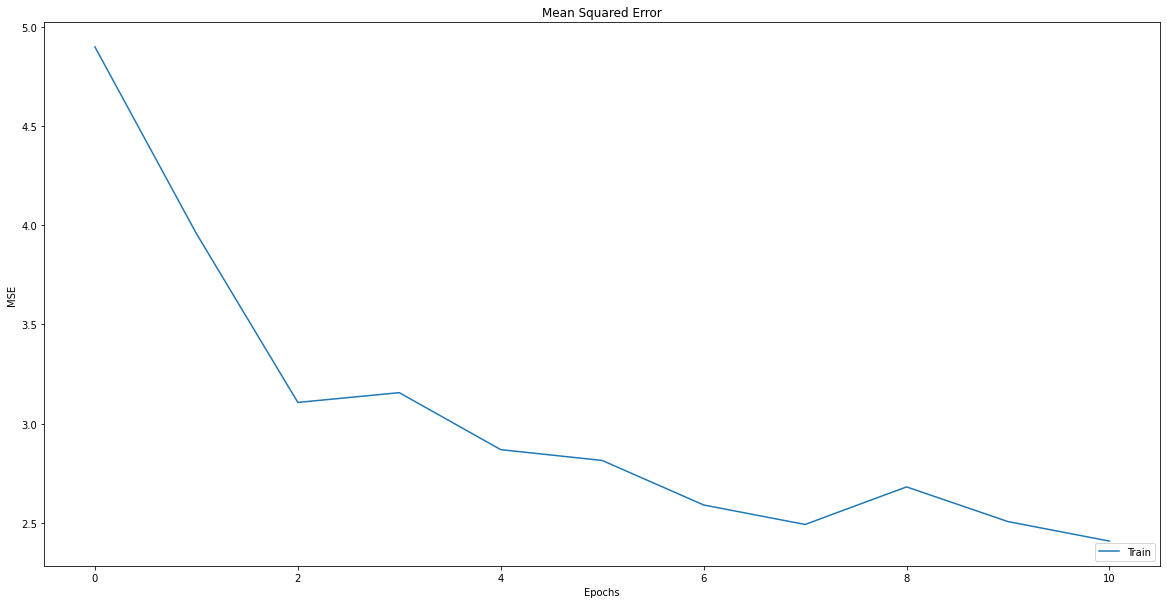

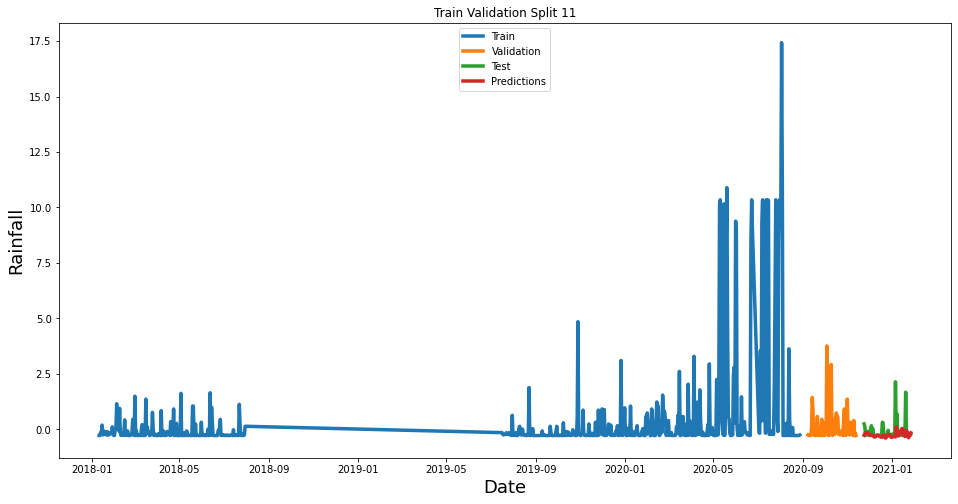

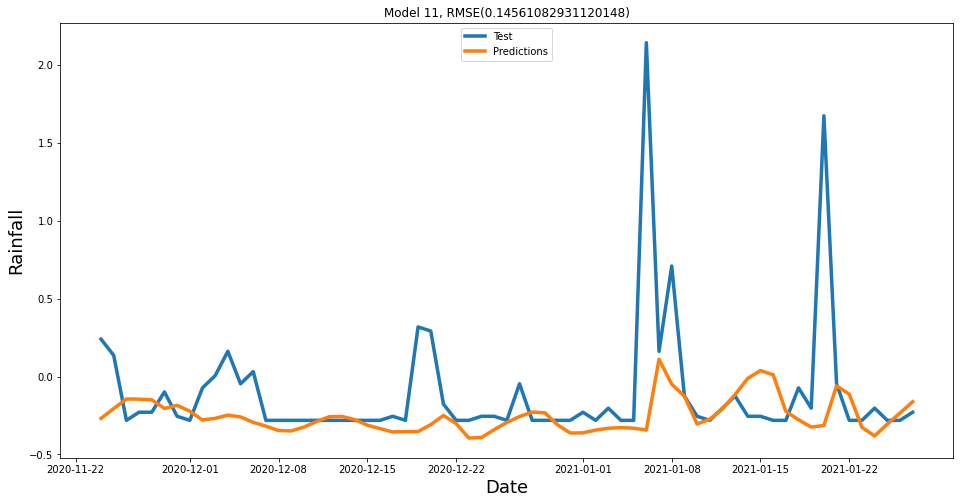

(542, 10, 1) (542,)
(59, 10, 1) (59,)
(58, 10, 1) (58,)


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)



val_loss >= loss


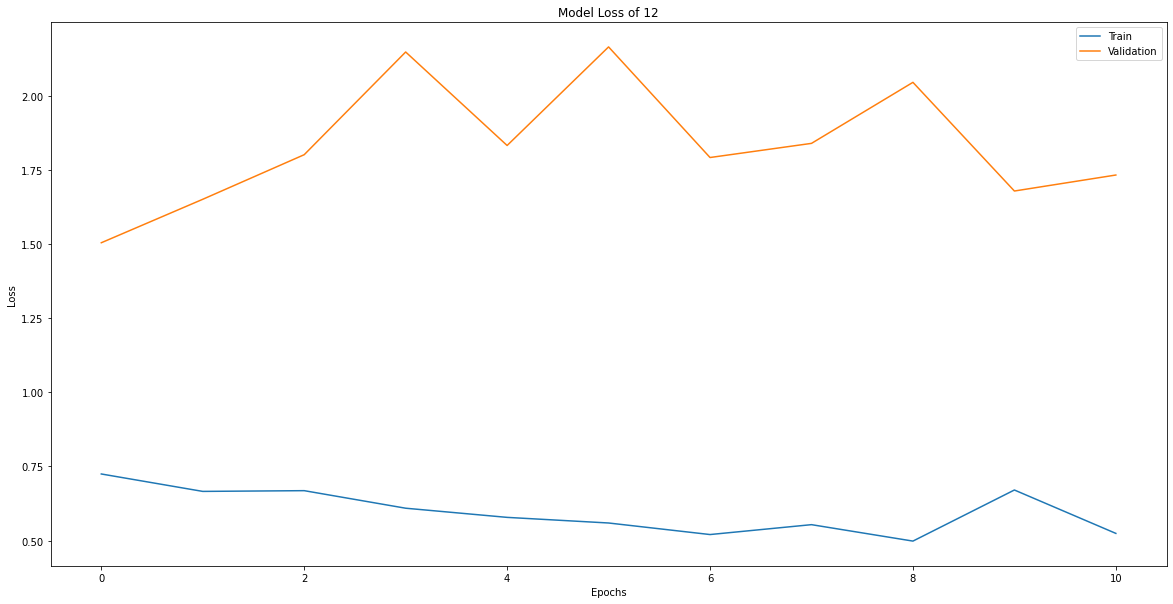

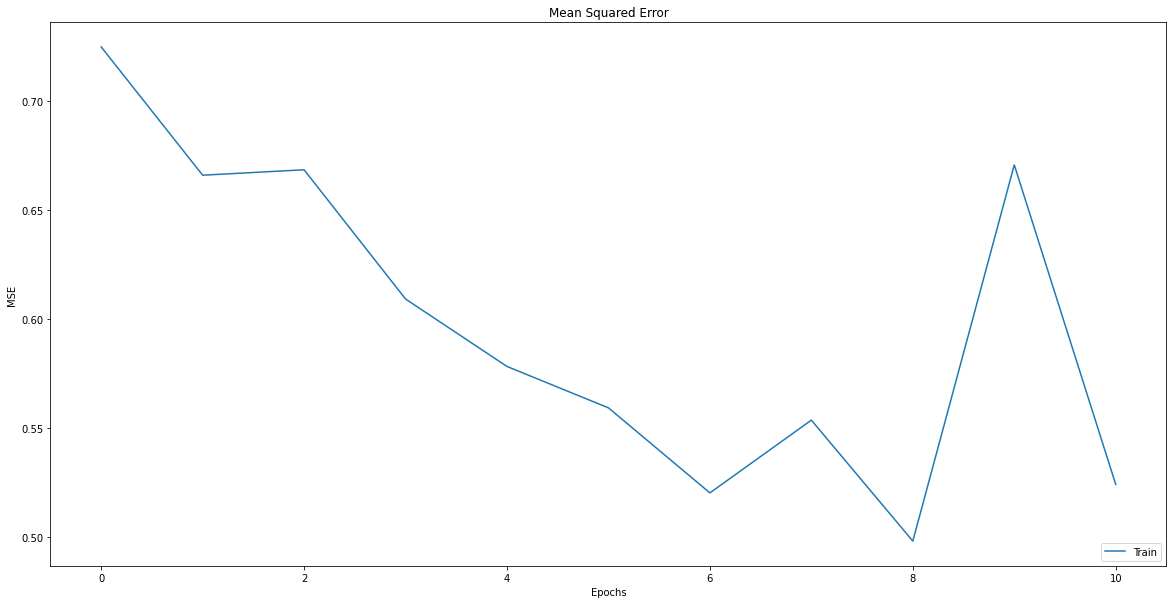

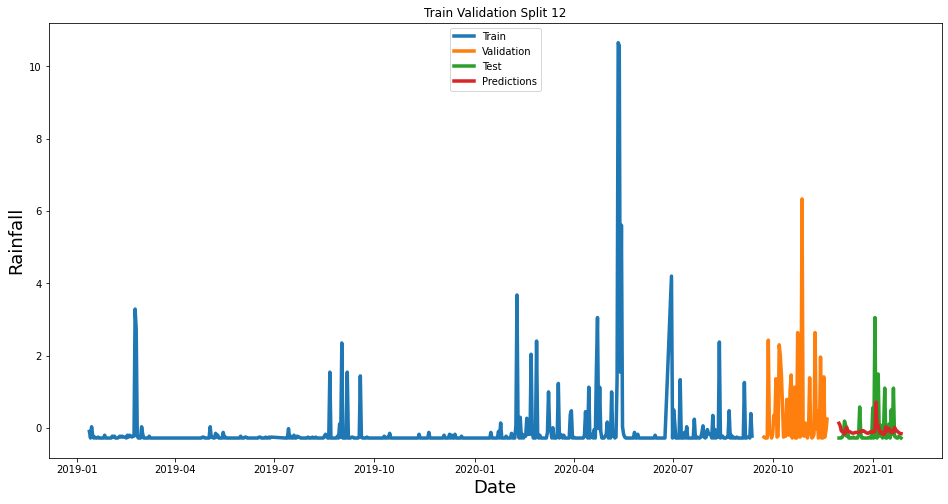

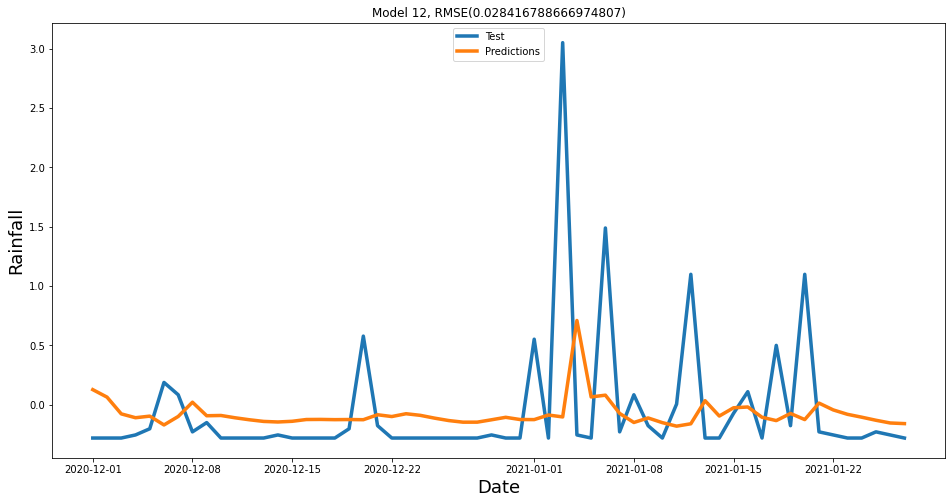

(255, 10, 1) (255,)
(24, 10, 1) (24,)
(22, 10, 1) (22,)


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)



val_loss >= loss


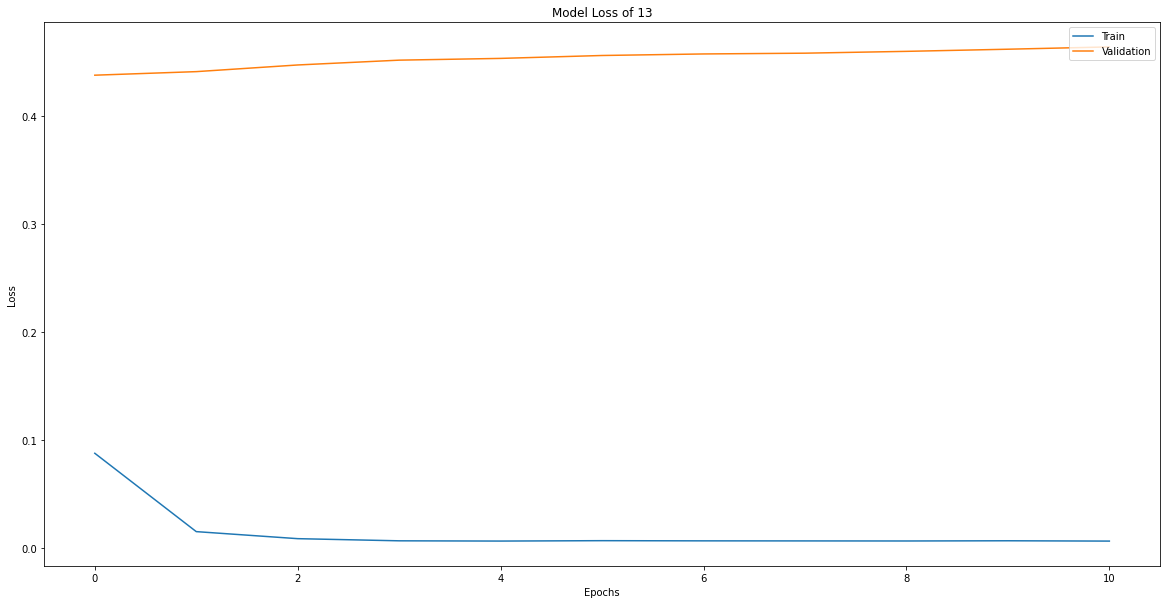

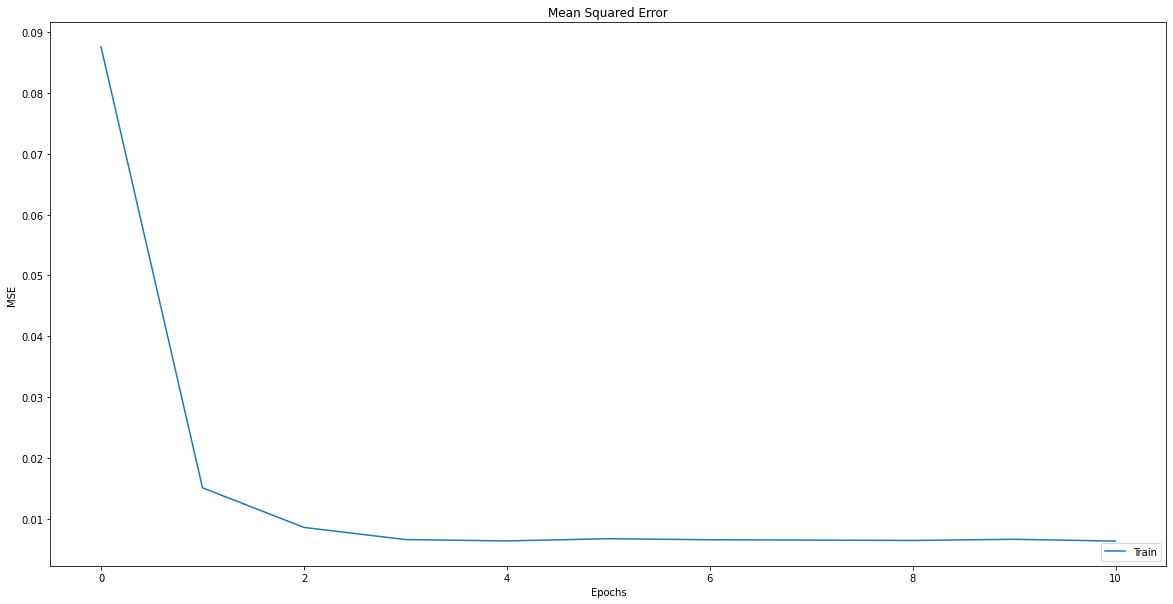

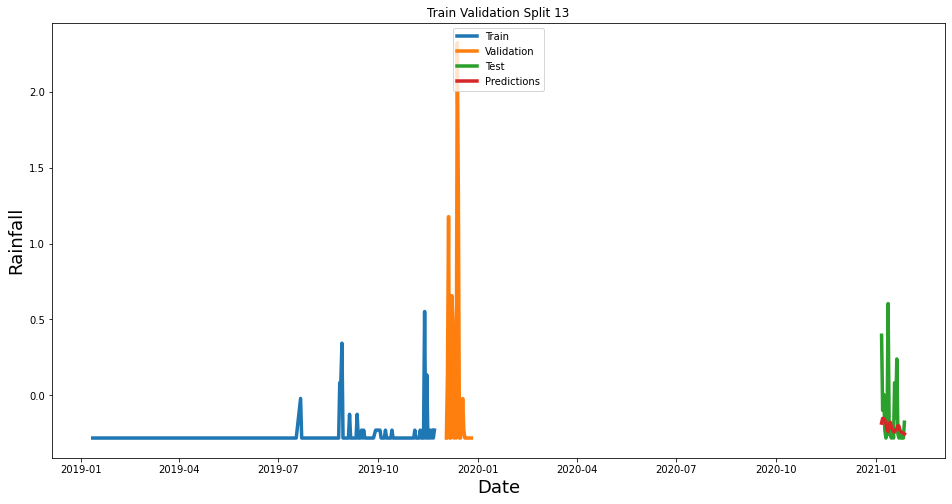

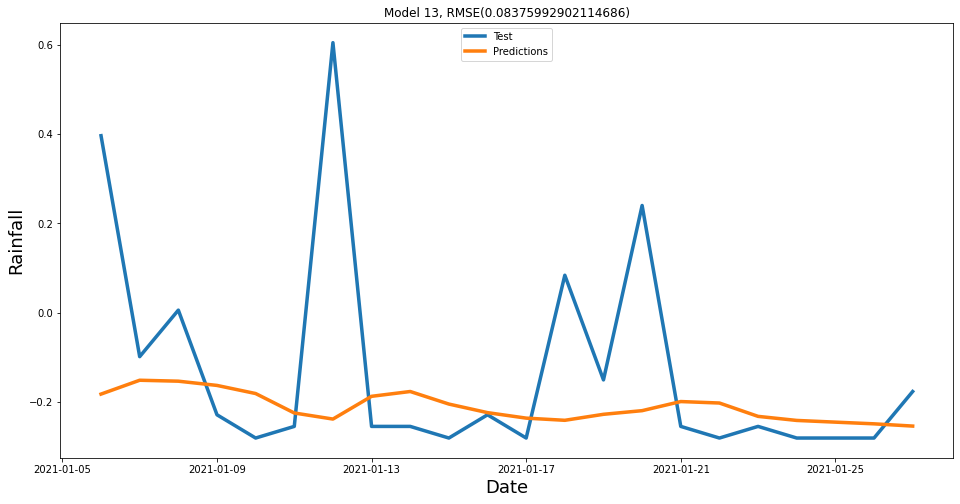

(155, 10, 1) (155,)
(11, 10, 1) (11,)
(10, 10, 1) (10,)


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)



val_loss >= loss


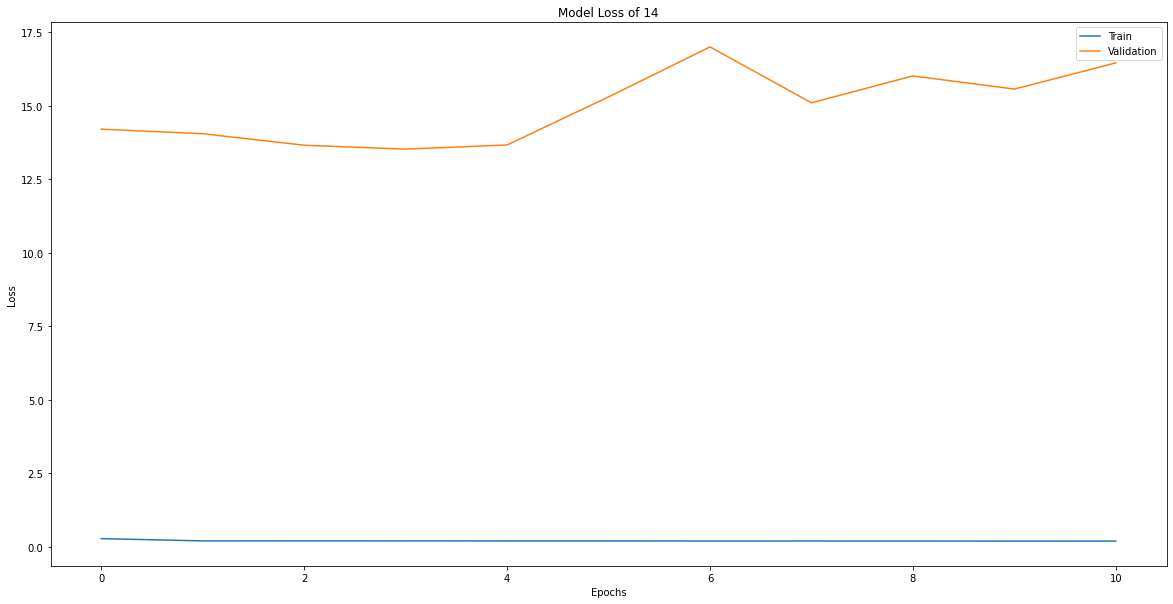

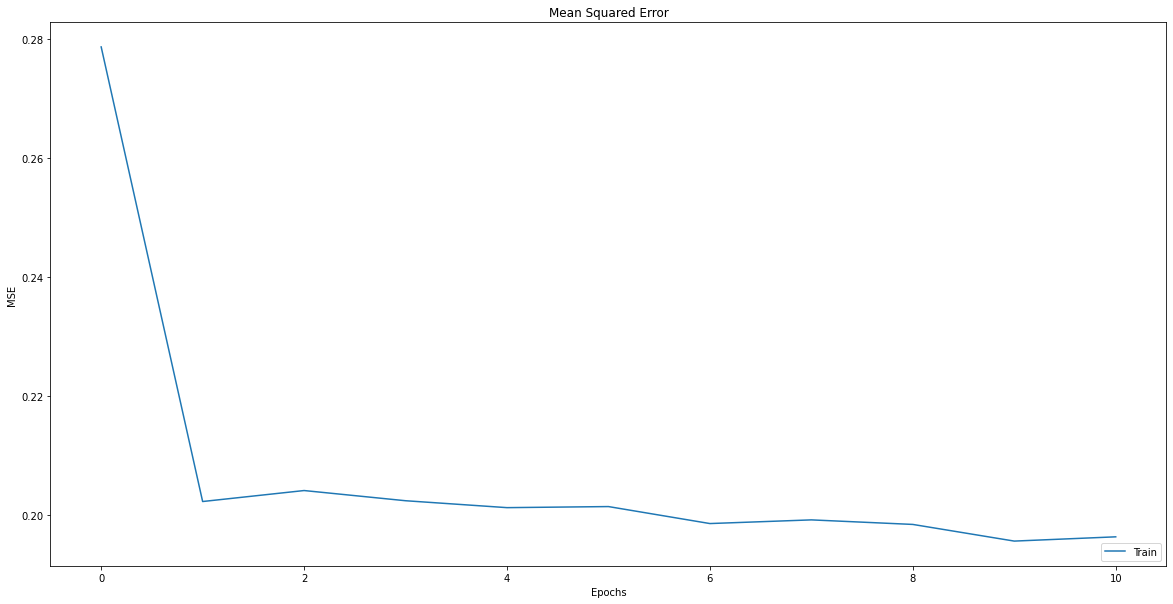

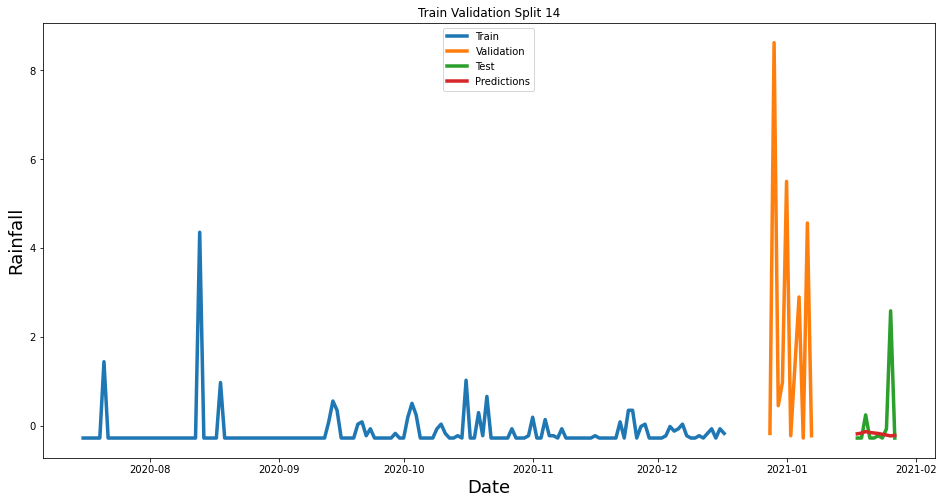

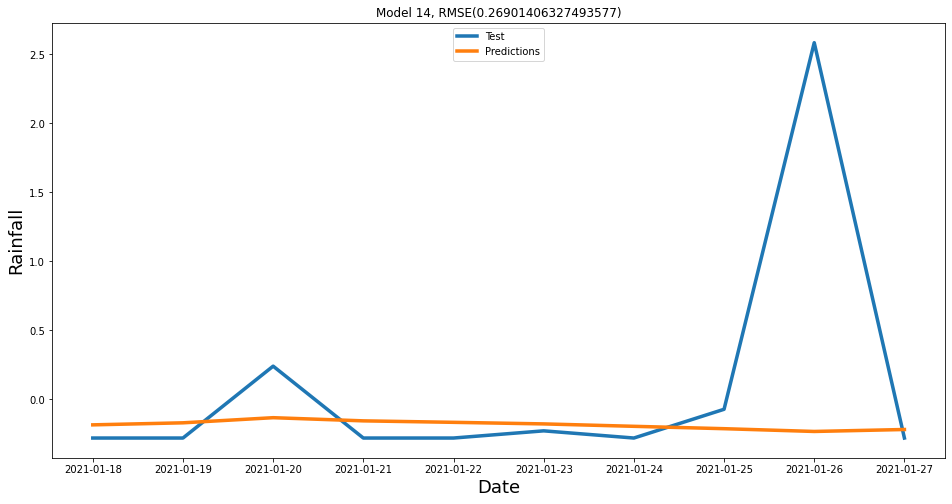

(645, 10, 1) (645,)
(72, 10, 1) (72,)
(71, 10, 1) (71,)


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)



val_loss >= loss


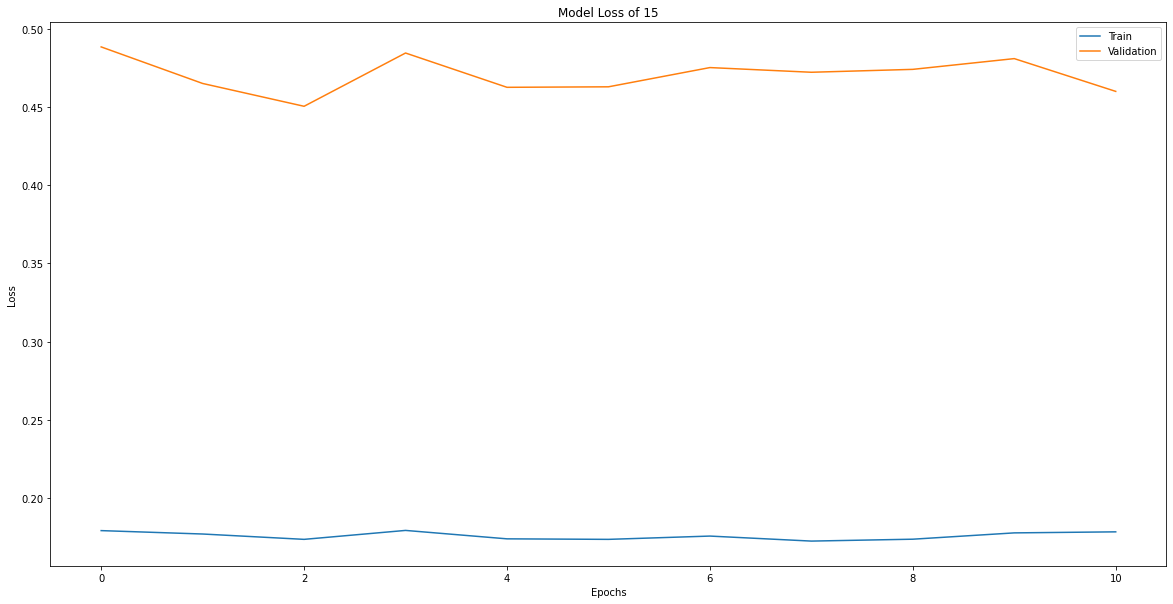

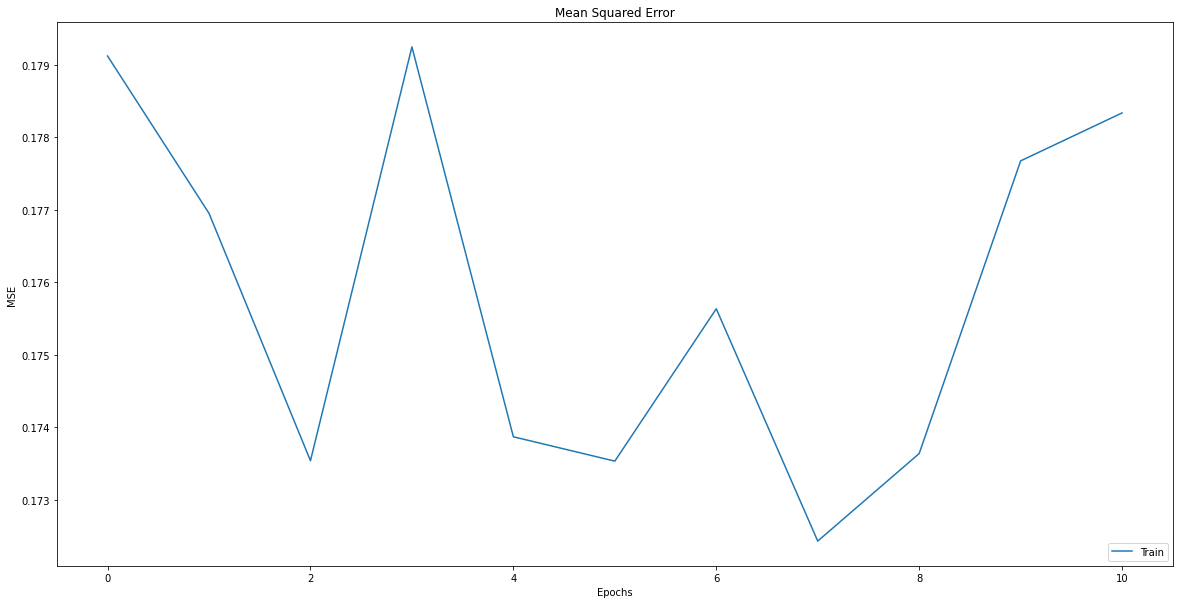

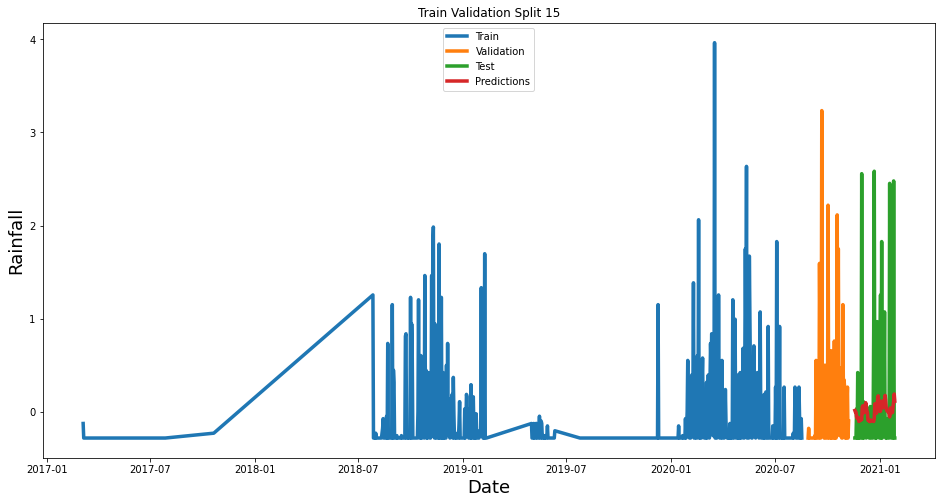

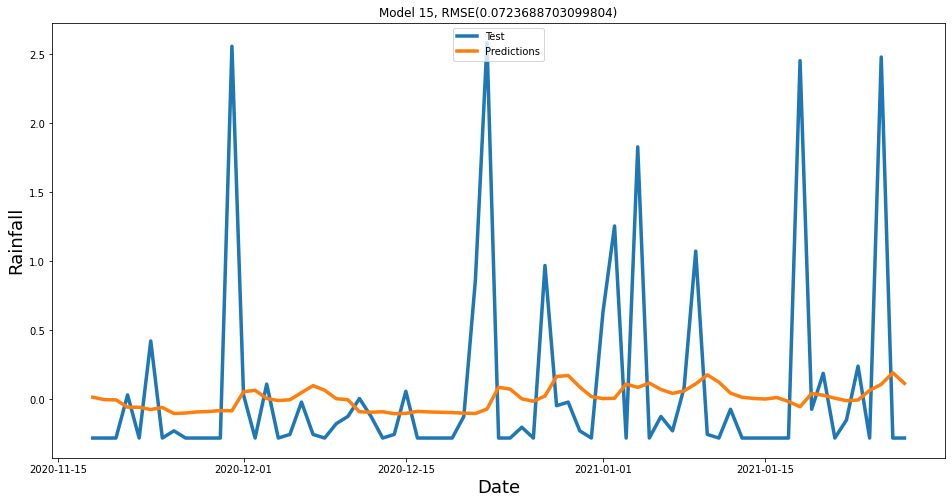

(340, 10, 1) (340,)
(34, 10, 1) (34,)
(33, 10, 1) (33,)


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


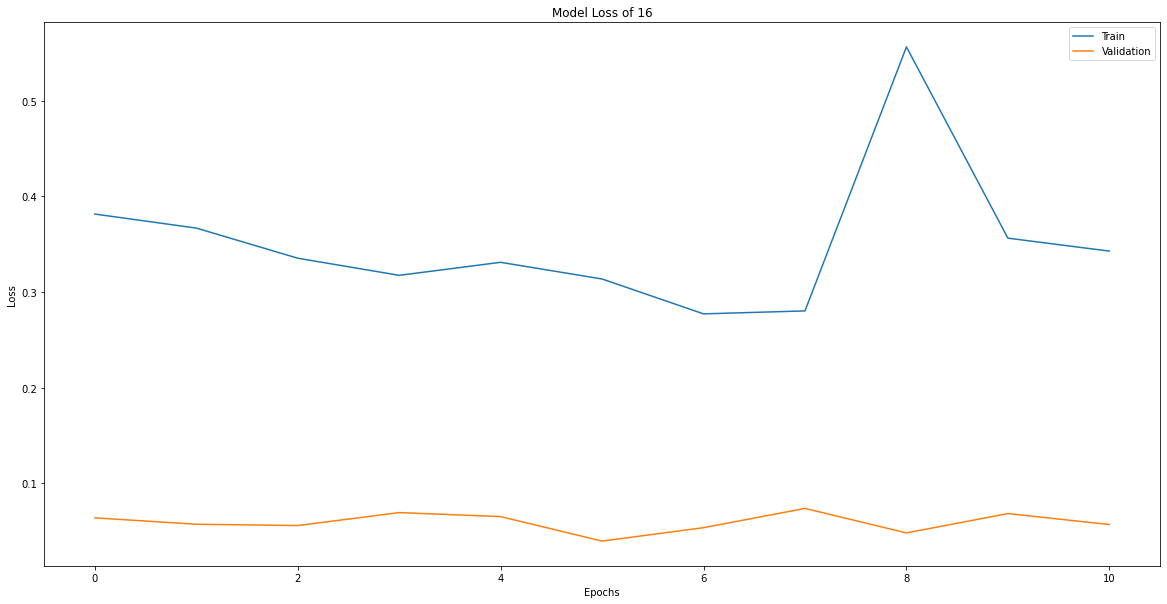

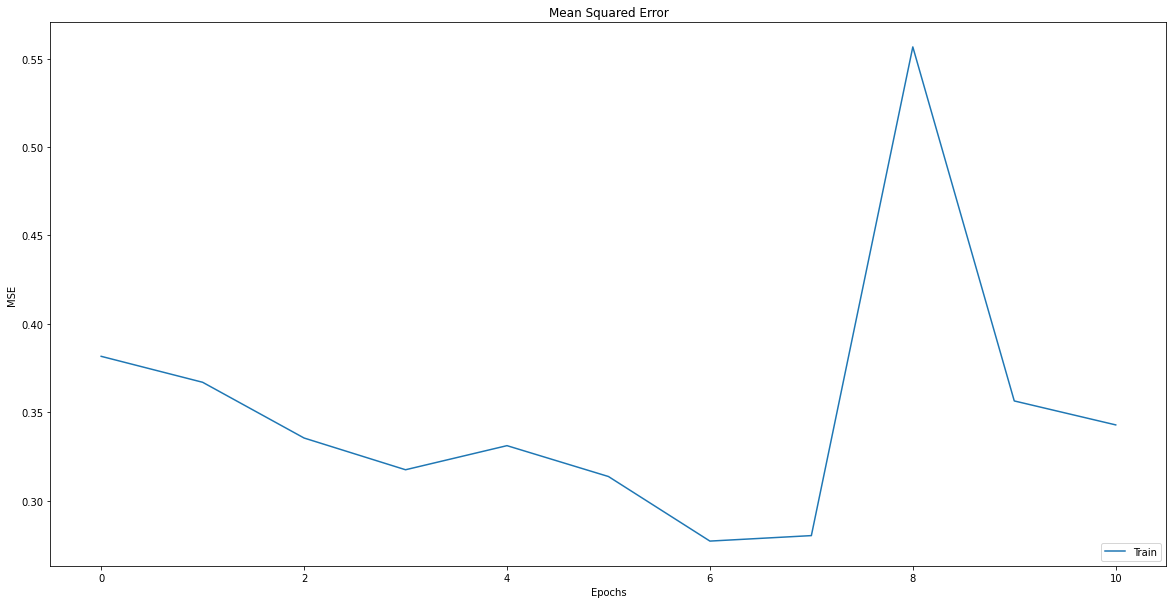

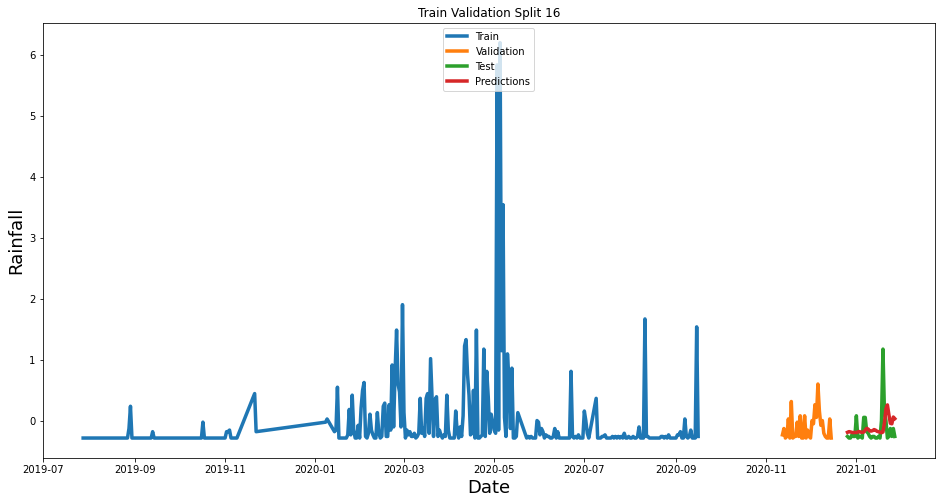

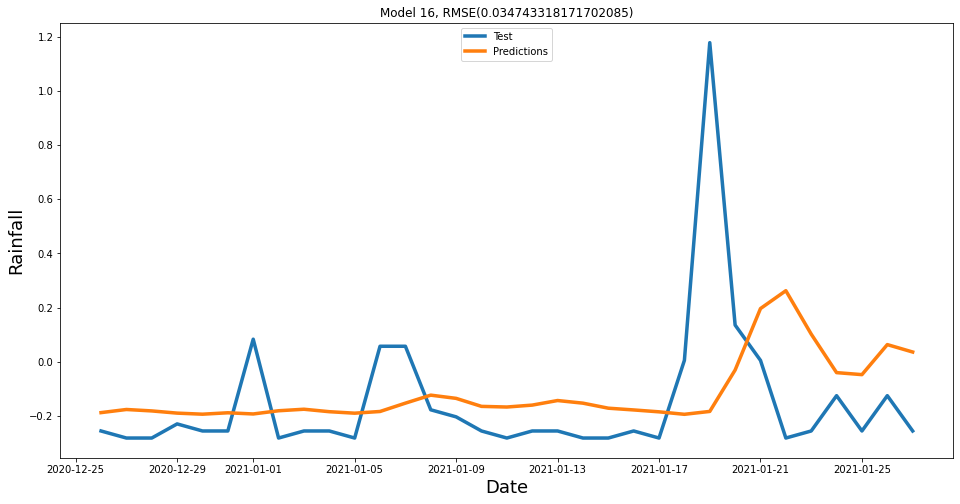

(147, 10, 1) (147,)
(10, 10, 1) (10,)
(9, 10, 1) (9,)


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


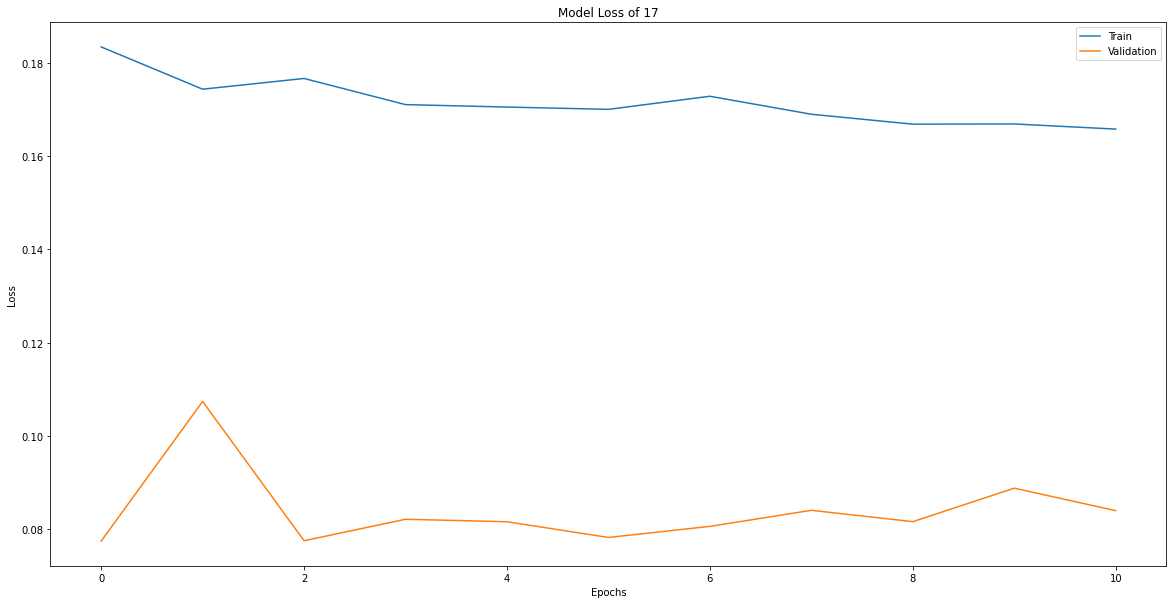

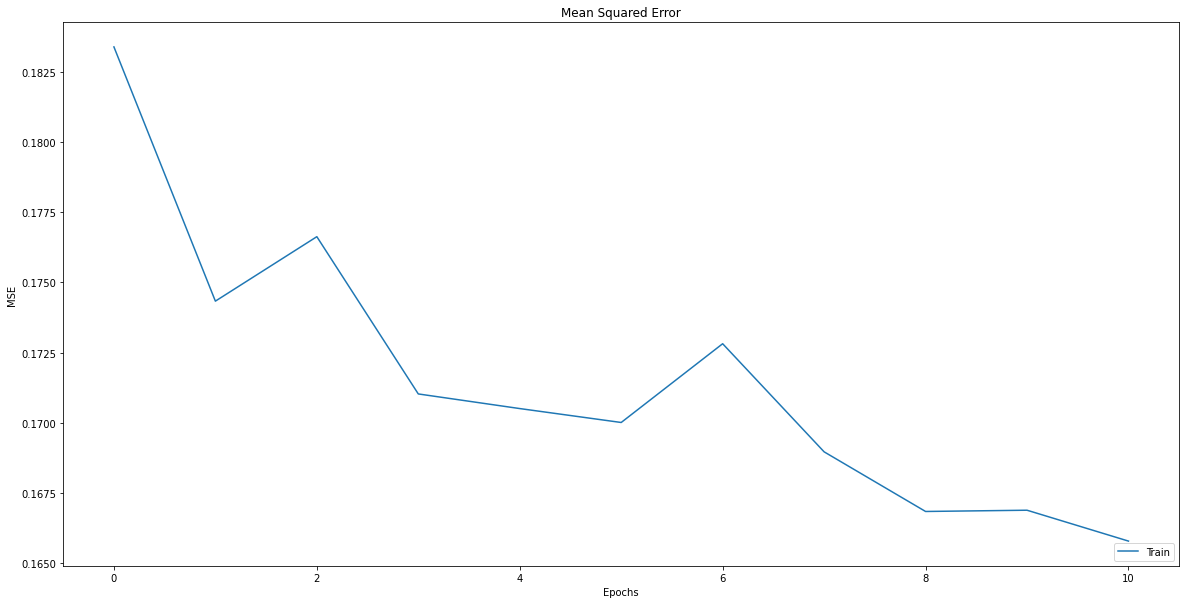

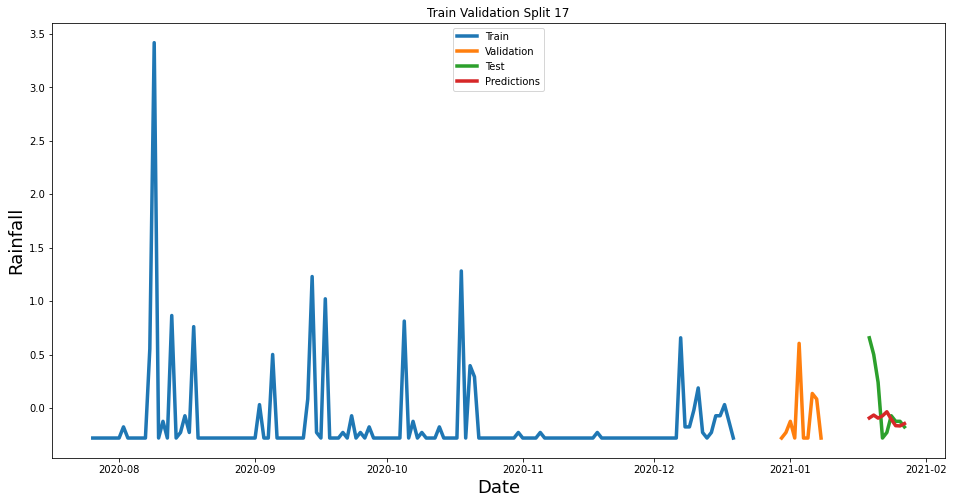

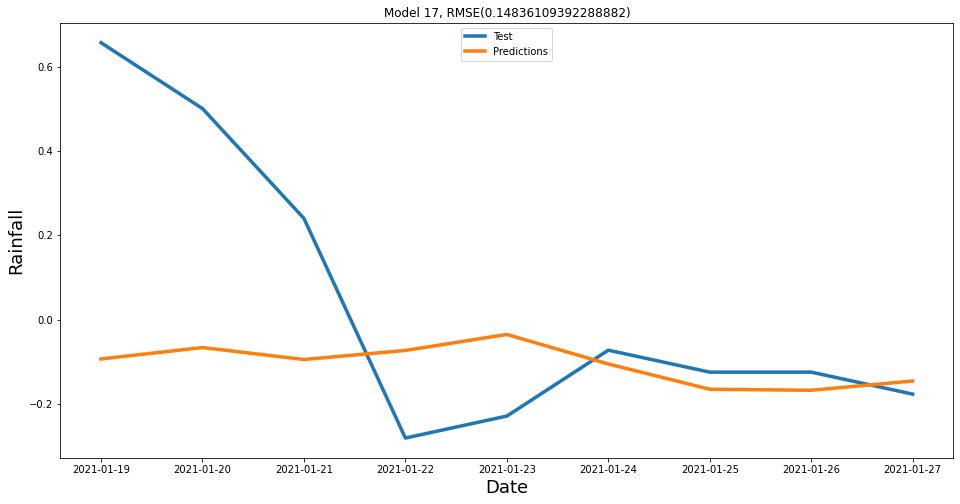

(454, 10, 1) (454,)
(48, 10, 1) (48,)
(47, 10, 1) (47,)


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


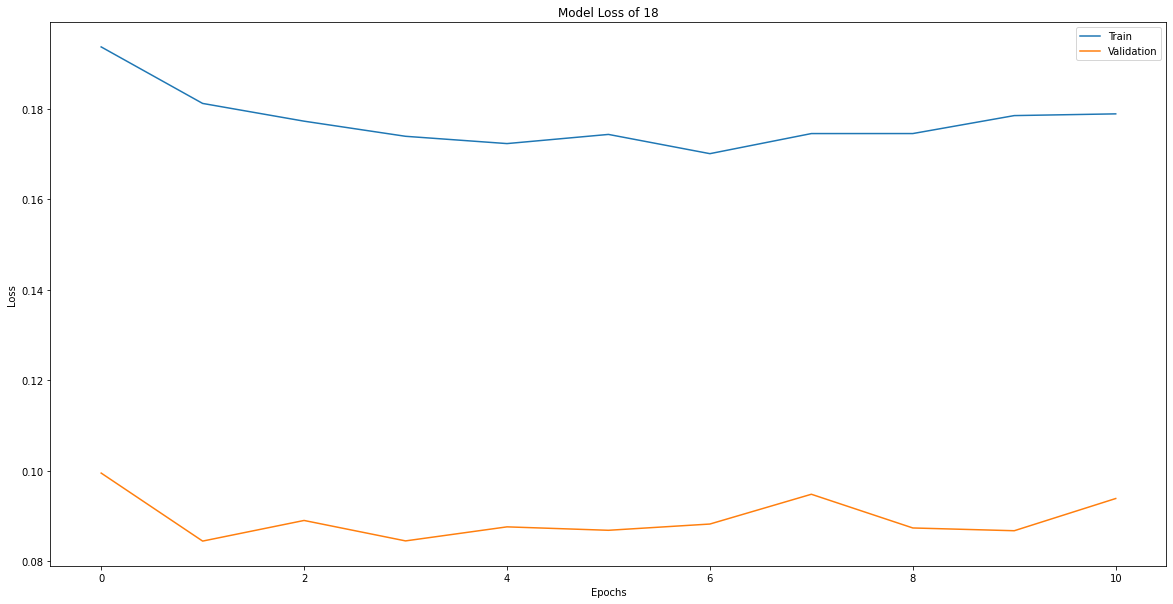

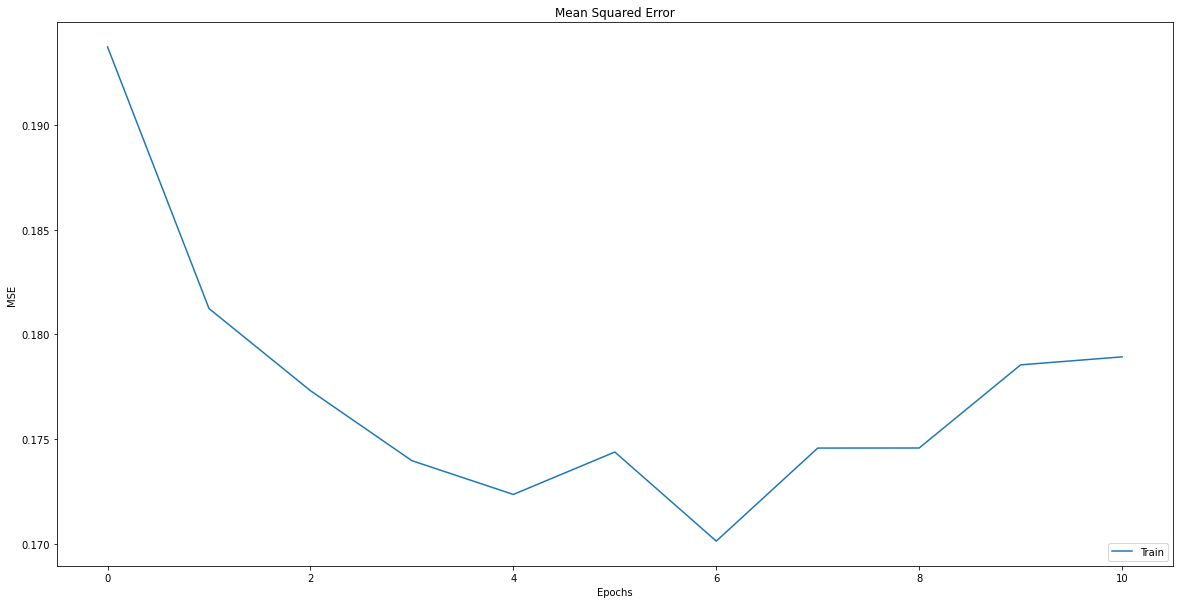

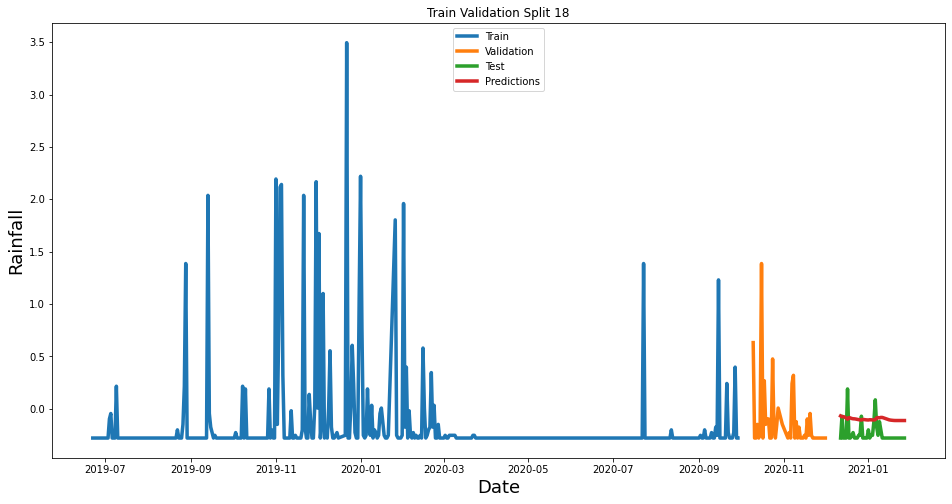

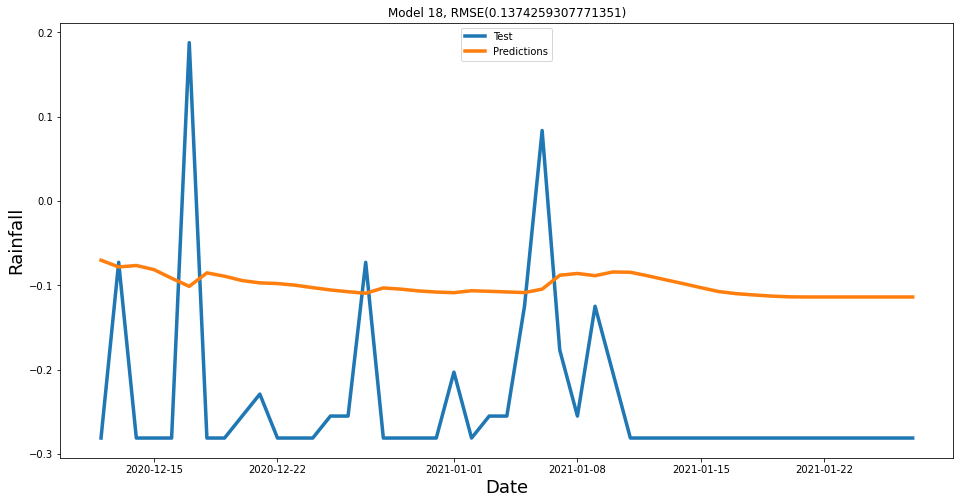

In [125]:
# Generate all lstm model for each location
locations = json.load(open(banjir_mapping_location, "r"))["Location"].values()
window = 10 # can predict 10 days ahead

# Callback model
class Callback(tf.keras.callbacks.Callback):
  def on_train_begin(self, logs={}):
        self.history = {'loss':[], 'val_loss':[], 'avg_pass_tresshold': 5}
  def on_epoch_end(self, epoch, logs={}):
    # mse = history.get("mse")
    # if (mse<0.05):
    #   self.model.stop_training = True
    # Stop to prevent overfit but not too early
    if epoch > 1:
        val_avg = np.average(self.history["val_loss"])
        if logs.get('val_loss') > val_avg and self.history["avg_pass_tresshold"] <= 0:
          print("Validation loss not improving, stopping!")
          self.model.stop_training = True
        elif logs.get('val_loss') < val_avg:
          self.history["avg_pass_tresshold"] += 1
        else:
          self.history["avg_pass_tresshold"] -= 1
          
    if logs.get("val_loss") >= logs.get("loss") and epoch >= 10 and self.history["avg_pass_tresshold"] <= 0:
      print("\nval_loss >= loss")
      self.model.stop_training = True
    if epoch >= 10:
      self.model.stop_training = True

early_stop_callback = Callback()

for location in locations:
  df = get_rainfall_by_location(location)

  # create new data frame with only 'Rainfall' column
  data = df[['Rainfall']]
  if len(data) <= 31: continue
  
  # split data
  train_data, valid_data, test_data = train_valid_test_split(data, (0.8, 0.1, 0.1))
  train_data_date, valid_data_date, test_data_date = train_valid_test_split(df[["Date"]], (0.8, 0.1, 0.1)) # For plotting

  # Create feature using sliding window 
  x_train, y_train = generate_forecast_feature(train_data)
  print(x_train.shape, y_train.shape)
  x_valid, y_valid = generate_forecast_feature(valid_data)
  print(x_valid.shape, y_valid.shape)
  x_test, y_test = generate_forecast_feature(test_data)
  print(x_test.shape, y_test.shape)

  # Build LSTM model
  model = Sequential()
  model.add(LSTM(1024, return_sequences=True, input_shape=(x_train.shape[1], 1)))
  model.add(LSTM(1024, return_sequences=False))
  model.add(Dense(512, activation="relu"))
  model.add(Dropout(0.1))
  model.add(Dense(256, activation="relu"))
  model.add(Dense(1))

  # Compile the model
  # model.compile(optimizer='adam', loss='mean_squared_error')
  # Compile the model
  optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
  model.compile(loss=tf.keras.losses.MeanSquaredError(reduction="auto", name="mean_squared_error"),
                optimizer=optimizer,
                metrics=["mse"])

  # Train the model
  logs = model.fit(
      x_train, 
      y_train,
      verbose=False,
      epochs=1000, 
      callbacks=[early_stop_callback], 
      validation_data=(x_valid, y_valid),
  )

  # Show Model Performance
  plt.plot(logs.history["loss"])
  plt.plot(logs.history["val_loss"])
  plt.title("Model Loss of %s"%location)
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.legend(["Train", "Validation"], loc="upper right")
  plt.show()

  plt.plot(logs.history["mse"])
  plt.title("Mean Squared Error")
  plt.xlabel("Epochs")
  plt.ylabel("MSE")
  plt.legend(["Train", "Validation"], loc="lower right")
  plt.show()

  # Try to predict
  forecast_set = model.predict(x_test)

  # Accuracy (RMSE)
  rmse = np.sqrt(np.mean(forecast_set - y_test)**2)

  # visualization of the data
  if ENABLE_OUTPUT: 
    plt.figure(figsize=(16,8))
    plt.title('Train Validation Split %s'%(location))
    plt.xlabel('Date', fontsize=18)
    plt.ylabel('Rainfall', fontsize=18)
    plt.plot(train_data_date.ravel()[window:], y_train, linewidth=3.5)
    plt.plot(valid_data_date.ravel()[window:], y_valid, linewidth=3.5)
    plt.plot(test_data_date.ravel()[window:], pd.DataFrame({"test":y_test, "predi": forecast_set.ravel()}),  linewidth=3.5)
    plt.legend(['Train', 'Validation', 'Test','Predictions'], loc='upper center')
    plt.show()
    ## Zoom
    plt.figure(figsize=(16,8))
    plt.title('Model %s, RMSE(%s)'%(location, rmse))
    plt.xlabel('Date', fontsize=18)
    plt.ylabel('Rainfall', fontsize=18)
    plt.plot(test_data_date.ravel()[window:], pd.DataFrame({"test":y_test, "predi": forecast_set.ravel()}),  linewidth=3.5)
    plt.legend(['Test','Predictions'], loc='upper center')
    plt.show()


  model.save("models/lstm-predict-banjir-%s.h5"%location)

# Usage In Cloud

### Sklearn

In [126]:
import pandas as pd
import numpy as np
import pickle
import json
from datetime import timedelta
import os

BASE_DIR = "."

class Transformer:
  """Convert non numeric categorical data to numeric value
  """
  def __init__(self):
    self.mapping_keys = {}
    self.mapping_location = os.path.join(BASE_DIR, "transformer-map.json")

  def load(self):
    self.mapping_keys = json.load(open(self.mapping_location, "r"))
    return self.mapping_location

  def fit_transform(self, df):
    columns = df.columns.values
    self.mapping_keys = {}

    for column in columns:
      text_digit_vals = {}
      if df[column].dtype != np.int64 and df[column].dtype != np.float64:
        column_contents = df[column].values.tolist()
        unique_elements = sorted(set(column_contents), key=lambda x: str(x))
        x = 0
        for unique in unique_elements:
          if unique not in text_digit_vals:
            text_digit_vals[unique] = x
            x += 1
        df[column] = df.apply(lambda row: text_digit_vals[row[column]], axis=1)
        self.mapping_keys[column] = text_digit_vals

      return df

  def transform(self, df):
    columns = df.columns.values
    for column in columns:
      if df[column].dtype != np.int64 and df[column].dtype != np.float64:
        df[column] = df.apply(lambda row: self.mapping_keys[column][row[column]], axis=1)
    return df
  
  def save_mapping(self):
    json.dump(self.mapping_keys, open(self.mapping_location, "w"))
    return self.mapping_location

# Load datasheet
df_tmrain_tmwater_days = pd.read_csv(os.path.join(BASE_DIR, "df_tmrain_tmwater_days.csv"))
def get_rainfall_by_location(location, upto_date=None):
  if upto_date:
    return df_tmrain_tmwater_days[["Date", "Location", "Rainfall", "Banjir"]][df_tmrain_tmwater_days["Location"] == location].sort_values("Date")[df_tmrain_tmwater_days["Date"] <= upto_date]
  return df_tmrain_tmwater_days[["Date", "Location", "Rainfall", "Banjir"]][df_tmrain_tmwater_days["Location"] == location].sort_values("Date")

# load transfomer
transformer = Transformer()
banjir_mapping_location = transformer.load()

# loads all models to memory for fast response
## classification model
models = {}
mknn_banjir = pickle.load(open(os.path.join(BASE_DIR, "models/mknn-predict-banjir.pkl"), "rb"))
scaler = pickle.load(open(os.path.join(BASE_DIR, "scaler.pkl"), "rb"))
models["mknn-banjir"] = mknn_banjir

## regression models
locations = json.load(open(banjir_mapping_location, "r"))["Location"].values()
for location in locations:
  m = pickle.load(open(os.path.join(BASE_DIR, "models/mreg-predict-banjir-%s.pkl"%location), "rb"))
  models[location] = m

In [127]:
window = 10
location_transform = json.load(open(banjir_mapping_location, "r"))["Location"]
def predict_banjir(location: str, future_days=1, after_date=None):
  # transform location
  location = location_transform[location]
  # get future forecast
  if after_date:
    data = get_rainfall_by_location(location, upto_date=after_date)
  else:  
    data = get_rainfall_by_location(location)
  
  time = data[['Date']]
  data = data[['Rainfall']]
  dataset = data.values # convert the data frame to numpy array
  len_dataset = len(dataset)
  history_data = dataset[len_dataset-2*window:, :] # get last 20 days data

  # predict rainfall next future_days
  rmses = []
  for i in range(future_days):
    # predict rainfall next day
    
    x_test = []
    y_test = history_data

    for i in range(window, len(history_data)):
        x_test.append(history_data[i-window:i, 0])

    # convert the data  to numpy array
    x_test = np.array(x_test)
    forecast_set = models[location].predict(x_test)

    # calculate error
    rmse = np.sqrt(np.mean(forecast_set - y_test)**2)
    rmses.append(rmse)

    # new history based on prediction
    history_data = np.concatenate((history_data, [[forecast_set[-1]]]))
    history_data = np.delete(history_data, 0, axis=0)
  
  # predict banjir or no using knn model
  input_value = []
  for i in range(future_days):
    input_value.append([location, forecast_set[i]])
  # if ENABLE_OUTPUT:  print("input_value (scaled)=",input_value)
  df_banjir_to_predict = pd.DataFrame(input_value, columns=["Location", "Rainfall"])
  df_banjir_to_predict = transformer.transform(df_banjir_to_predict)
  predictions = models['mknn-banjir'].predict(df_banjir_to_predict)

  # prepare output prediction
  # 95% Confidence Interval (CI) example. CI = y_hat +/- 1.96*rmse

  # Inverse transform Rainfall
  forecast_set = scaler.inverse_transform(forecast_set.reshape(-1,1)).ravel()

  output = []
  pred_time = pd.to_datetime(time.values[-1][0])
  for i in range(future_days):
    pred_time =  pred_time + timedelta(days=1)
    output.append([predictions[i], rmses[i], forecast_set[i], pred_time])
  return output, ("prediction", "rmse", "forecasted_rainfall", "date")

output, col_name = predict_banjir("Sumur Batu", future_days=3)
pd.DataFrame(output, columns=col_name)

prediction      rmse  forecasted_rainfall       date
0           1  3.675330            50.240270 2021-01-28
1           1  3.591981            31.051632 2021-01-29
2           1  3.021340            49.406268 2021-01-30

In [128]:
# Kampung Kelapa before 2019-12-24

df_tmrain_tmwater_days[df_tmrain_tmwater_days["Location"] == location_transform["Kampung Kelapa"]].sort_values("Date")[df_tmrain_tmwater_days["Date"] <= "2019-01-01"].tail(10)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


Date  Time  Location  Rainfall  RainfallStatus   WaterLevel  Banjir
7597  2018-12-09     0        10       0.0               0  9607.569187       0
7599  2018-12-10    12        10       0.0               0  9607.569187       0
7600  2018-12-11     0        10       0.0               0  9607.569187       0
7640  2018-12-12     9        10       0.0               0  9607.569187       0
7641  2018-12-13     2        10       0.0               0  9607.569187       0
7642  2018-12-14    15        10       0.0               0  9607.569187       0
7637  2018-12-15    13        10       0.0               0  9607.569187       0
7634  2018-12-16    10        10       0.0               0  9607.569187       0
7635  2018-12-17     0        10       0.0               0  9607.569187       0
7638  2018-12-18     6        10       0.0               0  9607.569187       0

In [129]:
from datetime import datetime
output, out_name = predict_banjir("Kampung Kelapa", future_days=10, after_date="2018-11-16")
pd.DataFrame(output, columns=out_name)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


prediction      rmse  forecasted_rainfall       date
0           0  0.055096             4.338024 2018-11-17
1           0  0.052341             4.338024 2018-11-18
2           0  0.050705             4.123242 2018-11-19
3           0  0.048823             4.063067 2018-11-20
4           0  0.047452             3.934845 2018-11-21
5           0  0.046629             3.765585 2018-11-22
6           0  0.046453             3.556616 2018-11-23
7           0  0.046218             3.463623 2018-11-24
8           0  0.045951             3.423157 2018-11-25
9           0  0.046717             3.204561 2018-11-26

### Tensorflow

In [130]:
import tensorflow as tf
import keras
import pandas as pd
import numpy as np
import pickle
import json
from datetime import timedelta
import os

BASE_DIR = "."

class Transformer:
  """Convert non numeric categorical data to numeric value
  """
  def __init__(self):
    self.mapping_keys = {}
    self.mapping_location = os.path.join(BASE_DIR, "transformer-map.json")

  def load(self):
    self.mapping_keys = json.load(open(self.mapping_location, "r"))
    return self.mapping_location

  def fit_transform(self, df):
    columns = df.columns.values
    self.mapping_keys = {}

    for column in columns:
      text_digit_vals = {}
      if df[column].dtype != np.int64 and df[column].dtype != np.float64:
        column_contents = df[column].values.tolist()
        unique_elements = sorted(set(column_contents), key=lambda x: str(x))
        x = 0
        for unique in unique_elements:
          if unique not in text_digit_vals:
            text_digit_vals[unique] = x
            x += 1
        df[column] = df.apply(lambda row: text_digit_vals[row[column]], axis=1)
        self.mapping_keys[column] = text_digit_vals

      return df

  def transform(self, df):
    columns = df.columns.values
    for column in columns:
      if df[column].dtype != np.int64 and df[column].dtype != np.float64:
        df[column] = df.apply(lambda row: self.mapping_keys[column][row[column]], axis=1)
    return df
  
  def save_mapping(self):
    json.dump(self.mapping_keys, open(self.mapping_location, "w"))
    return self.mapping_location

# Load datasheet
df_tmrain_tmwater_days = pd.read_csv(os.path.join(BASE_DIR, "df_tmrain_tmwater_days.csv"))
def get_rainfall_by_location(location, upto_date=None):
  if upto_date:
    return df_tmrain_tmwater_days[["Date", "Location", "Rainfall", "Banjir"]][df_tmrain_tmwater_days["Location"] == location].sort_values("Date")[df_tmrain_tmwater_days["Date"] <= upto_date]
  return df_tmrain_tmwater_days[["Date", "Location", "Rainfall", "Banjir"]][df_tmrain_tmwater_days["Location"] == location].sort_values("Date")

# load transfomer
transformer = Transformer()
banjir_mapping_location = transformer.load()

# loads all models to memory for fast response
## classification model
models = {}
kerasbinary_banjir = keras.models.load_model("models/kerasbinary-predict-banjir.h5")
scaler = pickle.load(open(os.path.join(BASE_DIR, "scaler.pkl"), "rb"))
models["kerasbinary-banjir"] = kerasbinary_banjir

## regression models
locations = json.load(open(banjir_mapping_location, "r"))["Location"].values()
for location in locations:
  try:
    m = keras.models.load_model("models/lstm-predict-banjir-%s.h5"%location)
    models[location] = m
  except Exception as err:
    print(err)

SavedModel file does not exist at: models/lstm-predict-banjir-5.h5/{saved_model.pbtxt|saved_model.pb}


In [131]:
window = 10
location_transform = json.load(open(banjir_mapping_location, "r"))["Location"]
def reshape_to_3d(X):
  """Reshape 2d np array X to 3d np array X
  Args:
    X (np.array): 2d np array
  Returns:
    X (np.array): 3d np array
  """
  X = np.reshape(X, (X.shape[0], X.shape[1], 1))
  return X

def predict_banjir(location: str, future_days=1, after_date=None):
  # transform location
  location = location_transform[location]
  # get future forecast
  if after_date:
    data = get_rainfall_by_location(location, upto_date=after_date)
  else:  
    data = get_rainfall_by_location(location)
  
  time = data[['Date']]
  data = data[['Rainfall']]
  dataset = data.values # convert the data frame to numpy array
  len_dataset = len(dataset)
  history_data = dataset[len_dataset-2*window:, :] # get last 20 days data

  # predict rainfall next future_days
  rmses = []
  for i in range(future_days):
    # predict rainfall next day
    
    x_test = []
    y_test = history_data

    for i in range(window, len(history_data)):
        x_test.append(history_data[i-window:i, 0])

    # convert the data  to numpy array
    x_test = np.array(x_test)
    x_test = reshape_to_3d(x_test)
    forecast_set = models[location].predict(x_test)
    forecast_set = forecast_set.ravel()

    # calculate error
    rmse = np.sqrt(np.mean(forecast_set - y_test)**2)
    rmses.append(rmse)

    # new history based on prediction
    history_data = np.concatenate((history_data, [[forecast_set[-1]]]))
    history_data = np.delete(history_data, 0, axis=0)
  
  # predict banjir or no using knn model
  input_value = []
  for i in range(future_days):
    input_value.append([location, forecast_set[i]])
  # if ENABLE_OUTPUT:  print("input_value (scaled)=",input_value)
  df_banjir_to_predict = pd.DataFrame(input_value, columns=["Location", "Rainfall"])
  df_banjir_to_predict = df_banjir_to_predict.values.reshape(-1,1)
  df_banjir_to_predict = reshape_to_3d(df_banjir_to_predict)
  predictions = models['kerasbinary-banjir'].predict(df_banjir_to_predict)
  predictions = predictions.ravel()

  # prepare output prediction
  # 95% Confidence Interval (CI) example. CI = y_hat +/- 1.96*rmse

  # Inverse transform Rainfall
  forecast_set = scaler.inverse_transform(forecast_set.reshape(-1,1)).ravel()

  output = []
  pred_time = pd.to_datetime(time.values[-1][0])
  for i in range(future_days):
    pred_time =  pred_time + timedelta(days=1)
    output.append([predictions[i], rmses[i], forecast_set[i], pred_time])
  return output, ("prediction", "rmse", "forecasted_rainfall", "date")

output, col_name = predict_banjir("Sumur Batu", future_days=3)
pd.DataFrame(output, columns=col_name)

prediction      rmse  forecasted_rainfall       date
0    0.104818  5.515388           -29.051456 2021-01-28
1    0.000000  5.528177           -35.660839 2021-01-29
2    0.104818  4.904192           -30.894676 2021-01-30

In [132]:
# Kampung Kelapa before 2019-12-24

df_tmrain_tmwater_days[df_tmrain_tmwater_days["Location"] == location_transform["Kampung Kelapa"]].sort_values("Date")[df_tmrain_tmwater_days["Date"] <= "2020-12-14"].tail(10)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


Date  Time  Location  Rainfall  RainfallStatus   WaterLevel  Banjir
1564  2020-12-05     1        10       4.5               2  9607.569187       0
1678  2020-12-06     7        10       4.0               2  9607.569187       0
1080  2020-12-07    23        10       9.0               4  9607.569187       0
1658  2020-12-08    17        10       4.0               2  9607.569187       0
8008  2020-12-09    13        10       0.0               0  9607.569187       0
725   2020-12-10     3        10      15.5               1  9607.569187       1
8014  2020-12-11    20        10       0.0               0  9607.569187       0
8015  2020-12-12     8        10       0.0               0  9607.569187       0
8012  2020-12-13    15        10       0.0               0  9607.569187       0
8010  2020-12-14    13        10       0.0               0  9607.569187       0

In [133]:
from datetime import datetime
output, out_name = predict_banjir("Kampung Kelapa", future_days=10, after_date="2020-12-14")
pd.DataFrame(output, columns=out_name)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


prediction      rmse  forecasted_rainfall       date
0    0.191934  1.328877            22.793678 2020-12-15
1    0.789813  1.203319            31.862669 2020-12-16
2    0.191934  1.253880            18.790184 2020-12-17
3    0.451162  1.369251             8.809144 2020-12-18
4    0.191934  1.552803             7.643537 2020-12-19
5    0.998423  1.579466             9.557528 2020-12-20
6    0.191934  1.613635            11.641259 2020-12-21
7    0.022435  2.006762             9.760649 2020-12-22
8    0.191934  2.009899             8.096461 2020-12-23
9    0.034122  1.631239             7.200579 2020-12-24

_The model with keras is crazy big. 151 mb each model._

_That size times how much locations and preloaded that into memory, surely gonna blow the server_